# Experiments

In [1]:
# !pip2 install pypolyagamma

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import importlib
import os
import sys

from base.experiment import *
from logistic.env_logistic import *
from logistic.agent_logistic import *
from utils import *

import numpy as np
import numpy.linalg as npla
import scipy.linalg as spla
import pandas as pd
import plotnine as gg

#import importlib
#importlib.reload(logistic.agent_logistic)
#reload(sys.modules['logistic.agent_logistic'])

# Setup

Here $d=20$ and the number of arms is $A=20$. The number of timesteps is $T=1000$.

At the beginning $\theta\sim N(0,I_d)$ and $c\sim N(0,1)$ are generated. The reward given context $x\in \mathbb R^d$ is $\text{Bernoulli}(\sigma(\theta^\top x + c))$ where $\sigma(x) = \frac{e^x}{1+e^x}$. At each step $x_{t,1},\ldots, x_{t,A}\sim \text{Bernoulli}(1/d)^d$ are randomly generated, and the algorithm picks one of the arms $1,\ldots, A$ and gets the corresponding stochastic reward.

If the algorithm chose actions $a_t$, regret is measured as $\max_{\{a_t^*\}} \sigma(\theta^\top x_{t,a_t^*}+c) - \sum_{t=1}^T \sigma(\theta^\top x_{t,a_t}+c)$, i.e., expected reward  against the best choice of $a_t^*$'s if $\theta$ were known.


In [2]:
def simple_compare(agents, num_articles, dim, var, n_steps, seed=0, verbosity=0):
    env = LogisticBandit(num_articles, dim+1, NormalDist(0,1,dim=dim+1), DistributionWithConstant(BernoulliDist(1/dim,dim=dim)), seed=seed)
    experiment = ExperimentCompare(agents, env, n_steps,
                   seed=seed, verbosity=verbosity)
    experiment.run_experiment()
    results = []
    results.append(experiment.results)
    df = pd.DataFrame(results[0])
    cum_regrets = experiment.cum_regret
    #https://stackoverflow.com/questions/39092067/pandas-dataframe-convert-column-type-to-string-or-categorical
    df['agent_id'] = df.agent_id.astype('category')
    print(gg.ggplot(df)
     + gg.aes('t', 'cum_regret', color='agent_id', group='agent_id')
     + gg.geom_point()
     + gg.geom_line())
    print(gg.ggplot(df)
     + gg.aes('t', 'time', color='agent_id', group='agent_id')
     + gg.geom_point()
     + gg.geom_line())
    return results, df, cum_regrets

def simple_compares(make_agents, num_articles, dim, var, n_steps, seeds, verbosity=0):
    results_list = []
    df_list = []
    cum_regrets_list = []
    avg_regrets = np.zeros(len(make_agents))
    for seed in seeds:
        agents = [make_agent() for make_agent in make_agents]
        results, df, cum_regrets = simple_compare(agents, num_articles, dim, var, n_steps, seed=seed, verbosity=verbosity)
        results_list += [results]
        df_list += [df]
        cum_regrets_list += [cum_regrets]
        avg_regrets += cum_regrets
    avg_regrets = avg_regrets / len(seeds)
    return results_list, df_list, cum_regrets_list, avg_regrets    

def hyperparameter_sweep(make_agent_from_hyperparameters, hyperparam_list, dim, var, n_steps, seed=0, verbosity=0):
    agents = [make_agent_from_hyperparameters(hyperparam) for hyperparam in hyperparam_list]
    results, df, cum_regrets = simple_compare(agents, num_articles, dim, var, n_steps, seed=seed, verbosity=verbosity)
    
def hyperparameter_sweeps(make_agent_from_hyperparameters, hyperparam_list, dim, var, n_steps, seeds, verbosity=0):
    results_list = []
    df_list = []
    cum_regrets_list = []
    avg_regrets = np.zeros(len(hyperparam_list))
    for seed in range(seeds):
        agents = [make_agent_from_hyperparameters(hyperparam) for hyperparam in hyperparam_list]
        results, df, cum_regrets = simple_compare(agents, num_articles, dim, var, n_steps, seed=seed, verbosity=verbosity)
        results_list += [results]
        df_list += [df]
        cum_regrets_list += [cum_regrets]
        avg_regrets += cum_regrets
    avg_regrets = avg_regrets / seeds
    return results_list, df_list, cum_regrets_list, avg_regrets


In [3]:
num_articles = 10
dim = 20
var = 1.0/9
theta_mean = 0
theta_std = 1

time_limit= 0.1

verbosity=1

In [4]:
# We will tune the Langevin, SGLD, and SAGA-LD agents.

make_langevin_agent = lambda hypers: BasicLangevinTS(num_articles, dim+1, [0]*(dim+1), cov=None, 
                                              step_size=lambda t: hypers[0]/(1 + t * np.sqrt(dim*var)/dim), n_steps=9999,
                                              time = time_limit,
                                              init_pt=None, verbosity=verbosity)
make_mala_agent = lambda: MalaTS(num_articles, dim+1, [0]*(dim+1), cov=None, 
                                 step_size=lambda t: 0.1/(1 + t * np.sqrt(dim*var)/dim), n_steps=9999,
                                 time = time_limit,
                                     init_pt=None, verbosity=verbosity)
make_sgld_agent = lambda hypers: SGLDTS(num_articles, dim+1, [0]*(dim+1), cov=None, 
                                        step_size=lambda t: hypers[0]/(1 + t * np.sqrt(dim*var)/dim),
                                        batch_size = hypers[1],
                                        time=time_limit,
                                        n_steps=9999,
                                        init_pt=None, verbosity=verbosity)
make_sagald_agent = lambda hypers: SAGATS(num_articles, dim+1, [0]*(dim+1), cov=None, 
                                          step_size=lambda t: hypers[0]/(1 + t * np.sqrt(dim*var)/dim),
                                          batch_size = hypers[1],
                                          time=time_limit,
                                          n_steps=9999,
                                          init_pt=None, verbosity=verbosity)

# Untimed MALA agent is used as baseline.

make_mala_agent_untimed = lambda: MalaTS(num_articles, dim+1, [0]*dim, cov=None, 
                                         step_size=lambda t: 0.1/(1 + t * np.sqrt(dim*var)/dim), n_steps=500,
                                         init_pt=None, verbosity=verbosity)

# Use default settings for Laplace agent for now (would be nice to tune this too). Not time-restricted.
theta_mean = 0
theta_std = 1
epsilon1 = 0.01
epsilon2 = 0.05
alpha=0.2
beta=0.5
tol=0.0001
make_laplace_agent = lambda: LaplaceTSLogisticBandit(num_articles, dim+1, theta_mean, theta_std, epsilon1,
                                                      alpha,beta,tol, verbosity=verbosity)

# PG-TS has no parameters to tune

make_pgts_agent = lambda: PGTS_Stream(num_articles, dim, intercept=True, context_has_constant=True, 
                                      n_steps=9999, time = time_limit, verbosity=verbosity)

In [5]:
#hypers = [[0.2/2**n] for n in range(5)]
#results_list_lgv, df_list_lgv, cum_regrets_list_lgv, avg_regrets_lgv = hyperparameter_sweeps(make_langevin_agent, hypers, dim, var, 1000, 4, verbosity=verbosity)

In [6]:
#print(cum_regrets_list_lgv)
#print(avg_regrets_lgv)

In [7]:
make_best_sgld_agent = lambda: SGLDTS(num_articles, dim+1, [0]*(dim+1), cov=None, 
                                        step_size=lambda t: 0.01/(1 + t * np.sqrt(dim*var)/dim),
                                        batch_size = lambda t: hypers[1],
                                        time=time_limit,
                                        n_steps=9999,
                                        init_pt=None, verbosity=verbosity)
make_best_sagald_agent = lambda: SAGATS(num_articles, dim+1, [0]*(dim+1), cov=None, 
                                          step_size=lambda t: 0.05/(1 + t * np.sqrt(dim*var)/dim),
                                          batch_size = 32,
                                          time=time_limit,
                                          n_steps=9999,
                                          init_pt=None, verbosity=verbosity)

make_best_langevin_agent = lambda: BasicLangevinTS(num_articles, dim+1, [0]*(dim+1), cov=None, 
                                              step_size=lambda t: 0.1/(1 + t * np.sqrt(dim*var)/dim), n_steps=9999,
                                              time = time_limit,
                                              init_pt=None, verbosity=verbosity)

In [10]:
import warnings
warnings.filterwarnings('ignore')

theta [-8.76395317e-01  1.24286860e+00 -8.99547301e-01  7.80467995e-02
 -9.11241747e-01  7.50631118e-01  1.67308509e+00 -3.74943108e-01
  6.05221636e-02 -8.42137543e-01 -1.63041928e-01  1.93689366e+00
  1.19210556e+00  1.48302313e+00 -1.32815212e+00  4.38939339e-01
 -1.25005356e-04 -3.59249270e-01  1.13588288e+00 -1.09598914e+00
 -8.18086609e-01]
Experiment: Step 0
 Laplace sample: array([ 0.43938487, -0.29497156, -0.0641925 , -1.10203234, -0.88765191,
        1.75518654,  0.16500894, -0.26472367,  0.93606381,  0.06663143,
       -0.27305928,  0.89262188,  0.78088812, -0.25831461, -0.15940986,
       -1.45250931, -0.65065099,  0.28211765, -0.11034803,  0.20153464,
        0.02263173])
 Sample: array([-1.00790906,  0.63287005, -2.15071696, -0.21445944,  0.52055327,
        0.75301723,  1.68663157, -1.49908501,  0.87523498, -1.25210107,
        0.08951576,  0.53546996, -1.6142033 ,  2.06629638, -0.05650643,
       -0.43718045,  1.07989012,  0.21144681, -0.81405926, -0.9666398 ,
       -0

 Steps taken: 359
 Sample: array([-0.67185383, -0.76552928, -1.1942565 ,  0.75377915, -0.85406979,
       -0.86460283,  0.31460725,  0.31675613,  0.72769842,  0.41689225,
       -0.05251655, -0.09136701,  0.25606194,  1.50583916, -0.46286223,
        0.44892937, -0.76908761,  0.53989477, -0.70531548,  0.43678498,
       -0.0688506 ])
 Sample: array([ 0.31786547, -0.28927431,  1.18952321,  0.55004392, -0.67796585,
       -0.28162289,  0.53866758, -0.67124497,  0.1928096 ,  0.57315963,
        0.20713576,  1.84321303,  1.45577699, -0.78782946,  2.11574164,
       -0.56329809, -0.68458172,  0.22507333, -1.60553727,  1.32729265,
        3.35674691])
 Steps taken: 1310
 Sample: array([-1.19860731, -0.12377974, -0.92481784,  0.19612066,  0.30531562,
       -1.29944067,  0.97501421,  0.0835904 , -0.45642746,  0.80670214,
        0.28830893, -1.14204059,  0.41937025, -0.32506176, -0.37257588,
       -0.07459295, -0.53987081, -0.13082483,  0.73449139,  0.27817209,
        0.24254485])
 Accept p

 Steps taken: 365
 Sample: array([-0.79589619,  1.61316432,  0.07251133, -0.03999827, -1.24043648,
       -0.22356754,  1.05847121, -0.04232369,  1.65590121, -1.63214611,
        0.67595365,  0.77648556,  0.84513318,  0.60364089, -1.09362048,
        0.13929965,  1.08375607,  0.84781675, -1.57551261, -0.09404559,
       -0.85477591])
 Sample: array([-1.01302698, -0.70215449, -1.39694654, -0.71930342,  1.15199731,
       -0.82947854,  0.4844062 ,  0.15569738,  0.67693034, -1.03131912,
        0.70653381, -0.70378122, -0.45551477,  1.45911878,  1.29552942,
        2.00211919, -1.11443702, -0.96887027,  1.123663  ,  1.83703217,
       -1.78789817])
 Steps taken: 1335
 Sample: array([-0.08066092,  0.2004683 , -0.22822092,  0.58775494, -0.22657525,
       -0.63223334,  0.51251328,  0.11092967, -0.32019628, -0.72981799,
        0.34656881,  0.55291346,  0.17874697,  0.97376614, -0.0415159 ,
       -0.63886811, -0.6404192 , -0.08627415, -0.75080114,  0.46260294,
       -0.20890397])
 Accept p

 Steps taken: 335
 Sample: array([-1.36566168, -1.14532994, -0.21874797, -0.40318284, -0.53896754,
        2.12368237, -1.08194913,  1.16920404,  1.05361284, -0.71215836,
       -0.38658482,  0.98497261, -1.10974105,  1.63466873, -0.03363114,
        1.4797323 , -0.37933239,  1.35815691,  0.17238081, -1.08478923,
       -0.67941138])
 Sample: array([-7.43327780e-01, -1.29171333e+00, -7.86675895e-01, -4.80026886e-01,
        2.85837080e-01, -7.13300822e-01, -8.54603892e-01,  1.10021286e+00,
        1.80179317e-01, -6.53555281e-01, -9.84124208e-01, -5.24567806e-01,
        6.41318497e-01,  2.25526525e+00, -1.42296057e-02,  2.02647178e-03,
        1.48970069e-01,  1.19094470e+00, -5.08919263e-01, -2.01160904e+00,
        6.86404371e-01])
 Steps taken: 1192
 Sample: array([-0.38675211,  1.03331668, -0.67164178, -0.9701457 , -0.49874366,
       -0.44121755, -0.52723047, -0.64262817, -0.54014695, -0.24964871,
        1.71339339,  0.25637379, -0.31674223, -1.16128956,  0.36855426,
       -0.5

 Sample: array([-1.00415043, -1.81596599,  1.0570139 ,  0.14328844, -1.27798809,
        0.01468838,  0.84624388,  1.52331009, -1.16774775,  1.22319915,
       -0.23213612,  2.31513337,  0.22701079,  0.61944582,  0.7891666 ,
        0.75146014, -1.92172983,  0.48839623,  0.19115192,  0.19184496,
       -0.12784478])
 Steps taken: 1147
 Sample: array([-0.63415469,  0.80557573, -0.76229894,  0.45188787, -0.56661482,
        0.58402225,  1.4052141 ,  0.97888856, -1.43923727,  0.50046449,
        0.2491826 , -0.55131029,  0.66785456,  0.14229866,  0.10224177,
       -0.77349193,  0.53423189, -0.09146868, -0.12522454, -0.40184384,
       -1.08434377])
 Accept proportion: 0.349515
 Steps taken: 412
 Sample: array([-0.36340925,  1.46281764,  0.51283832, -0.17743919,  0.16735068,
       -1.84161676, -0.65471858,  0.65304047, -0.29547813, -0.52254689,
        0.96652481, -1.32618496,  0.77940124, -1.31410619,  0.00748875,
       -1.85179392, -1.11708058,  1.07510746, -1.7808703 ,  1.08636123,
 

 Sample: array([-0.09463154, -0.05414667, -0.15701842, -0.07934782,  0.77247128,
       -0.45985357,  0.45840456, -0.25484966, -1.08163856, -0.79543562,
       -0.88969679,  1.01691349, -0.22509083,  1.35749997, -0.02579415,
       -2.46931903, -0.29187822, -0.95815657,  0.54258416, -1.35790865,
        0.50621722])
 Steps taken: 1209
 Sample: array([-0.93102573, -0.61100862, -0.90215903,  0.89013309,  0.20593083,
       -0.4252512 ,  1.01258191, -0.01799385, -0.20688468, -0.23998138,
        0.59341287,  0.46104451,  0.62898201,  0.14350153,  1.28011523,
       -0.55179155,  0.57694258,  0.72033303, -0.73754312,  0.42410837,
       -0.15286966])
 Accept proportion: 0.367713
 Steps taken: 446
 Sample: array([-0.57431091,  0.17703081, -0.61968196,  0.80541906, -2.20978175,
       -0.3865153 ,  0.88026211, -0.76183749,  0.60252309, -0.79702416,
       -0.19225287, -1.35985583, -0.41211531, -0.43595498, -1.16165502,
       -0.61693835, -0.41344281, -0.31392035, -2.44102283,  0.30626067,
 

 Sample: array([-1.20676143,  0.06628866, -0.91524582,  0.58148807,  0.12217567,
        0.33261399, -0.49985952,  0.62594604, -0.47980208,  1.24323272,
        0.88930286,  2.09654678,  1.10819569,  0.21144171, -0.59293187,
       -0.01298241, -1.692454  ,  1.90180516, -1.33311041,  0.65117038,
       -0.39169295])
 Steps taken: 1150
 Sample: array([-0.66115134,  0.17047028, -0.16075567,  0.27764074,  0.76184107,
        0.59025776,  1.03120537,  0.92097194,  0.48691082, -1.20495223,
        0.85282468, -0.08656651,  0.8709841 , -0.01025292, -0.24604315,
       -0.48163886,  0.49749519,  0.70583881,  0.61617512,  0.31321297,
        0.08756878])
 Accept proportion: 0.422989
 Steps taken: 435
 Sample: array([-0.62021749,  0.19677802, -0.13860635,  1.18093601, -0.43138758,
       -0.95944346, -2.11365358, -1.18968154, -2.1567912 , -0.22297148,
       -0.4966857 ,  1.45601953,  1.73446228,  0.20485798, -0.55315747,
        1.27609064,  1.42968572, -0.05810249, -0.84480852,  0.08802744,
 

 Sample: array([-0.46605528,  1.11203628, -1.46875719, -0.78551512, -0.20328805,
        0.75240525, -0.78747403, -0.25958117,  0.84949451, -1.37309125,
        1.46348303,  1.79085557, -0.28007464,  0.14621219,  0.38305212,
       -2.01091584, -1.47015192,  0.38243715, -1.49654584,  0.43456183,
        0.92750024])
 Steps taken: 1167
 Sample: array([ 0.1951054 , -0.73538438, -0.0771145 ,  0.89458133,  0.54897801,
       -1.17621214,  0.4409077 , -0.22626399, -0.34081908,  0.10734593,
        0.06040785,  0.32012381,  0.1755375 ,  0.75473704, -1.24694092,
       -0.86728926,  0.30144284, -0.82999644,  1.10938274, -0.08643761,
       -0.48984598])
 Accept proportion: 0.375887
 Steps taken: 423
 Sample: array([-0.16099575, -0.47204335, -1.15276973, -0.97725636, -0.71065287,
       -0.32893816, -0.71489577, -1.98913986, -0.27371775,  0.50993756,
        0.12358365,  1.34530392,  0.77362654, -1.75474394, -0.48912117,
       -0.71047462, -0.92744627, -2.70451243,  0.31321298,  0.25031435,
 

 Sample: array([-1.90310056,  2.82011575, -1.10702881,  0.3246978 ,  0.5395771 ,
       -0.02123565, -0.11045705,  0.17123039,  2.11705722,  1.05883243,
       -0.99873556,  1.03487156,  1.25382627,  2.69935138,  0.4527333 ,
        0.74106897, -1.79448746,  0.15195251, -0.2228002 ,  1.61198195,
       -1.15042494])
 Steps taken: 1115
 Sample: array([-0.21602249, -1.02117866, -0.85326397,  0.62723614,  0.41373757,
       -0.06476699,  0.0249945 ,  0.0787029 , -0.50386476, -1.16210633,
       -0.35833344, -0.11523261,  1.2351412 , -0.91910809, -0.05331454,
       -0.51257631, -0.91889692, -0.85855853, -0.12127892, -0.11767947,
        0.85715909])
 Accept proportion: 0.465721
 Steps taken: 423
 Sample: array([-0.23497133, -0.2438976 , -0.44231347,  0.19306264,  0.24517854,
        0.83996818, -0.64295491, -1.10411707, -2.01104405,  0.99736731,
        0.74255282,  0.81932032,  1.41674536,  1.09004757, -0.39789708,
       -2.08067365, -0.38069319, -2.5205972 , -0.64749813, -1.69038147,
 

 Sample: array([-0.49010766,  0.68434193, -0.88207982,  0.31075066, -0.44259748,
        0.52199416, -0.67019287, -0.68926497, -1.60118908, -0.29837256,
       -0.89849705,  2.14650651, -1.37731493,  1.22718052, -0.76460009,
       -2.4689445 ,  1.79439142,  0.49181703,  1.05793923, -0.16524525,
       -1.35988825])
 Steps taken: 1092
 Sample: array([-0.29013594, -0.45972568, -0.92309913,  0.30707686, -0.0506483 ,
        0.28878273,  0.76576137, -0.02172539,  1.25349765, -0.22740821,
        0.20027912,  0.50115993,  0.98241836, -0.38610529, -0.09435969,
       -0.82233753,  1.16015606, -0.07803472, -1.39273385, -0.04418557,
       -0.54210743])
 Accept proportion: 0.401442
 Steps taken: 416
 Sample: array([-0.22655072,  0.03564158, -0.02570046, -0.30071658, -0.31662481,
        0.18410511,  1.53204164, -0.72600115, -0.63952791,  0.20612822,
       -1.3300841 ,  1.52871244,  2.03623065,  0.15176691, -2.16691326,
       -1.14807258, -2.11547761, -0.2641012 , -1.75746806, -0.73734515,
 

 Sample: array([-0.99998914,  1.16041068, -1.26922433, -0.68200892, -0.9327334 ,
        0.04116652, -0.3897264 , -0.51284902,  0.88574538, -0.59068158,
       -0.28652244,  0.28654928,  1.56704394,  1.12928968, -0.75729003,
       -0.69632272, -0.12673248, -1.78673614, -0.98490977,  0.22727149,
        1.16555468])
 Steps taken: 969
 Sample: array([-0.36747792,  0.72233408, -0.81765967,  0.05987857, -0.46239533,
       -0.92632891,  0.97443484,  0.35832537, -0.55089758, -0.20094729,
        0.26165524,  0.88970262,  1.13240181,  0.42156301, -0.22662105,
       -0.35771684, -0.22384358,  0.1470911 , -0.6791434 , -0.20787847,
       -0.0600057 ])
 Accept proportion: 0.416438
 Steps taken: 365
 Sample: array([-1.2554962 ,  1.80370795, -1.28270298, -0.7844093 ,  1.0358293 ,
        0.11928389,  0.94272789, -0.20153992, -0.24074399,  0.28343192,
        0.05208974,  2.19830131,  1.35744131, -2.17774331, -0.07885085,
       -1.86611802, -1.55098507,  0.64084921,  1.16417952, -0.55156837,
  

 Sample: array([-1.2574464 ,  1.13816808, -0.28451159, -1.9513483 , -1.06948085,
        0.66467754, -0.42480013,  0.10988716,  0.08914306, -2.98910551,
        0.67917303,  0.32589437,  2.01963925,  2.01600652,  0.69533914,
       -0.33553869, -1.0574817 , -0.9110076 ,  0.18932357, -0.52383903,
       -0.14194011])
 Steps taken: 1065
 Sample: array([-0.21613699, -0.44943341, -1.23003864,  0.26683285, -0.6611613 ,
        0.3830786 ,  1.25483355, -0.22242953, -0.36223835, -0.70547219,
        0.25048908,  1.22869468,  0.7437102 ,  1.05830869, -0.71027176,
       -0.06039614, -0.07905027,  0.82560921,  0.32828733, -0.56229072,
        0.44499915])
 Accept proportion: 0.412776
 Steps taken: 407
 Sample: array([-1.07810153,  1.49757861, -0.69367866, -0.29236666, -0.38376734,
        1.02791494,  1.92961583, -1.68192967, -0.313233  , -1.19153063,
        0.53864963,  0.41006336,  0.88657614, -1.92487034, -0.69928303,
       -1.07324449, -0.07683594, -1.56934223, -0.7463582 , -0.38872204,
 

 Sample: array([-0.07621232,  0.22723952, -0.0961674 ,  0.24322441,  0.19730318,
        1.77057143, -0.23825501, -0.6307972 ,  1.26218925, -1.44960937,
       -0.9644118 ,  0.54583594,  0.49834983,  0.77090589, -1.59166324,
       -1.79119381,  0.11753359, -0.50342652,  0.1275211 , -1.54577188,
       -0.49802168])
 Steps taken: 1052
 Sample: array([-0.60843288, -0.07249183, -0.61378848,  0.3789722 , -0.57783769,
       -0.41377303,  1.48897177,  0.42473083,  1.06439338, -0.83640848,
       -0.0368131 ,  1.70651658,  0.7658054 , -0.83251005, -0.30235869,
       -0.11104172, -0.01917079, -0.4418594 , -0.16426547, -0.72856856,
       -0.39193555])
 Accept proportion: 0.396552
 Steps taken: 406
 Sample: array([-0.68929819,  1.07355028, -0.05223874,  0.02244022,  1.02679462,
        0.28131184, -0.42897541, -0.36463191, -0.05048547, -0.12728607,
        1.11837066,  0.92680595,  0.03223705, -0.56114009, -0.62019244,
        0.54255225, -1.13936579, -1.3812394 ,  0.00925148,  0.31427314,
 

 Sample: array([-0.55127344, -0.1100423 , -2.08172414, -0.79685308, -1.18613305,
        0.60683241, -0.06372787, -0.25539578,  0.18162968, -2.26455474,
        0.84735727,  2.00646757, -1.30032359,  2.25853466,  0.37447638,
       -1.05649206,  0.73267823,  0.10075841,  0.37581677, -0.64364703,
        0.08883553])
 Steps taken: 1020
 Sample: array([-0.77886852, -0.87668238, -0.43643529,  1.24428101, -0.500384  ,
       -0.39954685,  1.32894895,  0.4439154 , -0.35299939, -0.75979346,
        0.43368748,  2.17534028,  0.14734723,  0.56494187, -0.28861496,
       -0.58888401, -0.6238882 ,  0.22024876, -0.7739862 ,  0.39475934,
       -0.84941946])
 Accept proportion: 0.467172
 Steps taken: 396
 Sample: array([-0.26157632,  1.97563117, -0.2640181 ,  0.14824927,  0.17426168,
       -1.34236672,  0.69625408, -1.15640798, -0.76099044,  0.95461516,
       -0.65944445,  1.37079583,  0.19550994, -0.79201548, -0.52188041,
       -1.92622045, -1.3779972 , -0.82001797,  2.27581463,  0.42847509,
 

 Sample: array([-0.93332995,  0.28785536, -0.87871452,  0.944429  ,  0.24095888,
        1.08299989,  0.29550355, -1.48920249,  0.04054254,  0.78044616,
       -1.55468982,  0.77889229,  0.94411595,  0.7920678 , -1.92812593,
        0.59230753,  0.18864064,  0.2657187 , -0.43495671, -1.85796042,
        0.35228981])
 Steps taken: 1017
 Sample: array([-0.81064842,  1.09681867, -0.3425026 ,  0.86579269, -0.19837977,
       -0.55550131,  0.84513482,  0.26805539,  0.18282641, -0.74783386,
        0.79575982,  2.68609926,  0.33909496,  0.4096395 ,  0.01194711,
       -0.73677039,  0.03275783,  0.6580679 , -0.01998678,  0.03351714,
       -0.86174965])
 Accept proportion: 0.421594
 Steps taken: 389
 Sample: array([-1.67294436e-01,  7.05432199e-01, -1.68941980e+00,  1.51982071e+00,
       -3.64623321e-01, -2.20749742e-01, -2.31035566e-01, -1.97825675e-04,
       -1.39015256e-01, -6.49030821e-02,  1.59766823e-01,  1.09151593e+00,
        2.31087668e-01, -1.14196096e+00, -2.52695838e-01,  6.346

 Sample: array([-0.09248   ,  0.39255276, -1.09999576, -1.86730044, -1.22157052,
        0.45932818,  0.27207777, -0.35737819, -0.20629487, -0.88010801,
       -1.70927876,  1.52501662,  0.89127589,  1.01934912, -0.90133296,
       -0.9064278 ,  0.47377246, -1.30347153,  0.12983529, -0.3686056 ,
       -1.45392382])
 Steps taken: 976
 Sample: array([-3.98368334e-01, -5.78582737e-02,  2.21254054e-01, -5.96628014e-04,
       -4.05613405e-01, -4.28692192e-01,  1.02462254e+00, -2.59922565e-01,
       -2.22246589e-01, -3.74785947e-01,  2.16955089e-01,  1.03882852e+00,
        4.40063900e-01,  7.68972264e-01, -3.02757008e-01,  3.61718612e-01,
        1.52377034e-01, -9.82533044e-02, -2.04982714e-01, -1.03529744e+00,
       -2.70012693e-01])
 Accept proportion: 0.416667
 Steps taken: 384
 Sample: array([ 0.29913363,  0.32914486, -1.94104519, -0.55997928,  0.01652575,
       -0.04084537, -0.90195709, -0.04509647, -1.10915308,  0.71712858,
       -0.51147825,  0.43331678, -0.26683694,  0.476330

 Sample: array([-0.53183566,  0.05299712, -1.28314473, -0.39426564, -1.71010391,
       -0.09514296,  0.92078335, -0.49725879, -0.1529995 , -0.97072684,
        0.60996861,  1.60612927,  1.85915723,  1.25197456, -1.21152705,
       -0.71787755, -0.78662302, -1.26680762, -1.19389579,  0.68170759,
       -0.42407128])
 Steps taken: 979
 Sample: array([-0.73278199,  0.09115781,  0.01611759,  0.28422696, -0.70710985,
        0.77398023,  1.31063587, -0.26144694, -0.14065874, -1.14193857,
        0.72156325,  1.84961915,  0.5031236 ,  0.94226547, -0.5196208 ,
       -0.05971143,  0.34728655,  0.04375563,  0.45817031, -0.46666093,
        0.09844734])
 Accept proportion: 0.443570
 Steps taken: 381
 Sample: array([-0.74447343,  1.05710992, -0.4269043 , -0.13199973,  0.62738413,
        0.65046494,  0.38095766, -2.08567494, -1.13155111,  0.72136588,
       -1.87414624,  1.73374278,  1.19236809, -0.89761955, -2.11686672,
       -0.25799734, -0.25554738,  0.02434864,  2.12502461,  0.47943949,
  

 Sample: array([-1.10705549,  1.17637506, -1.11771851, -0.00990629,  0.29164503,
        0.86557879, -0.21382626,  1.3085439 , -0.83598573, -1.10362614,
       -0.048642  ,  1.60994173, -0.65496345,  1.34160251, -0.98865273,
       -0.15339435, -0.19551705,  0.51522662, -0.70095155, -0.17726563,
       -1.24290272])
 Steps taken: 938
 Sample: array([-0.50641184,  0.39133278, -0.59648787,  0.31017167, -0.33766134,
        0.65643113,  1.40276791, -0.37582653, -1.29349646, -0.68171013,
        0.86700909,  1.24915884,  0.23449179,  1.35697985, -0.66650066,
        0.20256399,  0.01287066, -0.07911995, -0.46508984, -0.78435036,
        0.08148557])
 Accept proportion: 0.431267
 Steps taken: 371
 Sample: array([-0.13406509,  0.44810931, -0.97446192,  0.165184  , -2.59512905,
        0.21389518, -0.09835499, -0.53631975, -0.49733336,  0.0540476 ,
       -0.85412172,  0.8104986 ,  1.27452972, -0.11002911,  0.44214499,
       -2.2696243 , -1.44214667, -1.47499746,  0.85607462,  0.22994629,
  

 Sample: array([-0.30471304,  2.21590225, -0.07691183,  0.53703236, -1.49058762,
       -0.0800053 ,  0.50677421, -1.96285338, -2.32564895, -0.25377141,
        0.23134511,  1.91156327,  0.95059586,  0.66271087, -0.72632133,
       -1.0342804 ,  0.41999256, -1.28140557, -0.19969216,  0.18854668,
       -0.87178096])
 Steps taken: 920
 Sample: array([-0.01561176,  0.04056163, -0.34944039, -0.26145044,  0.52255568,
       -0.16059922,  0.46577894, -0.20587644, -0.51406627, -0.17614312,
        0.32994335,  1.00328423,  0.49090183, -0.27618258, -0.08267887,
       -0.6291495 , -0.2852252 , -0.15422189,  0.6161307 , -0.12161939,
       -0.31188601])
 Accept proportion: 0.421196
 Steps taken: 368
 Sample: array([-0.37298566,  1.08117184, -1.55819884,  0.67138983, -1.4014226 ,
        0.81761139,  0.52945248,  0.51510085, -0.79765854, -0.12282032,
       -0.48094369,  1.45840356,  0.37545272,  0.95805397, -1.5629869 ,
        0.33416021,  0.24045085,  0.03794945,  1.61503866,  0.09217368,
  

 Sample: array([-0.89912708,  2.10959867, -0.37417159,  0.08715441, -1.18146338,
       -0.32017354,  0.60118209, -0.80827666,  0.30194543, -1.02896645,
       -0.90499309,  2.04331525,  2.75946681,  1.1687304 , -0.97232368,
       -2.13623525, -0.94987131, -0.37361678,  1.13559964, -0.42460435,
        1.67283458])
 Steps taken: 875
 Sample: array([-0.25496374,  0.55656031, -0.8131875 ,  0.50202557, -0.50963291,
        0.38563187,  0.79440405,  0.09727124, -0.0043287 , -0.06572159,
        1.03029602,  1.59083526, -0.48772468,  0.87866412, -0.11175028,
       -0.44967374, -0.12592738,  0.14118771, -0.89058255, -0.16770159,
       -0.08921951])
 Accept proportion: 0.477778
 Steps taken: 360
 Sample: array([-1.05020539,  1.15019883, -0.67432861,  0.92624415,  0.24864691,
        0.44526307, -0.09788801, -0.890102  , -0.42055613,  0.71733879,
        0.83320924,  2.13823064,  1.46509933,  0.97612836, -2.25996153,
       -1.13183491,  0.20728161,  0.9218498 ,  0.58987084,  0.22858905,
  

 Sample: array([-1.123434  ,  1.03995809,  0.12138536,  1.16314167, -0.80605956,
        0.02582532,  1.1155754 , -0.55817297,  0.14847119, -0.72548046,
        0.32642472,  1.58590433,  0.00639818,  1.59928307, -1.15766269,
       -1.03441316, -0.96141023, -0.23842099,  0.06179183, -0.48288737,
       -1.32621169])
 Steps taken: 894
 Sample: array([-0.49126711,  0.21122404, -0.35630453,  0.58501644, -0.76189348,
       -0.09222339,  1.22084502, -0.47607927, -0.49257177, -1.28591819,
        0.21492897,  1.58037278, -0.20139711,  1.41435267, -0.60787474,
        0.56900865,  0.28071245,  0.46840435, -0.06742559, -0.08244269,
       -0.30037646])
 Accept proportion: 0.453258
 Steps taken: 353
 Sample: array([-0.08862178,  1.05288854, -0.06414225, -0.39509095, -0.53682352,
        0.45388457,  0.87094751, -1.3477156 , -0.1231203 , -1.74615323,
       -0.43090627,  2.09003113, -0.37648286, -1.02340326,  0.65235066,
       -0.43007057, -0.71386894, -2.06079542,  1.7468021 , -1.12203916,
  

 Sample: array([-0.35503226, -0.12786573, -2.05446424,  0.04052981, -1.47170294,
        0.31551309,  0.15894653, -0.4105856 ,  0.89432632, -0.39625855,
       -0.17703191,  1.59079148,  0.48395352,  1.44731648, -0.53105558,
        0.02010331,  0.49581603, -0.94892112,  0.49205364,  0.47388638,
       -0.30137239])
 Steps taken: 858
 Sample: array([-4.62650077e-01,  3.22331453e-01, -6.29863402e-02,  1.99415863e-01,
       -3.28539500e-04,  5.38445321e-01,  9.82527427e-01,  2.37692346e-01,
       -1.04475761e+00,  1.10936476e-01, -1.14636263e-01,  1.15352932e+00,
        4.19451754e-01,  1.17322468e+00, -1.22242108e-01, -8.74733379e-01,
       -7.60175936e-02,  9.03048881e-01,  7.12232944e-01, -6.96607000e-01,
        5.25365448e-01])
 Accept proportion: 0.442197
 Steps taken: 346
 Sample: array([ 0.14422236,  0.34813391, -1.92991759,  0.48255804, -0.60652961,
       -0.25425921,  0.08354733,  0.11791971, -0.2049052 , -1.10125064,
       -1.1925084 ,  1.72662946,  0.89750756, -0.530528

 Sample: array([-0.72096987,  0.32436147,  0.65792825, -0.48238842, -0.45218424,
       -0.20280495,  1.19117877, -0.40181182,  0.25716329, -0.11339316,
       -0.27674311,  1.29562298,  0.88000407,  1.37462295, -0.9829782 ,
        0.6861924 , -0.53412581, -0.35708247,  0.71444742,  0.31384224,
       -0.08530967])
 Steps taken: 841
 Sample: array([-0.35502671,  0.7027973 , -0.50812301,  0.02506331,  0.36629634,
       -0.61031121,  0.99413114, -0.71526596,  0.06965338, -0.93840914,
        0.24800678,  1.13924422,  0.79079659,  1.19507949,  0.43323128,
       -0.67195549, -0.40358732,  0.17892965,  0.49742153, -1.25751941,
        0.20036759])
 Accept proportion: 0.476608
 Steps taken: 342
 Sample: array([-0.45580443,  0.71832877, -1.23198355, -0.09204759, -2.89868624,
       -0.09620186,  0.84943774, -0.65855917, -0.70915841, -0.12309828,
        0.01314498,  2.08423016,  0.53470484,  0.19686762, -1.65102599,
       -0.57353434, -1.42449898,  0.08292063,  1.00716842, -0.39724059,
  

 Sample: array([-0.69577477,  0.95047437,  0.32796843, -1.06639681, -0.17074829,
        0.47492616,  0.96560821, -0.77526125,  0.66800279, -0.37964273,
       -0.20127771,  1.19238665,  0.17666122, -0.19677576, -1.22641494,
       -0.08566719,  1.05768336,  0.21611322,  0.64265479, -0.27334252,
       -0.15914434])
 Steps taken: 823
 Sample: array([-0.31631645, -0.62109429, -1.06771617,  1.09897881,  0.31371122,
        0.18047266,  0.94873555, -0.59704618, -0.58619811, -1.15461725,
        0.26035551,  1.58606028,  0.3479553 ,  0.58845491, -0.65032611,
        0.45960984,  0.36352881, -0.30047538,  0.7162746 , -0.55014088,
        0.10508442])
 Accept proportion: 0.516320
 Steps taken: 337
 Sample: array([-0.98117588,  0.73988022, -0.54861388, -0.94552459, -0.73393423,
        0.62241454,  2.05240721, -1.20897987, -0.20601855,  0.30726736,
       -0.15508241,  2.0499168 , -0.29081037, -0.25928453, -0.82466247,
       -0.67220297, -2.31559481, -0.39852006,  3.07763461,  0.12839691,
  

 Sample: array([-0.3998953 ,  0.49714382, -0.18008418,  0.85878336, -0.42167571,
        0.06096135,  0.71603877, -0.00801752,  1.40476455, -0.25536648,
       -0.64002987,  1.95235105,  0.96923096,  0.85624381, -1.51352249,
       -0.18887256, -0.2021202 , -0.32979624,  0.96979211, -0.21849437,
       -0.72941757])
 Steps taken: 809
 Sample: array([-0.14552015,  0.05642036, -0.27564272,  0.46294056,  0.29229188,
       -0.60508401,  1.01974969, -0.5401651 ,  0.23140509, -1.02673696,
       -0.21278275,  1.36536983,  1.19591984,  1.02762703, -0.30024158,
       -0.12037493, -0.40941936,  0.51992245, -0.00576002, -0.98441162,
       -0.21570462])
 Accept proportion: 0.440120
 Steps taken: 334
 Sample: array([ 0.34629522, -0.20235434,  0.9229637 , -0.74522091, -1.22279945,
        0.37829122, -0.23347108, -1.28927035, -0.96158663, -0.58946559,
       -1.03148854,  1.40127889,  0.60925533,  0.9081035 , -0.73370784,
       -2.36822006, -0.39833894, -0.77182624,  1.00492528,  0.51881804,
  

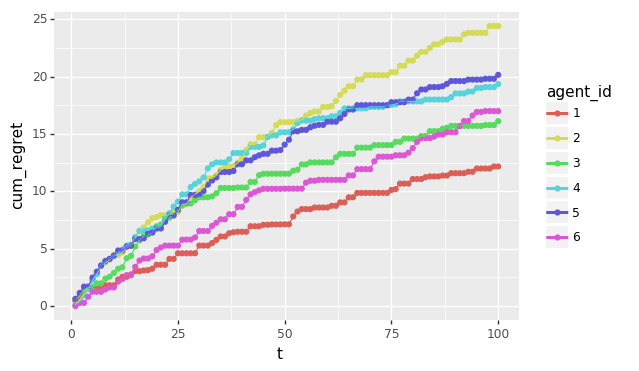

<ggplot: (8758061691469)>


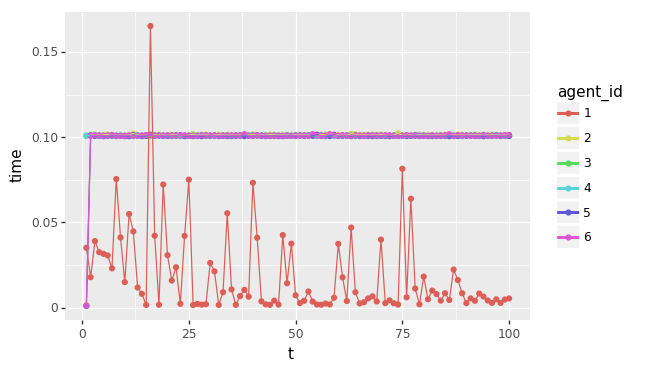

<ggplot: (8758152221045)>


([[     action_id agent_id  cum_optimal  cum_regret  instant_regret    t  \
   0            1        1     0.742786    0.436145        0.436145    1   
   1            2        2     0.742786    0.081921        0.081921    1   
   2            3        3     0.742786    0.620653        0.620653    1   
   3            4        4     0.742786    0.053520        0.053520    1   
   4            5        5     0.742786    0.620653        0.620653    1   
   5            6        6     0.742786    0.000000        0.000000    1   
   6            7        1     1.485572    0.707538        0.271392    2   
   7            8        2     1.485572    0.514328        0.432407    2   
   8            9        3     1.485572    0.892045        0.271392    2   
   9           10        4     1.485572    0.403958        0.350438    2   
   10          11        5     1.485572    1.140970        0.520317    2   
   11          12        6     1.485572    0.271392        0.271392    2   
   12       

In [11]:
make_agents = [make_laplace_agent,
               make_pgts_agent,
               make_best_langevin_agent,
               make_mala_agent,
               make_best_sgld_agent,
               make_best_sagald_agent]
simple_compares(make_agents, num_articles, dim, var, 100, [401], verbosity=verbosity)
#simple_compares(make_agents, num_articles, dim, var, n_steps, range(100,105), verbosity=verbosity)

theta [-0.03372101 -0.65004686  0.62638646 -0.29376141 -1.42712954 -4.02093759
  0.49524172 -0.17429181  0.7820283  -0.84114648  1.03002254 -0.7885069
  0.30089223  1.25795409  0.60495334  1.05945149  0.24894074 -1.13530602
 -1.03929954  1.10846518  2.147528  ]
Experiment: Step 0
 Laplace sample: array([ 1.46318253, -0.33671881, -0.22751445,  0.09060802, -0.30897207,
        0.67576367,  2.10318624,  0.34797607,  0.74233189,  0.12241951,
        1.35044032, -1.01922579, -1.21427724, -0.16105696,  1.30744929,
        1.53343539,  0.28015725,  1.22045668,  1.21912302, -0.53650744,
        0.92521129])
 Sample: array([-0.79215425, -0.31877915,  0.16052192,  0.29362659,  1.80205935,
       -0.4320382 ,  0.04417542,  0.9955036 ,  1.29200083, -0.03144891,
       -0.25818103,  2.4816049 , -1.48092755,  1.12976732,  0.63307733,
       -0.64174231,  0.74730539,  0.20430252,  0.35026308, -0.21545802,
        0.77950641])
 Sample: array([ 0.39802213, -1.2765237 , -0.64295511, -0.76386028, -0.8941

 Steps taken: 359
 Sample: array([-4.13181687, -1.49646046,  0.13247655,  0.09936209, -0.7780082 ,
        0.46736627,  0.32648607,  0.06431851,  0.46682681, -1.0178097 ,
        1.19382413, -0.1131462 , -0.63270051,  1.47117463,  0.08297074,
        1.61964315,  1.07981937, -0.87922001, -0.33697138,  0.8552635 ,
       -0.54292541])
 Sample: array([-1.75809042, -1.04139044,  0.55570461, -1.99873744,  1.01240981,
        2.40966729,  0.75023547,  0.77313096, -1.50437713,  0.52854039,
        1.52521507, -1.09431236,  0.76162672,  1.81674936, -0.1407906 ,
        0.75218193, -2.34063427, -1.40759073, -0.23863455,  0.82975914,
        2.41901325])
 Steps taken: 1311
 Sample: array([ 0.05099428,  0.35930126, -1.09812717,  0.32360309, -0.08464569,
       -0.6208644 ,  1.15687858, -0.37715433, -0.33356642,  0.43503374,
       -0.00621311,  0.43069536, -0.57098594,  0.38726945,  0.936343  ,
        1.27123344, -0.68125327,  0.05332323, -0.88030197, -0.16531706,
        1.34597272])
 Accept p

 Steps taken: 348
 Sample: array([-0.43797222, -1.07472525, -1.1692202 ,  0.49931544,  0.27988515,
       -0.76729647, -0.03250085, -0.92933712,  0.73693631,  1.01041608,
       -2.45596593, -0.10052424, -0.05458054,  1.21789011,  1.61955152,
        1.266228  , -0.92211983,  1.77253442, -0.74680436, -0.16052916,
        2.10625223])
 Sample: array([ 0.31924393, -1.24562463, -0.17960183,  1.03625393, -0.14591117,
       -0.7247136 , -0.0225746 , -0.37968119,  0.61896932,  0.19800713,
        0.00794385, -0.26374084, -0.06691999,  0.36776341,  0.80789901,
        0.41569076, -0.8920688 ,  0.27270171,  0.50883797, -0.26703836,
       -0.93456538])
 Steps taken: 1256
 Sample: array([ 1.01241333, -1.23634993,  0.21343937,  0.00172501,  0.22590169,
        0.14810009,  0.50640744,  1.05049123,  0.38888393,  0.31973756,
       -0.19775209,  0.70222605, -0.08780776,  0.92272803, -0.74742289,
        0.19478525, -0.07270814,  0.47295133, -0.37369043,  0.52067916,
        0.39593   ])
 Accept p

 Steps taken: 348
 Sample: array([-0.29092395,  0.71880861,  1.53527979, -0.53026074,  0.30966584,
       -0.73889606,  1.3488677 , -0.47217908,  0.13585634, -0.12496289,
        0.33177537,  0.39925456, -1.67661909,  1.24881225,  0.6326525 ,
        1.70412971,  0.50068472,  1.41782984, -1.00463342, -1.19678957,
        0.70980661])
 Sample: array([ 0.73903439, -1.0525884 ,  2.0220447 , -0.28509265,  0.71704602,
        0.93227949,  1.2042424 , -1.26156421,  0.35821325, -0.78251717,
        0.78282382, -0.8009274 ,  0.69981556,  0.08214028,  1.32596737,
        1.45423091,  1.09054637,  3.05279217,  0.69655679,  0.13966845,
        0.7325903 ])
 Steps taken: 1253
 Sample: array([ 0.50283724, -0.95159684, -0.35221714, -0.5736711 ,  0.19475522,
        0.06543691,  0.57095135, -0.30462927, -0.92391445, -1.24657621,
       -0.52345329, -0.740473  , -0.32488895,  0.33079647,  0.28412332,
       -0.86203023, -0.2955281 ,  1.12790595,  0.47973677,  0.91132528,
        0.14765847])
 Accept p

 Steps taken: 355
 Sample: array([-0.58681386, -0.70807931,  0.19607274,  0.06613083, -0.27658102,
       -0.01818628, -0.02983262,  2.05021936,  0.81986423, -0.6974168 ,
        1.6103186 ,  0.4486533 , -0.85861924,  1.42833917,  0.68780741,
       -0.84172711, -0.77519624,  0.85279543,  0.40550403,  0.14261046,
        1.92152134])
 Sample: array([ 0.45853242, -0.61110567, -1.07141597,  1.17428408, -0.44346351,
       -1.26736902, -0.99941939, -0.54005791,  1.50098804,  0.3608042 ,
        1.77812543,  1.7358908 , -0.36896908, -0.29124343,  0.9378046 ,
        0.45485451, -1.78513618,  0.54158732, -0.8588054 ,  0.052435  ,
        0.08109819])
 Steps taken: 1225
 Sample: array([ 1.56772703, -0.52166645,  0.26457432, -0.58454396, -0.07198505,
       -1.53932163, -0.67335912, -1.05738796,  0.00695346, -0.18605353,
       -0.63202194, -0.9179068 ,  0.74077754,  0.4560178 , -0.37924743,
        0.35872485, -0.43133043,  0.59308117, -0.3636313 ,  0.0223383 ,
       -0.10444086])
 Accept p

 Steps taken: 338
 Sample: array([ 0.89806576, -0.12839564,  0.89722666, -0.87892517,  1.22693253,
       -1.44239294, -0.72876731, -0.08621089, -1.58168457, -1.82171101,
       -0.99092482,  0.92672756,  1.23212016,  0.24025422, -1.47532436,
       -1.16941418, -1.09423855,  0.20203759, -0.63051452, -0.49582199,
        1.74455368])
 Sample: array([ 0.24616779, -1.03878345,  1.14360896,  1.32938222, -0.58535424,
        0.35078107,  1.0401362 , -0.31535344, -0.3670147 ,  0.90097986,
        0.98293917, -1.48423962,  0.09428358,  2.32877937,  0.47763013,
       -0.51063649, -0.65058556, -0.59913352,  0.71807171,  0.56426435,
       -0.91435287])
 Steps taken: 1195
 Sample: array([ 0.2548252 ,  0.17263989,  0.97918368, -0.96650783,  0.13704287,
       -0.69505973, -0.31619257,  0.50298735, -0.41325784, -0.7319802 ,
        0.39318905,  0.37796096, -0.02853851,  1.04002604, -1.01249794,
        0.52965904, -0.05933372,  0.06461381,  0.11216734,  0.9394128 ,
        0.37508755])
 Accept p

 Steps taken: 340
 Sample: array([-0.06920718, -0.35732861,  0.92836074,  0.58178961, -0.43248928,
        0.21247171,  0.12596842, -0.42417927, -0.61616648,  0.32623124,
       -1.39088785, -0.64622839, -0.63226434,  1.15745184,  0.75424546,
        0.14493163, -0.21058145, -1.35091155, -0.81477463, -0.88944974,
        1.91408781])
 Sample: array([-0.79788831,  0.30833086, -1.85558556,  0.64849344,  0.03946168,
       -2.9872891 ,  0.37150661, -1.65722921,  0.6702678 , -0.63096497,
       -0.26574806,  0.25855047,  0.88737329,  1.09936149, -0.09762468,
        0.77529171, -0.94883363,  0.90800839, -1.75209731, -0.22806516,
       -0.39497362])
 Steps taken: 1042
 Sample: array([ 0.90947069, -0.65799888,  0.51135005,  0.51186078,  0.0400781 ,
        0.07600488,  0.24473093, -0.12633258, -0.10496806,  0.18534071,
        0.74092363,  1.26391774, -0.88100267,  0.85884167, -0.29675775,
       -0.31455447,  1.40426665, -0.08034578,  0.3372207 ,  0.50456836,
        0.84989404])
 Accept p

 Steps taken: 317
 Sample: array([ 0.55723955, -1.07601365,  1.40308896, -0.11977024, -1.20950303,
       -1.08640845,  0.82106405, -1.19799241, -1.2730931 , -1.43814204,
        0.5031788 ,  0.0866936 , -0.10124032,  0.37665585, -0.24003363,
        0.61524503,  0.48399493,  0.17113932, -1.59097542, -1.72239885,
        1.96830769])
 Sample: array([ 0.42468679,  0.17476966, -0.82667636, -0.59025713,  1.89330614,
       -0.87712471, -1.54058965, -0.54077688,  0.26615881, -1.36289926,
       -0.09288655,  0.32070782,  0.01887328, -0.26577973, -0.5927431 ,
        0.01081654,  0.66011026, -0.13582586, -1.16266414,  0.52442199,
       -0.12893248])
 Steps taken: 1164
 Sample: array([ 0.79533243, -0.25460953,  0.77676162, -0.75238954, -0.42439926,
       -0.19714078, -0.20422795, -1.37538276,  0.04481892,  0.21019555,
       -0.48680768, -0.28642869, -0.44677515,  0.82741377,  0.50524338,
       -0.01311355, -0.99389136, -0.53626467, -0.47885807,  1.02210412,
        0.52823138])
 Accept p

 Steps taken: 313
 Sample: array([-0.20148116, -0.78159867,  0.27532084,  1.87182722,  0.04596431,
       -2.33801054, -0.74962543,  1.08401153, -0.82315693,  0.50604929,
        0.81092465, -1.56870537, -0.25978052,  1.30229524, -0.86933785,
        1.77735914, -1.31387953,  0.22874606, -1.82158562, -0.7404022 ,
        0.69906303])
 Sample: array([ 0.10707826, -0.79918587, -0.19421585, -0.3228276 , -1.09347911,
       -1.51068276,  2.0372578 , -1.59175213, -0.98656579, -0.96649372,
        1.73711656,  1.41618801, -0.42047566,  1.1037998 , -0.23179644,
        0.70716167, -1.5801674 , -0.45769111,  0.69465311,  0.490011  ,
       -0.05665553])
 Steps taken: 1068
 Sample: array([ 0.48050318,  0.00425167,  0.70594038, -0.08410048,  0.58882854,
       -0.76322246, -0.45711559,  0.64839313, -0.36548289,  0.44632753,
        0.18187227, -0.83902467, -0.38605516,  1.21515262,  0.95781095,
        0.25697694, -0.61393841, -0.54598193, -0.91653339, -0.0044364 ,
        0.1719211 ])
 Accept p

 Steps taken: 222
 Sample: array([ 3.62458409e-01, -2.72396252e-01, -7.91935382e-01, -1.51607616e+00,
       -1.19421228e-03, -4.30679367e-01, -9.43090067e-02,  7.03121434e-01,
        1.86999638e-01, -1.65679062e+00,  4.18510738e-02,  5.06517396e-01,
       -1.15794150e-01,  1.53594468e+00, -1.51816433e+00, -9.75916227e-01,
       -1.80282121e-01, -7.62542953e-01, -1.04991749e+00, -7.99277774e-01,
        1.73438555e+00])
 Sample: array([ 0.09232463, -0.54522965, -0.76336094,  0.78662925, -0.27922136,
        0.10216828, -0.19591741, -0.8151876 , -1.89149436, -0.58013196,
        0.44809822, -0.02205397,  0.92845352,  0.20950309,  1.374604  ,
        0.09707098, -0.06548673, -1.77200957, -0.00606039, -0.89920901,
        1.0864201 ])
 Steps taken: 1094
 Sample: array([ 0.06854063, -0.43838275, -0.30483599, -0.98646226, -0.45440085,
       -0.75733986,  0.14986544, -0.84140861,  0.07844797,  0.89235987,
       -0.14248132,  0.08966054, -0.41153229,  0.75402786, -0.38446337,
       -0.2

 Steps taken: 319
 Sample: array([ 1.4403543 , -0.86392097,  0.33702258, -0.31288084, -0.41138078,
       -2.46777129, -0.30723334, -0.19819126, -0.31544432, -0.9206899 ,
       -1.04240033,  0.77026066, -0.65231061,  0.3772274 , -0.46759568,
       -0.17652223,  0.98396253,  0.89344522, -2.68261408,  0.72470922,
        0.21233699])
 Sample: array([-0.54965055, -1.1572238 , -0.08634126,  2.00878594,  0.26595368,
       -1.12830534,  1.12546305,  0.01370677,  1.38646899, -1.72975074,
        0.23872029,  0.76367218, -1.48050148,  0.5043574 , -1.72265772,
        0.06688511, -0.44617793, -1.66779049, -0.54723265, -0.43551207,
        0.48374655])
 Steps taken: 1096
 Sample: array([ 0.16776459, -1.41405388,  0.2472658 , -1.74439775, -0.71062619,
        0.16235976,  1.25819888,  0.10758003,  0.22334218, -0.01976715,
       -0.7108677 ,  0.2773942 , -0.56224567,  0.89998421, -0.52066006,
        0.75319691, -0.43469361,  0.05129041,  0.36872272,  1.04395753,
        0.46741076])
 Accept p

 Steps taken: 316
 Sample: array([ 1.02545521,  0.80394948,  0.05365872, -1.61141665,  0.42417371,
       -1.98442002,  0.59252608, -2.20122076,  0.57623733, -1.14824819,
       -0.48875025, -0.32197765, -0.08198515,  1.52670992, -0.32016261,
        0.36836873, -0.43378096, -0.08482028, -1.31939657,  0.96682947,
        1.2100708 ])
 Sample: array([ 0.6169074 , -0.18037872, -0.70415176,  0.31553177, -1.26450118,
        0.35272804, -0.56952094, -1.70171864,  0.40817719, -0.5041474 ,
       -0.80208901, -0.80938613,  0.12083375, -0.38263268,  0.47005914,
       -0.66361488, -1.42955527, -0.23316988, -1.18592108,  0.62214066,
       -0.037119  ])
 Steps taken: 1067
 Sample: array([ 0.76598652, -0.71410047,  0.51056464, -0.34419433, -0.11003707,
       -0.87701191, -0.29204525, -0.9067557 ,  0.45499715,  0.45952718,
       -0.43004776,  0.03592841, -0.52374535,  1.16856781,  1.08535541,
       -0.06588693, -0.48892324,  0.107585  ,  0.408082  , -0.08643672,
        0.36886461])
 Accept p

 Steps taken: 310
 Sample: array([ 0.86925165,  0.24492353,  0.98804368, -0.10277029, -1.30914568,
       -2.40537442,  1.66689185, -1.08637261,  0.58987109, -1.03938281,
       -0.06410331, -0.25150053, -1.36501687,  1.13370109, -2.11219011,
        0.25408521,  1.79839258, -0.494022  , -1.5199084 , -0.7273952 ,
        1.87812819])
 Sample: array([-0.23787382, -0.81227195, -1.2777659 , -0.30990006,  0.28228052,
       -1.33333607, -1.19824628,  0.90582344,  2.23353151,  0.14754699,
        2.05273138, -0.80974488,  0.10926383,  1.18841274,  0.19123834,
        2.47924101, -0.15542737,  1.24380275, -0.31878985,  0.39200783,
        0.48799045])
 Steps taken: 1041
 Sample: array([ 0.3982729 , -1.81651699,  0.00522582, -1.40224132, -0.62765381,
       -0.83511872,  0.19319605,  0.41093877,  0.74121407, -0.33233016,
        0.14149389,  0.10586582, -0.59631759,  2.31128783, -0.27694149,
        1.95066775, -0.11615943, -0.44724572,  0.22147043,  0.30777245,
        0.55453047])
 Accept p

 Steps taken: 307
 Sample: array([ 0.15613729, -0.32055533, -0.75038708, -0.4455416 ,  1.06635622,
       -1.07110303,  1.15208643, -2.14601631, -1.39948969, -0.03981517,
        1.43322319,  1.7958214 ,  0.08146027,  1.52547843, -1.04681811,
        0.93584119,  0.08526613, -0.75613007, -1.6346453 , -0.6860721 ,
        1.70332461])
 Sample: array([-0.71166471,  0.12541725,  1.96299345, -0.58844654, -0.30773749,
       -0.55535582,  1.11685105, -0.60168395,  0.62064887,  0.87584547,
        1.7181021 ,  0.46142971,  1.13511627,  0.99132759,  1.00202538,
        0.25353125,  1.87064523, -0.16583762, -0.11565107, -1.04060568,
        1.3079459 ])
 Steps taken: 1032
 Sample: array([ 0.21840921, -0.59827717,  0.24802615, -1.51515151, -0.756179  ,
        0.03980467, -0.56489332, -0.17144958,  0.45551562, -0.39379029,
       -0.72179451, -0.58232597, -1.10636033,  1.35304621,  0.17186062,
        0.13699316, -0.70933156,  0.29029251,  0.50655691,  0.71027556,
        0.79484692])
 Accept p

 Steps taken: 310
 Sample: array([ 0.61669992, -0.23122368, -0.18650927, -0.18292939,  1.78484857,
       -2.45783966,  1.39526808, -1.37964702, -0.35702715,  0.27022569,
       -0.06233641,  0.9791948 ,  1.86980565,  1.45334264, -0.12249743,
       -0.32193967,  1.13451285, -0.71995714, -1.98206588, -0.57260292,
        1.34123362])
 Sample: array([-0.6221199 , -0.38473306,  0.78844124,  0.61841878,  0.63318756,
       -1.41186986, -0.04768353, -0.25636061,  1.47635069, -1.85845189,
        0.05800996,  0.07895398,  0.88130656,  2.14463317,  1.16839763,
        2.16746063, -0.40548754, -0.14223266, -1.1732979 , -0.12201234,
       -0.55747052])
 Steps taken: 987
 Sample: array([ 0.14512526, -0.62353356, -0.19316212, -0.71842808, -0.12183236,
       -1.23918589,  0.0789685 ,  0.68336486, -0.21773215,  0.44461861,
       -0.42058709,  0.20655898, -0.25118511,  1.39811633,  0.18600334,
        1.02543379,  0.04639905,  0.5119831 , -0.31229655,  0.78030955,
        0.71793211])
 Accept pr

 Steps taken: 307
 Sample: array([ 0.23440563, -0.47497953, -0.66406696, -0.75266386,  0.29337276,
       -0.27565788,  0.77992545, -2.44438904, -0.11411648, -0.19124863,
        0.04761946, -0.69841935,  0.0818657 ,  0.20711182, -0.4702438 ,
        0.47623414,  0.54284929, -0.30773732, -0.60037531,  0.22038404,
        1.87638692])
 Sample: array([-0.37175995, -0.29668006,  0.37233861,  0.73589515, -0.59225336,
       -0.46514008, -0.04524837, -1.13725067,  1.91475197, -1.68568042,
        1.00428017, -1.52496427, -1.01682804,  2.19968691,  0.2230465 ,
        1.40895144, -0.74021798, -0.27289892, -0.83812755, -0.65908746,
       -0.18852477])
 Steps taken: 972
 Sample: array([ 0.39117893, -1.51678581, -0.25048964, -0.94829234,  0.08540884,
       -0.6824318 , -0.07269731, -0.23761421, -0.85609149, -0.29302761,
       -0.02676275,  0.35327772, -0.95383139,  1.72575466, -0.80308754,
        0.4402005 , -0.19513152,  0.12037513, -0.32443606,  0.83119555,
        0.77631251])
 Accept pr

 Steps taken: 299
 Sample: array([ 0.41021236,  0.11827416, -0.77587135,  0.24841594, -1.16531713,
       -0.5717189 ,  1.36466729, -0.30449933,  0.63125522,  0.4817761 ,
       -1.17249489, -0.01715418,  0.04628769,  1.65413138, -1.32838444,
       -1.80764877, -0.85364869, -0.44977362, -0.77663781, -0.16396765,
        1.28602284])
 Sample: array([-0.00933625, -0.26994695,  1.35497382, -0.29812451, -1.19196656,
       -0.74911163,  0.34660093,  0.14918477, -0.13411255, -1.19968291,
       -0.07063115,  0.33426421, -0.75077068,  2.16250817, -0.9654891 ,
       -0.12096302, -0.59489264, -2.32070545, -0.68561309,  0.41525106,
        0.17826895])
 Steps taken: 973
 Sample: array([ 0.40547194,  0.58068831, -0.69047065, -0.93339475, -0.28480487,
       -1.13009261, -0.01326371,  0.4407044 , -0.32931156, -0.65421743,
       -0.17381323, -0.31002042, -1.11873687,  1.84494997, -1.14637796,
        0.05455871, -0.04108052,  0.38350685,  0.24672118,  0.07232485,
        1.13800164])
 Accept pr

 Steps taken: 208
 Sample: array([-0.10789951,  0.67583683,  0.27635331,  0.36124572, -1.90835892,
       -1.37599531,  0.98258342, -0.95913827,  0.62145671,  0.70354084,
       -0.8174971 ,  0.17136324,  0.96883308,  2.33661643, -0.75680096,
        0.17194746,  0.43544404, -1.1555316 , -0.18589233, -0.563217  ,
        1.90100489])
 Sample: array([ 0.42064447,  0.41683604,  0.61733088,  0.24893831, -1.78304547,
       -1.20821713,  0.78430527,  0.89991138,  0.7627411 , -0.75449582,
       -1.02175714, -1.249368  , -0.98671832,  2.29207537,  0.59020295,
        1.66099013,  1.12570686, -0.72254763, -0.65426105, -1.22916033,
        0.59686469])
 Steps taken: 655
 Sample: array([-0.20922333,  0.5986606 , -0.75371183,  0.7783189 ,  0.25013619,
       -0.43217403,  0.40038089,  0.27652481,  0.26472564,  0.22573784,
       -0.3338729 ,  0.49183033, -0.47363619,  1.78627452, -1.2429868 ,
        0.38455274, -0.72181958,  0.22218151, -0.30786126,  0.53051946,
        1.51485065])
 Accept pr

 Steps taken: 293
 Sample: array([ 0.52368908,  1.37354116, -0.47809626, -0.3424187 , -1.26385829,
       -0.71085708, -0.52752778, -1.11255806,  1.09501292, -0.65307137,
        0.63623405, -0.31991888, -0.89370731,  1.06063764, -1.64857929,
       -0.21733059,  0.03282832,  0.71895513, -0.29827054, -0.06905798,
        1.24485351])
 Sample: array([-0.26219968,  0.23437181, -0.16989297,  1.95534144, -0.1733679 ,
       -0.67392663, -1.22216745,  1.54300281, -0.09446218, -0.30399696,
       -0.79308897, -1.61882452,  0.95204308,  1.41585888, -2.08515705,
        1.35371627,  0.01578961, -0.38899093,  0.2634505 , -0.03802153,
        0.59495286])
 Steps taken: 921
 Sample: array([-0.12447613, -0.29704441, -0.03737106, -0.80527419, -0.69641281,
       -1.05038529,  0.00993496,  1.2646148 ,  0.28762702,  0.3631153 ,
        0.29750898,  0.43350938, -0.59979726,  1.60652981, -0.8046705 ,
        0.58298556, -0.21500876,  0.31489951, -0.74328211,  1.20794869,
        0.96533502])
 Accept pr

 Steps taken: 294
 Sample: array([ 0.3494315 , -0.44188748,  0.16450701, -0.53743319,  0.30228188,
       -1.13382201, -0.74264515, -0.13616916,  0.07447181, -0.27091636,
       -0.0363201 , -0.9709804 ,  0.24592808,  0.40425351, -1.73641158,
       -0.80830486, -0.01987033,  0.13359483, -1.61326073, -0.02917244,
        1.91213318])
 Sample: array([-0.59935291,  0.29250185,  1.30600868,  1.50663468, -0.90433622,
       -1.57345579,  1.28975998,  1.27965892,  1.10127984, -0.23722624,
       -0.79717289, -0.75790892, -0.50497774,  1.19956851, -0.85176144,
        0.48075072,  0.58182567, -0.28703992, -1.41273356,  0.6501396 ,
        1.93018722])
 Steps taken: 894
 Sample: array([ 0.22644599, -1.11800531,  0.07937336, -0.21427568, -0.6084462 ,
       -1.72665421, -1.49546295,  0.06880395,  0.12756461, -0.17937081,
        0.29585695,  0.1085694 , -1.11343453,  1.60379936, -0.55037881,
        0.5860628 ,  0.60418572,  0.00869371,  0.08619725,  1.31075141,
        0.87369869])
 Accept pr

 Steps taken: 288
 Sample: array([ 0.29193215,  0.04784194, -0.24539854, -0.30374477, -2.23528944,
       -2.03625954, -0.45979571,  0.05382272,  2.48751686,  0.41203942,
        0.16984627, -0.03856529,  1.66948707,  0.37993482, -0.72873368,
        0.04359585, -0.46890087, -1.44297179, -0.83138507, -0.87931557,
        2.98124816])
 Sample: array([ 0.41968605,  2.26519632, -0.03813707, -0.37033044, -0.32052813,
       -1.93570452,  0.14264366,  0.76462581,  1.55347789, -2.03858601,
       -0.11734154, -1.10580292,  0.1798386 ,  1.12990825, -0.92312425,
        1.79944788,  0.10197051, -1.94293107, -0.40324066, -0.08895207,
        0.43066115])
 Steps taken: 875
 Sample: array([ 0.15554155, -0.66774657, -0.12981898, -0.4208121 , -0.90586639,
       -1.38392834,  0.04288458,  0.44918385,  0.17253333, -0.80906584,
       -0.09178819,  0.90725537, -0.39018939,  1.70142404, -0.75556602,
        1.70466331,  0.04782747, -0.40411157,  0.2112564 ,  0.21438208,
        0.45876226])
 Accept pr

 Steps taken: 286
 Sample: array([ 0.75175868, -0.38938046, -0.2238074 , -0.25058516, -1.19600821,
       -0.60679722, -0.7499726 , -0.61234925,  0.02595668,  0.03731872,
        0.24494503,  0.76890837,  0.31679072, -0.27553391, -1.26649925,
       -0.60364569,  2.04419348, -1.99457917, -0.85187732,  0.0571095 ,
        1.48237062])
 Sample: array([-3.34485884e-01, -4.61458321e-01,  1.04264332e+00, -3.33647665e-01,
       -7.99542007e-01, -4.69286833e-01,  7.73802092e-01,  1.89162799e-02,
        2.91708484e+00, -1.98684388e+00, -1.07656616e+00, -9.10361632e-01,
       -2.18751820e-01,  7.11361612e-01, -1.12386760e+00,  3.76858400e-01,
       -7.65998273e-01, -1.15291665e-03, -9.75067432e-01,  1.50473399e-02,
       -2.08252567e-01])
 Steps taken: 866
 Sample: array([ 0.47105702, -0.74754209, -0.00844842, -0.3400468 , -0.87095982,
       -1.0898039 , -0.21690469,  0.12459358, -0.59967444, -0.28076916,
        0.86227581,  1.12114097, -0.03301618,  1.10855598, -0.48980494,
        0.80

 Steps taken: 286
 Sample: array([-0.12176797, -0.34573793,  0.80397797, -0.58129484, -0.56755623,
       -0.34654768,  0.99220758, -1.33251596, -0.2795993 , -0.23737497,
        0.10111588, -0.14272245,  0.37629926,  0.31952634,  0.46896985,
       -1.10728949,  0.35090546,  1.77581401, -1.49461528, -1.23190548,
        1.95393336])
 Sample: array([ 0.17277332, -0.31534515,  1.47878699,  0.58965665, -1.19911239,
       -1.01308235, -0.68105995,  0.15570152,  1.54082859, -0.5315812 ,
        0.15701226, -1.39644353, -0.57363129,  1.36336529, -0.50252285,
        0.73613023, -0.02897949,  0.96290465, -1.23802335,  0.8105672 ,
        0.46351259])
 Steps taken: 848
 Sample: array([-0.02465842, -0.72206966, -0.36080251, -1.31038103, -0.31129248,
       -1.78281984,  0.20664102, -0.0700938 ,  0.73809449, -0.17308139,
        0.12833655, -0.20085473, -0.45467866,  1.92200732, -0.36430578,
        0.18793972,  0.37214188,  0.15276988, -1.08423489,  0.63348192,
        1.22772444])
 Accept pr

 Steps taken: 286
 Sample: array([ 0.76167425,  0.18449268, -0.41122537, -0.08597571, -0.5393248 ,
       -1.90760842, -0.42441853, -1.0093081 , -0.53004592,  0.99406359,
       -1.34709235, -0.35997671, -0.01969703,  2.13007674, -0.1135986 ,
       -0.49386383,  1.22755434, -2.61738433, -0.65571737, -0.87384854,
        0.08324435])
 Sample: array([-0.16216116,  0.84047254,  0.72375934,  0.47253987, -0.06347497,
       -1.35022922,  1.39162452,  1.29234357,  1.91093935, -0.51902551,
       -0.20339552, -0.64641847, -0.26492672,  1.75972749, -1.34722255,
        0.46461512,  1.02154544,  0.00834404, -0.42878973,  0.06430697,
        0.1103883 ])
 Steps taken: 813
 Sample: array([-0.18721091, -0.73810599, -0.22653691, -1.56636628, -0.00669759,
       -0.35963622,  0.80711496,  0.84832426, -0.52793057, -0.16802355,
       -0.25640127, -0.24090806,  0.0786059 ,  0.91167621, -0.48104806,
       -0.86441764,  0.19887132,  0.79757436, -0.13760842,  0.84905973,
        1.42939641])
 Accept pr

 Steps taken: 280
 Sample: array([ 0.44639286, -0.30868759,  0.43368447, -1.16153083,  0.03949841,
       -3.22133406,  0.66017632, -0.23472962, -0.00398942,  0.48188354,
       -1.02150242, -1.3141129 ,  0.13401329,  0.88465282, -1.32214876,
        0.42395892, -0.63082702,  0.02729567, -0.97176259,  0.06827315,
        1.28486997])
 Sample: array([-0.04591748, -0.66364823,  0.69943879,  1.37930144, -1.04261763,
       -0.28032608,  0.03183805,  0.63679015,  1.10061694, -2.27486932,
       -1.27501656, -2.35503375, -0.37597543,  1.16275195, -0.30278125,
        1.03897753,  0.4634533 , -1.56398797,  0.12144872,  0.53706341,
        0.54688629])
 Steps taken: 802
 Sample: array([-0.03676352, -0.40111876,  0.77041971, -0.39117685, -0.85702216,
       -0.26102559, -0.05148725, -0.42929296, -0.11209288,  0.51261509,
        0.54435168,  0.01720238,  0.16612596,  1.19587395, -0.48582077,
        0.21847315, -0.14791704,  0.08735654, -0.8145524 ,  1.0387541 ,
        1.0903346 ])
 Accept pr

 Steps taken: 277
 Sample: array([ 0.72578883, -0.2292388 ,  0.25103156, -0.15024838, -1.91966179,
       -1.47314856,  1.34938854, -1.81716265, -0.16114966, -0.27038074,
       -1.51755604, -0.5196544 ,  1.37391801,  0.32910328, -1.35420569,
       -0.71170825,  0.06084171,  0.01740952, -1.7872995 , -0.47009488,
        0.8197416 ])
 Sample: array([ 0.2589727 , -0.56803767, -0.4736363 ,  0.66695777, -1.2568501 ,
       -1.8496624 ,  0.06420657,  1.47470193,  1.1999451 , -0.83494128,
        0.14453982, -1.12560996,  0.68261741,  0.19781165,  0.63603588,
        0.23160926,  1.10327992, -0.19142903,  0.01590862,  0.31764364,
        1.11806907])
 Steps taken: 779
 Sample: array([ 0.10456129, -1.04952805,  0.54352403, -0.28356969, -0.82169703,
       -1.87009562,  0.0315707 ,  0.00397509,  0.8081053 , -0.55698612,
        0.37294147, -0.37905583, -0.01667446,  1.30149235, -0.9133214 ,
        0.14922333, -0.39453874,  0.72345174, -1.38038802,  1.06388929,
        0.98343928])
 Accept pr

 Steps taken: 277
 Sample: array([ 0.17150135,  0.27712358,  0.37797414, -0.90441332, -1.35047526,
       -1.80080853,  2.42829536,  0.47378392,  0.65944797, -0.91660087,
       -0.70391699, -0.77274199,  1.62163757,  0.23807597, -1.3331511 ,
        0.7211275 ,  0.08108749, -0.17058988, -1.9805652 ,  0.29576728,
        1.41171732])
 Sample: array([-0.10001714, -0.08529395,  0.16367036,  0.48710898, -1.20179122,
       -1.63687421, -0.44178751,  1.8725319 ,  0.67971614, -1.11324948,
        0.03468221, -0.70575352,  1.35869902,  0.02973199,  0.14362177,
        0.71372388,  0.02742023, -0.77960953, -1.05340265,  0.13340035,
        0.9440662 ])
 Steps taken: 759
 Sample: array([-0.32986779, -1.09140113,  0.01311311, -0.81709525, -1.83590878,
       -1.30380485,  0.31579551,  0.35697512, -0.6634994 ,  0.10013545,
        0.62549702,  0.68866177, -0.46771843,  0.78213757, -0.63622257,
        0.5610883 , -0.38397537,  0.56142102,  0.18665404,  1.57398684,
        0.79069564])
 Accept pr

 Steps taken: 273
 Sample: array([ 1.35898995,  0.59683235,  0.11249701, -1.17487623, -1.38749873,
       -0.37050644,  0.66437225, -1.13576419, -0.21657786, -0.62797437,
       -0.63182783, -1.53278783, -1.35282298,  0.29517759, -0.71161012,
        0.17350904, -0.99950945, -0.54053286, -2.08743452, -0.02259354,
        1.1200187 ])
 Sample: array([-0.60795352, -1.77054706,  0.77686622,  0.225549  , -0.52003559,
       -2.11215809,  0.5984003 ,  1.39205349,  1.43503064,  0.00633162,
        0.54380038, -0.80753034,  0.70601347,  1.42069141,  0.35803339,
        1.37550569,  0.31245455, -0.5587223 ,  0.24765618,  1.08886556,
        0.98011706])
 Steps taken: 741
 Sample: array([-0.26452452, -1.23329582,  0.79640971, -0.9162076 , -0.72424725,
       -1.82645481, -0.2549634 ,  0.15889083, -0.79906588, -0.01962127,
        0.78244015,  0.85118049,  0.11918915,  1.4718254 , -1.0425226 ,
        0.51993316, -0.51679935,  0.78850847, -0.15637528,  1.06272867,
        0.98466687])
 Accept pr

 Steps taken: 271
 Sample: array([ 0.2949081 , -0.80333489, -0.79326957,  0.33410786, -0.74909332,
       -0.39625109,  1.75483917, -2.08571967,  0.07923747, -0.52265399,
       -0.37462752, -0.43028507,  0.49608778,  0.11634091, -0.86764937,
        0.15835066,  0.881319  , -0.14947852, -2.37704094, -0.44715081,
        0.88664273])
 Sample: array([ 0.26195134,  0.17689002,  0.04410729,  0.4643501 , -0.41849571,
       -1.71935483,  0.60455682,  0.50858357,  0.63482203, -0.23354765,
       -0.12445342, -0.80189477, -0.11220425,  0.4917448 , -0.49973315,
       -0.16623119,  1.37328363, -0.99165299, -0.3873106 ,  0.58796965,
        0.43449699])
 Steps taken: 665
 Sample: array([-0.17155147, -0.73245592,  0.36487012,  0.36185306, -1.31919463,
       -1.51641409,  0.29344783,  0.6262976 ,  0.95800981, -0.10216833,
        0.26018156,  0.82658317, -0.74018995,  1.18646986, -0.92820218,
        0.819126  ,  0.29684919,  0.44359137, -0.06777282,  0.8749753 ,
        0.97582572])
 Accept pr

 Steps taken: 273
 Sample: array([ 0.65451621, -0.38977912,  0.8701324 , -1.16884351, -1.41049993,
       -1.04053296, -0.07919874, -0.53719299,  0.40307848, -0.60913457,
       -0.14553242, -0.89194812,  1.03433098,  0.04262847, -0.45572975,
        0.33241524,  1.34657093, -1.11411877, -1.8559557 , -0.03048948,
        0.77477285])
 Sample: array([-0.18546624,  0.3972421 , -0.18443022,  0.09811399, -0.58770839,
       -1.63473567,  0.18100954,  1.45179204,  0.69911716, -1.96114169,
       -0.77859719,  0.31130028, -0.59684114,  0.96983757,  1.13230987,
        0.41793438,  0.78588771, -0.438768  , -0.96445794,  0.16659635,
        1.56599936])
 Steps taken: 662
 Sample: array([-0.04420379, -1.33746314,  0.42896031, -0.65599633, -0.94522703,
       -2.45015377,  0.1391283 ,  0.05572746,  0.34191405, -0.06277572,
        0.56823877,  0.65786939, -0.65729014,  1.41720422, -1.10281931,
       -0.15262787,  0.73575905,  0.22675744,  0.1503093 ,  0.83384201,
        0.74302628])
 Accept pr

 Steps taken: 271
 Sample: array([ 0.85934414, -0.26755978, -0.60581697, -0.08690476, -1.31511022,
       -1.1283472 ,  0.81811836, -1.28202899, -0.3604431 , -0.20881324,
        0.77003067, -0.29152452,  0.75572124,  0.13323174, -0.53577289,
       -0.27333729,  0.52392819, -1.73849283,  0.66867224, -0.69747751,
        0.55157518])
 Sample: array([ 0.24133537, -0.86701654, -0.33871903,  1.41044702, -0.19750596,
       -2.2798644 ,  0.81391007,  0.12475776,  2.34886575, -1.8096289 ,
       -0.22333406, -0.1248135 ,  0.38904997, -0.11088687, -0.84185605,
        1.5712288 ,  0.45764824, -1.28435606, -1.15358759, -0.37715773,
        0.37226672])
 Steps taken: 657
 Sample: array([-0.18239644, -1.11281568,  0.28348669, -0.60360038, -1.22510619,
       -1.26060269, -0.58749055,  0.47324945,  0.42466082, -0.00709495,
        0.22584152,  0.66815167, -0.85785245,  0.9309313 , -0.49245943,
        0.79315079,  0.86313381, -0.2496578 , -0.2400026 ,  1.20270235,
        0.83391486])
 Accept pr

 Steps taken: 269
 Sample: array([ 1.12645494, -0.09108555, -0.40552268, -0.69792899, -1.11056097,
       -0.35017837, -0.00603486, -2.24248103, -0.32191506, -0.83212719,
       -1.40271589,  0.06861558,  0.36799478,  0.03742279, -0.67056667,
        0.25822023,  0.48663109, -1.35964068,  0.82568877,  0.33924105,
        1.14744952])
 Sample: array([ 0.15203241, -1.05735886,  0.05694551,  0.94521184, -1.6613908 ,
       -1.46656206, -0.27247975,  0.24284787,  1.9559894 , -0.6617192 ,
        0.32396146, -1.13527658, -0.32514478,  0.21634148, -0.11990863,
        0.90273563,  1.04861222, -0.84620486, -0.95001581, -0.35983097,
       -0.75608128])
 Steps taken: 648
 Sample: array([-0.19564303, -0.8465087 ,  0.16450176, -0.84172606, -0.71832146,
       -1.27743884, -0.44882563,  0.37513004,  0.05557058, -0.13536017,
       -0.06448212,  0.00290333, -0.55612644,  1.68093062, -0.56401308,
       -0.14166687,  0.85684165,  0.26559994,  0.44254694,  1.21256835,
        0.947993  ])
 Accept pr

 Steps taken: 264
 Sample: array([ 0.27722707,  0.00784009, -0.32287707, -0.06564293, -1.53288203,
       -0.8465707 ,  1.03721208, -1.00203161,  0.99906176,  0.17453249,
       -0.45836938,  0.13680772,  0.29747464,  0.48834922, -0.32696978,
       -1.2368692 , -0.30164937, -1.310956  , -1.13288071,  0.15352103,
        0.9626903 ])
 Sample: array([-0.20510139, -0.85550782,  1.16507689,  0.97087495,  0.41153462,
       -1.566227  ,  1.16945062,  1.40169817,  2.91504571, -1.33640026,
       -1.14425754, -0.40604602,  0.17192258,  0.26055148, -2.86238319,
        0.30627155,  0.3996369 , -0.38487102, -0.62528463,  1.12404348,
        0.67172649])
 Steps taken: 635
 Sample: array([ 0.02889925, -1.15001387,  0.87206003, -1.15935391, -0.69305179,
       -1.50883957,  0.1630004 , -0.11837229,  0.66841651,  0.20673661,
        0.12861947,  0.23719707, -0.17079496,  0.9987839 , -0.54521584,
        0.83188407, -0.36664826, -0.0286586 , -0.66251273,  0.96269111,
        0.47626516])
 Accept pr

 Steps taken: 262
 Sample: array([ 0.64196409, -0.86953789, -0.74392915, -0.28580064, -1.2291848 ,
       -0.80699681,  0.96261655, -1.22371765,  0.28491376,  0.0189134 ,
       -0.4334553 , -1.68465006,  1.34346542, -0.04957378, -0.17217104,
       -0.59853628,  1.04807601, -0.81799762, -2.59340195,  0.37943249,
        1.2231784 ])
 Sample: array([ 0.43379984,  1.05411655,  0.07626288, -0.50224706, -0.14065587,
       -2.2031594 ,  0.00984363,  1.00325535,  1.38121115, -2.23641051,
        0.36371986, -0.2132818 , -0.87153629,  1.35486538,  0.03564383,
        0.7587968 ,  1.07973986, -0.97464688, -1.70453438,  0.20186607,
        1.16342144])
 Steps taken: 632
 Sample: array([-0.41153375, -1.21696612,  0.39141701, -0.79118806, -2.14734749,
       -1.91479721, -0.02731474,  0.82613332,  0.97426759, -0.03120537,
        0.44852912,  0.33309504,  0.22526575,  1.35404903, -0.67342531,
        0.68449107,  0.37247564,  0.20721215, -0.13224277,  0.99027701,
        1.08104447])
 Accept pr

 Steps taken: 259
 Sample: array([ 0.22833302, -0.66313582,  0.33100426,  0.07333932, -0.54589246,
       -1.34896423,  0.30071546, -1.28403064,  0.7464843 , -0.51971836,
       -1.16014869, -0.81474579,  0.55869475,  0.59589241, -0.32465277,
       -0.79118575,  0.30171902, -1.71827071, -0.60102081,  0.57663859,
        1.02098692])
 Sample: array([-0.43988214, -0.93094713,  0.95058954,  1.11172113, -0.78516231,
       -0.05818285,  1.36380083,  1.49232687,  1.53010201, -0.23169073,
       -0.11202557, -2.2788604 , -0.27506225,  0.27992822,  0.02673294,
        0.53124539, -0.71763518,  0.05570858, -1.01460922, -0.17150593,
        0.27625284])
 Steps taken: 624
 Sample: array([-0.29597679, -0.97903833,  0.56831643, -1.77950109, -1.01671336,
       -0.92268226, -0.01011735,  0.95169424,  0.719263  , -0.41657477,
       -0.27895821, -0.00274415, -0.08954074,  1.55247359, -0.49515207,
        0.35199784,  0.0684785 ,  0.08613031, -0.3930546 ,  1.39642404,
        1.15191448])
 Accept pr

 Steps taken: 255
 Sample: array([ 0.14889636,  1.04717734,  0.05253457,  1.69745078, -1.79857175,
       -2.73588734,  0.02388054, -1.50354452, -0.20082773,  0.61415815,
       -1.18359616, -1.50489699,  0.59792227,  0.65671087, -0.76724532,
        0.33903968,  0.23445294, -1.2776099 , -0.91374314,  1.19570667,
        1.23302748])
 Sample: array([ 0.4053924 , -0.54574779,  1.49010402,  0.21478402, -1.39007148,
       -2.57311973,  0.60864245,  0.6933142 ,  1.46985268, -1.10516813,
        0.25187203, -1.51293975,  0.11045765,  1.90531176, -1.29995475,
        1.92199252, -1.06641305, -0.5678274 , -0.60351104, -0.35190736,
       -0.12014268])
 Steps taken: 617
 Sample: array([-0.17916167, -1.17877018,  0.40931047, -0.69502511, -0.62604062,
       -1.64711657, -0.16677571,  0.66789362, -0.00805825,  0.14241702,
        0.55871671,  0.35073395, -1.30508379,  1.34543399, -0.61448216,
        0.5089115 ,  0.31808809, -0.20071901,  0.01933031,  1.19385574,
        0.97777008])
 Accept pr

 Steps taken: 255
 Sample: array([ 0.56407349,  0.18936038,  0.14124607,  0.19843138, -0.55090429,
       -1.55243115,  0.05427653, -2.52246155,  0.09217688, -0.02584596,
       -2.23194022, -2.2035226 ,  0.53307347,  0.22243363, -0.20550779,
        0.38576551,  2.09620314, -0.96842266, -1.5303684 ,  1.06798699,
        0.75331239])
 Sample: array([ 0.03874534, -1.98972047,  0.5060159 ,  0.36054642, -0.21085211,
       -2.92016279, -0.38131976,  0.23734698,  1.85656287, -0.49593559,
        1.23531762, -0.94406757,  0.31373142,  1.79850578, -0.8529605 ,
        0.65301094,  0.38606766, -1.22035807, -1.71307577,  0.52493004,
        0.80198681])
 Steps taken: 616
 Sample: array([ 0.08033684, -1.08012146,  0.43664841, -0.75239459, -0.34178829,
       -1.47090593, -0.31455082,  0.3560249 ,  0.52971004,  0.37957055,
       -0.09438814, -0.22900023, -0.37039951,  1.40684029, -0.87454576,
        0.46140665,  0.40983432, -0.06322063, -0.22142284,  1.64010663,
        0.8911736 ])
 Accept pr

 Steps taken: 253
 Sample: array([ 0.32040357,  0.10140724, -0.23256787,  0.16823107, -2.2441285 ,
       -2.33101098,  1.1878943 , -0.24853692,  1.29193228, -0.91372998,
       -0.18156394, -0.44643544,  0.60259196,  0.51631968, -0.05597748,
       -0.05346606,  0.09795313, -1.82838961, -1.5948045 ,  1.20397942,
        1.71846757])
 Sample: array([ 0.13051549, -0.40924871, -0.27253903, -0.5560076 , -2.26527295,
       -1.74384063,  1.55007591,  0.90977669,  1.82930785, -1.35061372,
        0.72668348, -0.51495711, -0.62588693,  1.46327383, -0.5347203 ,
        0.49011294, -0.87191764, -0.18146277, -2.64211704, -0.52237857,
        1.92719491])
 Steps taken: 602
 Sample: array([-0.22834317, -0.87516065,  0.88276086, -0.5695083 , -0.8206445 ,
       -1.75153574, -0.08763017,  0.96603174,  1.3916045 , -0.13276868,
        0.56384437,  0.15985857, -1.18793453,  1.24378816, -0.20988833,
        0.28005721, -0.20149473, -0.19769465, -0.06298078,  1.40052412,
        0.62431209])
 Accept pr

 Steps taken: 252
 Sample: array([ 0.2562659 ,  0.25811964,  0.23777044, -0.02889783, -1.61977321,
       -1.03205874,  0.71360718, -1.31798358,  0.89471118,  0.03602514,
       -0.70876286, -0.17145493,  0.51508052,  0.16855784,  0.03754678,
       -0.16190694,  0.56797091, -1.17249247, -1.69641481,  0.94313427,
        1.08032536])
 Sample: array([ 0.42399889,  0.22841742,  0.95796947, -0.28373724, -1.42153412,
       -1.49332564,  0.19836055,  1.69568917,  1.39342104, -1.93319741,
       -0.04917069, -1.08681751,  0.37641177,  1.36351877, -2.11200176,
        0.52920379,  0.34483726, -1.08137584,  0.02163151,  0.07624998,
        1.15490327])
 Steps taken: 598
 Sample: array([ 0.03784933, -1.20343717,  0.18747852, -1.24676216, -0.96195433,
       -1.1931665 ,  0.15832506,  0.06312618,  0.44947703, -0.00863903,
        0.31124337,  0.30523164, -0.48696828,  1.43871237, -0.98354342,
        0.51449434,  0.28667887, -0.35032317, -0.62269489,  1.95496569,
        0.98331438])
 Accept pr

 Steps taken: 250
 Sample: array([ 0.7787778 , -1.06134271, -0.19726488, -0.65452368,  0.59022236,
       -1.42593568,  0.87518488, -2.06458389,  0.30224035, -0.42367979,
       -1.08902378, -1.28375118,  0.40990339,  0.07511641,  0.33882981,
       -0.13541492,  0.11084944, -2.32656476, -0.5378147 ,  0.95796612,
        1.16574386])
 Sample: array([-0.16937288, -0.52453939, -0.64380945,  0.18790303, -0.59836895,
       -1.91403105, -0.03858915,  0.43932463,  1.67919142, -1.99564872,
        0.85552598, -1.5150867 , -0.45594859,  1.55601124, -0.04663762,
        0.04489006,  0.84229766, -0.44003696, -0.18561172,  0.6286782 ,
        0.56483902])
 Steps taken: 593
 Sample: array([-0.21903902, -1.64215324,  0.44332405, -1.13632855, -1.26911201,
       -0.94708068,  0.21962981, -0.01912579,  0.44439617, -0.00736047,
        0.60410915, -0.23187054, -0.53177345,  1.34921027, -1.36276575,
        0.45865219,  0.55353118,  0.02288   , -0.80963838,  1.18182834,
        1.02869202])
 Accept pr

 Steps taken: 248
 Sample: array([ 0.1732471 , -0.47447642, -0.07081143, -0.01076324, -0.42851113,
       -2.33299805,  0.28575873, -0.95842647,  1.24280831, -0.84246127,
       -0.25730202, -1.09426842,  0.19406472,  1.61270105, -1.1051892 ,
       -0.26870951,  0.46800221, -1.32043011, -1.87839363,  1.05088495,
        0.83972861])
 Sample: array([ 0.19710285, -1.21563003,  1.42826575,  0.11543206, -0.84943621,
       -2.27359536, -0.36201709,  1.33265377,  1.57969378, -1.42426549,
        0.7663537 , -1.01309598,  0.60410204,  0.93332048, -1.0128162 ,
        1.27033119, -0.1343084 , -0.35402558, -0.99221062, -0.70533356,
        1.26170713])
 Steps taken: 580
 Sample: array([-0.19646815, -0.99203432,  0.3390335 , -0.99225537, -0.58308004,
       -1.36967996,  0.16750188,  0.10386182, -0.67442967, -0.46765888,
        0.20964472,  0.07333787, -0.63421104,  1.58841419, -0.44261279,
        0.25682623,  0.72232022, -0.47726287, -0.8050586 ,  1.27467195,
        1.17379944])
 Accept pr

 Steps taken: 245
 Sample: array([-0.14596275, -0.26969912,  0.45291894,  0.58053941, -1.61153417,
       -1.45360423,  0.72015078, -0.58889678,  0.7048183 , -0.07836001,
        0.36686186, -1.20129026,  1.02367478,  0.35541181, -1.07315957,
       -0.94061666,  1.09376379, -0.85655436, -0.79828878,  1.25055981,
        1.663599  ])
 Sample: array([-8.14739762e-02, -2.62297668e-01,  4.70003005e-01, -2.05922332e-04,
       -6.84212943e-01, -9.69891596e-01,  4.11900461e-01,  4.99709293e-01,
        1.60166760e+00, -1.58614585e+00,  2.00866361e-01, -1.35047175e+00,
       -9.30392997e-01,  4.75570431e-01, -1.21914668e+00,  6.26836173e-01,
        4.73285569e-01, -4.73854115e-01, -8.26144973e-01,  1.46110465e+00,
        1.95717814e+00])
 Steps taken: 574
 Sample: array([-0.30144461, -0.82011595,  0.28499979, -1.85843159, -0.81460623,
       -1.2897063 , -0.10762956, -0.30213037, -0.39168485, -0.42407285,
        0.95606759, -0.24252258, -0.5706781 ,  1.39966398, -0.74203274,
        0.99

 Steps taken: 253
 Sample: array([ 0.67571138,  0.29109592, -0.25994142,  0.58500837, -0.40722962,
       -2.10060406, -0.19674049, -1.2017389 ,  1.16116529, -1.48323283,
       -1.32531495, -0.87868926,  1.69102231,  0.85529238, -0.06035618,
       -0.18952925,  0.2987606 , -1.94385914, -1.17897784,  0.27413341,
        0.65467245])
 Sample: array([-0.37507945,  0.84788986,  0.51553108, -0.31592032, -0.08410806,
       -2.85668531,  0.51004618,  0.44316777,  1.81470127, -1.24004366,
        0.67692281,  0.20687316,  0.37788551,  1.18188027, -0.84711917,
        1.13441223,  0.70816721, -0.81644047, -0.17028331,  0.42080817,
        1.48451218])
 Steps taken: 594
 Sample: array([-0.25154127, -0.3930663 ,  0.87013872, -1.45715904, -0.56991976,
       -0.96712735, -0.53655813,  0.84818078,  0.03896923, -0.28520106,
        0.4015176 ,  0.60774149, -0.34569346,  0.99228623, -0.65949623,
        0.23469221,  0.05405381,  0.11930263, -1.256771  ,  1.54785729,
        1.10803719])
 Accept pr

 Steps taken: 253
 Sample: array([ 0.27422145, -0.53559073,  0.67336431, -0.92273331, -1.53711653,
       -1.41843391,  0.30164169, -0.56004846,  0.76427823, -0.71892908,
       -0.36913035, -1.89022971,  1.10054673,  0.72730051,  0.6092172 ,
       -0.33760266,  1.17425273, -0.42859067, -1.12107577,  0.49221332,
        1.42239404])
 Sample: array([-0.09462272, -0.87840959,  0.53706618,  0.28835084, -1.78103817,
       -1.34963222, -0.12952741,  0.22345862,  1.19547102, -2.19224558,
        1.19737338, -0.11869052,  0.16061691,  0.70360544, -1.49153282,
        0.88943548,  0.80180631, -0.15952633, -1.50290183,  0.97179473,
       -0.01869012])
 Steps taken: 584
 Sample: array([-0.35825856, -1.20826079,  0.73471452, -1.11953309, -1.93242391,
       -0.84889053,  0.58950981, -0.36883215,  0.14396556, -0.8042667 ,
        0.69340797, -0.05665932,  0.29683753,  1.22013708, -0.983196  ,
        1.05720773,  0.2282249 , -0.45960352, -0.66942697,  1.16315902,
        1.6058493 ])
 Accept pr

 Steps taken: 252
 Sample: array([ 0.52119289, -1.10971664, -0.43384968, -0.27853287, -1.62134022,
       -1.97548683,  0.18908467, -0.60275254,  0.67578591,  0.06171068,
        0.21094231, -1.489698  ,  0.83285921,  0.45764069, -0.0572849 ,
        0.30671062,  0.4944597 , -1.33925655, -2.8078004 ,  1.25741432,
        1.57130017])
 Sample: array([-0.07278498,  0.21965584,  0.9485705 , -0.37906634,  0.39782779,
       -0.03041995,  1.80334147,  0.45083201,  0.98269902, -0.97007421,
        0.01197197, -0.42316921, -0.07531278,  1.59129193, -0.74169545,
        0.01454604,  0.28504354, -2.29117171, -0.45144162, -0.21299764,
        1.24983206])
 Steps taken: 583
 Sample: array([-0.21190926, -1.41254487,  0.31757817, -0.99867253, -1.71425592,
       -0.51997883,  0.37739387, -0.06109544, -0.19166606, -0.43286529,
        0.84325128,  0.05269054, -0.50374054,  1.3371874 , -0.76190415,
        1.00080127, -0.60413395,  0.26882566, -0.69957788,  0.94927362,
        1.1701511 ])
 Accept pr

 Steps taken: 252
 Sample: array([ 0.15578255, -0.56740509,  0.78675889,  0.31290178, -1.3518195 ,
       -1.32025621,  0.20470493, -1.21696358, -0.295967  ,  1.32500905,
        0.22970094, -0.26011799,  0.80379055,  0.22620742, -1.03103812,
        0.35981563,  0.39421665,  0.0112117 , -2.73596868,  0.82239213,
        1.78187662])
 Sample: array([-0.045378  , -0.66104597,  0.85619903,  0.19612166, -0.86320548,
       -2.79630597, -0.28412007,  0.25969568,  1.19648362, -2.04788256,
        1.51652747, -0.38625511, -1.26209054,  0.93725123, -0.18158945,
        1.93405494, -0.34832522, -0.39869422, -0.81734968,  0.21105665,
        1.01690931])
 Steps taken: 574
 Sample: array([-0.26989945, -1.35272272,  0.81947739, -1.3049133 , -1.01550882,
       -1.71556437,  0.11793585, -0.02224293,  0.18354593, -0.26830304,
        0.83722652,  0.40035268, -0.93544503,  1.48279624, -0.72109374,
        0.50354539, -0.06248612,  0.47859132, -0.90197861,  1.26975016,
        1.24832326])
 Accept pr

 Steps taken: 239
 Sample: array([-0.24190348,  1.2290019 ,  0.35586745, -0.37646233, -1.56368913,
       -1.163033  ,  1.00029501, -1.32335409,  0.68507941,  0.68043811,
        0.30386453, -0.74409465, -0.13140885,  0.29329484,  0.39637895,
        0.44594104,  1.21844861, -1.59176947, -0.53096317,  0.65637825,
        1.73673953])
 Sample: array([-0.04667988,  0.07937464, -0.05185176, -0.24601255, -1.55223184,
       -2.32800025, -0.66850381,  0.47476919,  2.11098349, -1.69461447,
        0.64192015, -0.450979  , -0.15817579,  1.34183699,  1.12394236,
        0.98314084,  1.32655506, -1.66847683, -0.31591762,  1.09426198,
        0.58144885])
 Steps taken: 557
 Sample: array([-0.06345085, -1.17965095,  0.72443976, -0.75469708, -0.91303953,
       -1.51116589,  0.40904123, -0.28663234, -0.27770954, -0.84863867,
        0.42699673,  0.1474243 , -0.57411691,  0.94585863, -1.50269753,
        0.42795878, -0.23815697, -0.07718834, -0.20444933,  1.13387648,
        1.06468461])
 Accept pr

 Steps taken: 237
 Sample: array([ 0.43305281,  0.17345974,  0.54189935, -0.10830443, -1.43380499,
       -0.64146824, -0.04019282, -0.87788471,  0.01575662,  0.37035029,
       -0.41624577, -1.06511625,  0.37281443,  1.14177904, -1.34028569,
       -1.09607483, -1.03158125, -1.96560827, -1.51547625,  0.88513636,
        0.7500223 ])
 Sample: array([-0.27355723,  0.12736137, -0.19925053, -0.24493684, -1.37195018,
       -2.40735566,  1.23144693,  0.99670427,  0.71572927, -1.4898301 ,
       -0.11862971, -0.60176466,  0.04418593,  1.18795164,  0.3721795 ,
        1.26507277,  0.04830986, -0.30622764, -0.016169  ,  0.0971893 ,
        1.11675937])
 Steps taken: 548
 Sample: array([-0.15559453, -1.57324275,  0.24480111, -1.25630551, -0.02710283,
       -1.39095388,  0.3203658 ,  0.51398219,  0.48795171, -0.45544155,
        0.1435856 ,  0.10889327, -1.23252882,  1.53973464, -0.04485731,
        0.65039166, -0.41735772, -0.0109153 , -0.77541824,  0.93953343,
        1.19164595])
 Accept pr

 Steps taken: 234
 Sample: array([ 0.65004825, -1.03664972, -0.32758941, -0.21841657, -0.82097915,
       -2.00682137,  0.41603719,  0.15614806,  0.69936522, -0.65393035,
       -1.7152847 , -0.29977885,  0.5898088 ,  1.0931786 , -1.89811404,
       -0.27556253, -0.43249539, -0.77515044, -1.68870903,  0.06352733,
        0.78603756])
 Sample: array([-0.12842527, -0.87462206, -0.0389308 , -0.78228174, -1.32859178,
       -1.74157655,  0.36228819,  1.60150401,  1.53778982, -1.93994775,
        0.93020556, -1.18876326,  0.1496592 ,  1.28949557,  0.14060703,
        1.02398466,  0.58921607, -0.44292723, -0.08422856,  0.46359282,
        1.06877617])
 Steps taken: 546
 Sample: array([-0.15962278, -1.03417294,  0.54615719, -1.25575028, -0.43881515,
       -0.9898691 , -0.06637392,  0.04477025, -0.40286698, -0.97096308,
        0.39597636,  0.50370137,  0.35773574,  1.19961667, -0.1434113 ,
        1.19406827,  0.51137421, -0.40883235, -0.32547319,  1.04223965,
        0.88046116])
 Accept pr

 Steps taken: 233
 Sample: array([ 0.02830431,  0.43058196,  0.67129083, -0.28146765,  0.13755731,
       -0.72642518,  0.64014445, -1.04111617,  0.56439667, -0.06979391,
       -1.28437658, -0.22039024,  0.65435194,  0.03675445,  0.35988347,
        0.87993604,  0.51600555, -0.64241401, -1.46156014,  0.90940107,
        1.51144771])
 Sample: array([-0.41931807,  0.52734905,  0.87553562,  1.12223389, -0.75903882,
       -1.92471473,  0.56444936,  0.51915852,  1.63115424, -1.7060414 ,
        0.45733426, -1.06176693, -0.10820048,  1.47379547, -0.58307196,
        1.22117936, -0.8449393 , -0.39821477,  0.223089  ,  0.89279037,
        1.12645857])
 Steps taken: 536
 Sample: array([-0.15091139, -1.20255731,  0.58345299, -0.36348241, -0.43773052,
       -1.76893381, -0.1999226 , -0.06916442, -0.46319058, -0.55311689,
        0.45344521,  0.20411343, -0.37805573,  1.25686441, -0.50007798,
        0.73050242, -0.59000717,  0.11477958, -0.83292141,  1.18933849,
        1.19960717])
 Accept pr

 Steps taken: 232
 Sample: array([ 0.33696706,  0.16904329,  0.22056898, -0.11144494, -1.52580723,
       -1.63849942,  0.62397703,  0.25832405,  0.69198983, -0.41582773,
       -1.64147184,  0.10928165, -0.19768416,  0.51540573,  0.26889926,
        0.85852503,  0.3580367 , -0.31048235, -2.11954393,  0.5511425 ,
        1.2891781 ])
 Sample: array([ 0.42265384, -0.40341546,  0.84971878, -0.0992464 , -1.06329812,
       -1.60576269,  0.61141102,  0.45690968,  0.82916144, -1.53280863,
        0.44461747, -0.06041922, -0.26849882,  1.29181049, -1.35552677,
       -0.16356177,  0.70288469,  0.11227905,  0.06278791, -0.55416002,
        0.67535106])
 Steps taken: 532
 Sample: array([-0.4321961 , -1.63033598,  0.28667568, -1.38428074, -0.25841526,
       -1.29074746, -0.2430297 ,  0.32800317, -0.09981717, -0.52783661,
        0.48655009,  0.36939579, -0.03187505,  1.31992639, -0.6078329 ,
        0.99366501, -0.32638237,  0.05664615, -0.56512617,  1.21753442,
        1.58984118])
 Accept pr

 Steps taken: 230
 Sample: array([-1.04590759e-01,  9.86903417e-01,  1.57328934e+00,  3.60087999e-02,
       -4.27571569e-01, -9.98496991e-01,  3.34546763e-02, -7.49972406e-01,
        3.33520836e-01, -3.66277116e-01,  1.11122591e+00, -5.77297718e-02,
        8.30489335e-04,  1.34867664e+00,  6.57002151e-02,  3.20916077e-01,
       -1.51625231e-01, -2.61813273e+00, -1.74252214e+00,  7.27560876e-01,
        2.05964684e+00])
 Sample: array([ 0.31796464, -0.51573547, -0.6210021 ,  0.53768363, -1.10861917,
       -1.35461075, -0.35743595,  0.67037277,  0.49062365, -0.98211192,
        0.71413544, -0.02466016, -0.37354566,  0.25659603, -0.6008551 ,
        0.66644828,  0.88224658, -0.67278709, -1.49648255,  1.42014556,
        0.9299649 ])
 Steps taken: 526
 Sample: array([-0.14115757, -0.8080505 ,  0.41972832, -1.22707611, -0.62188408,
       -1.21962632,  0.30546935,  0.16592872,  0.14381543, -0.26321904,
        0.19519459,  0.04908448, -0.33245314,  1.53877997, -1.05558132,
        0.53

 Steps taken: 229
 Sample: array([ 0.3207961 ,  0.21511039,  0.57436313, -0.39694478, -0.11069691,
       -1.62040489,  0.95367859, -0.87925156, -0.28008203,  0.50230448,
       -0.63602477, -0.4089537 ,  1.29953911,  0.37938354, -0.79431389,
        1.01543602, -0.36870348,  0.09612465, -2.91902411,  1.10857971,
        0.72047201])
 Sample: array([-0.08222436, -1.57673905, -0.38772585, -0.1389695 ,  0.71787331,
       -2.58305332, -0.12709422,  1.05776079,  0.49758067, -1.06626982,
        0.89681038, -1.25471808,  0.10777709,  1.14200917, -0.81885753,
        1.66239482, -0.04415954,  0.42722458,  0.55048253,  1.61249421,
        1.12384791])
 Steps taken: 517
 Sample: array([-0.45228007, -1.34592384,  0.86412212, -0.65919939, -0.13886041,
       -0.95146737, -0.51765293,  0.22504064,  0.37247181, -0.51007579,
        0.01665364,  0.0495618 ,  0.12878917,  1.27000496, -1.05442708,
        1.03718823, -0.42998288, -0.3665975 , -1.11350714,  1.28626554,
        1.16000059])
 Accept pr

 Steps taken: 226
 Sample: array([-2.48456809e-01,  2.74341619e-01,  6.99199478e-01, -1.84522568e-02,
       -1.77909156e+00, -1.82003324e+00,  4.49110194e-01, -1.14047337e+00,
        8.19171094e-01,  7.10590802e-01, -7.86814016e-01, -1.44477426e-03,
        1.48748872e-01,  9.66648081e-01, -9.63944996e-02,  7.02913489e-01,
        7.59802132e-01, -6.46662637e-01, -1.31236175e+00,  1.15309755e+00,
        2.24624809e+00])
 Sample: array([-0.1118309 , -1.64361713,  0.98888692,  0.07189743, -0.94151394,
       -2.90104442,  1.84041757,  0.4096652 ,  1.24272664, -1.32821929,
        0.96049965, -0.77567933,  0.72236366,  1.1441651 ,  0.37336533,
        2.13728689,  0.38912761, -0.14287938, -0.41277165, -0.04352275,
        0.77618082])
 Steps taken: 431
 Sample: array([ 0.06050392, -1.06440214,  0.4684252 , -1.60427041, -1.31460662,
       -1.69182581,  0.75107554,  0.40336871,  0.39142541, -0.68234429,
        0.06373065, -0.34423349, -0.81468059,  1.4392876 , -1.09876611,
        0.43

 Steps taken: 227
 Sample: array([ 0.19308466, -0.24296425,  0.04478302, -0.16890458, -0.97854958,
       -2.28396644,  0.17005647,  0.06475558, -0.11061357, -0.52161464,
       -0.72083575,  0.40754203,  1.06041064,  1.30655684, -0.56467649,
        0.73993229,  0.69793495, -0.88433385, -1.78017895,  0.95604188,
        1.33602868])
 Sample: array([ 0.28714749, -0.69682279,  0.12840635, -0.06132455, -0.60596329,
       -0.9907188 ,  0.45057962,  0.84759251,  0.10606484, -0.9704077 ,
        0.88975271, -0.40090469, -0.43151748,  0.69558353,  0.28044818,
        0.58845855, -0.61175411, -0.48817917, -0.04011699,  0.60802301,
        0.33152779])
 Steps taken: 509
 Sample: array([-0.3329674 , -1.92617005,  0.6225721 , -1.68752252, -1.10665758,
       -2.69089995,  0.11699418,  0.39803116, -0.11790669, -0.24885209,
        0.42352864,  0.70789957, -0.18102948,  1.81988945, -0.67725431,
        0.77887459,  0.04687138, -0.17835348, -0.53633181,  1.21345658,
        0.98335555])
 Accept pr

 Steps taken: 223
 Sample: array([ 0.21369978,  0.7843452 ,  0.71221159,  0.19738787, -2.24839479,
       -0.85878005, -0.29034976, -0.84154605,  0.78242375,  0.58521898,
        0.15059173, -0.27791626,  0.49270669,  0.59971125, -0.0069158 ,
        0.8097655 , -0.41959062, -0.05852401, -2.58694751,  1.29501059,
        0.97865462])
 Sample: array([-0.42984537, -0.3136995 ,  0.05426074, -0.39335557, -0.18446704,
       -1.76354562,  0.32443575,  0.70587989,  1.07705193, -0.90955426,
        0.53628928, -0.50012448, -0.72269051,  1.35404704,  0.98459866,
        1.49883574,  1.02669217, -0.53430942, -0.69146642,  0.55812614,
        0.74525249])
 Steps taken: 503
 Sample: array([ 0.23307099, -2.23367141,  0.48869967, -1.40529087, -0.66913208,
       -1.15989466,  0.35232213, -0.14877519,  0.05220422, -0.9486619 ,
       -0.14551778, -0.00704546, -1.01177864,  1.07196055, -1.10916052,
        0.54163571,  0.06996581,  0.16316534,  0.13329085,  1.14480597,
        1.10038478])
 Accept pr

 Steps taken: 223
 Sample: array([ 0.39272761,  0.85682843,  0.41063875, -0.37943466, -0.72253231,
       -1.52085924, -0.19835056, -0.07057368, -0.1779092 ,  0.05388452,
        0.49647147, -0.48266105,  0.07623357,  0.96192051, -0.64662879,
       -0.09280701, -0.32240603, -0.5866671 , -2.39623294, -0.02730482,
        1.43188779])
 Sample: array([ 1.62623369e-03, -1.57513272e+00,  7.40760308e-01, -3.47134954e-02,
        1.03909916e+00, -1.38982958e+00, -9.95837344e-02,  4.46666125e-01,
        1.08559939e+00, -1.38031124e+00,  3.57126637e-01,  7.58509942e-02,
        2.90573129e-01,  7.03308306e-01, -1.02746080e-01,  6.10192341e-01,
        4.49787069e-01, -1.18399501e-01, -1.98063811e+00,  5.55726168e-01,
        3.17920677e-01])
 Steps taken: 492
 Sample: array([-0.26290659, -0.65204732,  0.57289622, -1.71275343, -0.35862426,
       -1.64864867,  0.33622887, -0.37285051,  0.17278974, -0.00963172,
        0.32834365,  0.18356941, -0.78354193,  1.66402716, -0.9602157 ,
        1.37

 Steps taken: 225
 Sample: array([ 0.19465886,  1.12040551,  0.69282902, -0.86853748, -1.04946849,
       -2.03858326,  1.14667413, -1.34879078,  0.00428734, -1.52169788,
        0.12322666,  0.30617576,  0.0964129 ,  0.08443687, -0.43517293,
        0.93321235,  0.37012572, -0.80300165, -2.56514094,  0.241388  ,
        1.3277724 ])
 Sample: array([ 0.01407438, -0.48951379,  0.93265422, -0.78178583, -1.72114375,
       -1.68715222,  0.69457958,  1.16512325,  0.98474474, -0.61900234,
        0.56500697, -1.40303051, -0.22886575,  1.01434089,  0.19559129,
        0.82806163, -0.82945693, -0.81443917, -0.93400383, -0.45055102,
        1.63910998])
 Steps taken: 497
 Sample: array([-0.47737923, -0.14392629,  0.77175693, -1.95533898, -0.78861792,
       -1.22632109,  0.42804858,  0.21586816, -0.10613941, -0.41292409,
        0.07319308,  0.46717783, -0.63745565,  1.9510093 , -1.90902737,
        0.93299969, -0.9483009 , -0.13348213, -0.78361916,  1.36498756,
        1.18250239])
 Accept pr

 Steps taken: 221
 Sample: array([ 0.94431829, -0.59734215,  0.34969832, -0.18391197, -0.23013918,
       -1.21783646, -0.08985561, -0.37942103, -0.05779566, -0.43026069,
       -0.62364938, -1.77280207, -0.63232668,  1.0887355 , -0.52770152,
        0.28113796, -0.98258981, -1.41172438, -2.54615953,  0.59222004,
        0.70130411])
 Sample: array([ 0.14682423, -0.33668816,  0.9389685 ,  0.01273742, -0.9476663 ,
       -0.78828487,  0.91642513, -0.01213574,  0.89997313, -0.57630433,
       -0.00918671, -1.05271115, -0.11809831,  0.85003105, -0.59964653,
        0.81554835,  0.19820691, -0.80284127, -0.03692866,  0.0142226 ,
        0.79912642])
 Steps taken: 482
 Sample: array([-0.04018666, -1.72706359,  0.64338307, -1.19124553, -0.96249625,
       -1.93629891,  0.11992814, -0.55421317, -0.73275557, -0.25958122,
        0.62668159,  0.17756873, -0.70477579,  1.22790151, -0.50494329,
        1.43896726,  0.14879493, -0.22513914, -0.62434443,  0.9859022 ,
        1.19852522])
 Accept pr

 Steps taken: 218
 Sample: array([ 0.16461959,  0.83851664,  0.27518902, -0.99558511, -1.87442628,
       -0.62724878,  0.7548875 , -0.13200679, -0.01894386, -0.14430968,
        0.17274067,  0.31117762,  0.5857057 ,  0.24947577,  0.32907473,
       -0.1205708 ,  0.75356535,  0.20601504, -1.79357777,  0.62350983,
        1.94646015])
 Sample: array([ 0.19769539, -1.02703696,  0.12447229, -0.34580655, -0.49301216,
       -1.19782803,  0.78319443,  1.0888127 ,  1.02216229, -1.19808805,
        0.96917799, -0.80381466, -0.71699819,  1.60459968, -0.28562691,
        0.99789048,  0.01202441, -0.45931402, -0.52871631, -0.0688728 ,
        0.04253744])
 Steps taken: 481
 Sample: array([-0.15326148, -1.00472408,  0.61288676, -1.52154764, -1.17872687,
       -1.03661572,  0.6381603 ,  0.24941957,  0.28015782, -0.37498258,
        0.49443686,  0.17155993, -0.3630377 ,  1.31014598, -1.0286162 ,
        0.69039251, -0.45761215, -0.49160684, -0.47246069,  1.05594603,
        0.97716169])
 Accept pr

 Steps taken: 216
 Sample: array([ 0.43539294,  0.6803212 ,  0.69750144, -0.76930757, -1.73354503,
       -2.15731441,  0.51192921, -0.05864105,  0.64176344, -0.22187894,
       -0.14329554, -1.37850153,  0.159604  , -0.11993785, -1.07630798,
        0.84379744,  0.61588204, -0.55342561, -2.82384377,  1.64061613,
        1.08574572])
 Sample: array([ 0.12628067, -0.32891751,  1.48889199, -0.34101901, -1.05980622,
       -1.52191018,  0.81717705,  0.81068588,  1.24561424,  1.13895813,
        0.55741642, -0.90191054, -0.60762979,  1.26964154, -1.07306099,
        1.11551102, -0.27392276, -0.37054154, -1.30865917, -0.52786143,
        0.85719479])
 Steps taken: 477
 Sample: array([-3.62050765e-01, -1.61126832e+00,  9.01869150e-01, -1.11822604e+00,
       -7.02039304e-01, -2.04018111e+00, -5.64482578e-02,  1.00165245e-01,
        2.39382397e-01, -3.94378135e-01,  7.93638211e-01, -8.51315962e-02,
       -3.32737662e-02,  1.44013845e+00, -8.76548500e-01,  9.76776904e-01,
       -1.22557279e

 Steps taken: 215
 Sample: array([ 0.64211447,  0.76080972,  1.02668547, -0.67368371, -1.34761348,
       -2.00881987,  0.44363321,  0.3519835 ,  0.18850253,  0.46379326,
        0.53456291, -0.89387324,  0.36302156,  0.08991362,  0.09869839,
        0.35139972,  0.4018828 , -1.24006971, -2.62445872,  0.60578499,
        0.60815956])
 Sample: array([ 0.06475365,  0.07535323,  0.96569705, -0.7064158 , -1.58534003,
       -1.71612136,  0.603831  ,  0.36261795,  1.36347602, -0.48166922,
        1.14096571, -1.0111205 , -0.2080745 ,  1.46868332, -0.41966577,
        1.30884767,  0.31826083, -1.27281838, -0.11927309,  0.47491388,
        0.93678957])
 Steps taken: 470
 Sample: array([ 0.03702304, -2.24652634,  0.44104149, -1.53430499, -0.76910263,
       -0.6480268 , -0.46219797,  0.14158817, -0.41308062, -0.3426759 ,
        0.24875171,  0.09028282, -0.00260097,  1.18110173, -1.1354279 ,
        1.51812689, -0.06959635, -0.40859947, -1.51801691,  0.85575258,
        1.1804733 ])
 Accept pr

 Steps taken: 215
 Sample: array([ 0.35877126,  0.12493835,  0.13267746, -0.66937244, -1.82001807,
       -1.49848423,  0.61190691, -0.60160568,  0.08768178, -0.97518012,
        0.38485789, -0.52519616,  1.42477797,  0.04114339,  0.79029625,
        1.40409556,  0.40249404, -0.3989527 , -1.22055907, -0.46728283,
        1.10500207])
 Sample: array([ 0.2580446 , -0.32327053,  0.95333992, -0.77923879, -0.93407035,
       -1.54518156,  0.86973744,  0.95650152,  0.43061451, -1.27552161,
        0.72618836,  0.14871829, -0.86823327,  1.70088641, -0.65554487,
        0.9150185 , -0.50169011, -0.76039865, -1.1513446 ,  0.46687113,
        1.65032807])
 Steps taken: 464
 Sample: array([-0.21342774, -0.13366899,  0.51941854, -1.12560113, -1.16817824,
       -1.6625516 ,  0.03618227,  0.02469967, -0.35574378, -0.42396179,
        0.42295599,  0.38257302, -0.09307933,  1.39846832, -0.73028871,
        1.20187277, -0.30161648, -0.04155395, -1.32208776,  0.87675504,
        1.66764255])
 Accept pr

 Steps taken: 213
 Sample: array([ 0.06010521, -0.29797365, -0.19968229, -0.49928325, -1.86659149,
       -1.46757868,  0.87126963, -0.35244545,  0.09610996, -0.69643026,
        0.61180446, -0.97600523,  0.56201146,  1.01908765,  0.36515087,
        1.3713872 ,  0.13699353, -1.71934205, -0.64121238,  0.88939053,
        1.75364566])
 Sample: array([-0.16932772, -0.33495235,  0.73357567, -0.24411202, -1.75504982,
       -1.71735847,  0.7744304 ,  1.2676254 ,  1.3885076 , -1.40555738,
        0.22910917, -0.28386117, -0.42075133,  1.81008986, -0.14762442,
        0.82656089, -0.95257735, -0.81481962, -0.97522897, -0.56491399,
        1.84427407])
 Steps taken: 459
 Sample: array([-0.34905469, -1.27510811,  0.59931246, -1.75660887, -0.58803072,
       -1.44975006,  0.37974568,  0.40280534, -0.38412324, -0.1203261 ,
        0.09638843, -0.05534304, -0.32221332,  1.70539652, -0.40612257,
        1.08543927, -0.06910569, -0.19344212, -0.9366333 ,  0.79408679,
        1.42735752])
 Accept pr

 Steps taken: 212
 Sample: array([ 0.16649907, -0.10260885,  0.8149678 , -1.2423467 , -0.31779416,
       -1.7661306 ,  0.55882788, -0.15267948, -0.2037472 , -0.10740666,
        0.32010215, -0.01477978,  0.79377004,  0.49498622, -1.04231198,
        1.3471154 ,  0.93611476,  0.5116756 , -1.33353296,  0.53617681,
        1.27367662])
 Sample: array([ 0.32698692, -0.50805819,  0.17566197, -0.96636426, -0.13157178,
       -2.87416892,  0.56758036,  0.41782102,  0.54391596, -0.71449545,
        0.33753532, -1.43244842,  0.50751567,  0.58011546,  0.21418681,
        1.09008106,  0.34511112, -0.47232835, -1.54489258,  0.04990398,
        0.95438573])
 Steps taken: 451
 Sample: array([-0.10851935, -1.14135943,  0.37520484, -1.50024818, -0.72818546,
       -0.77028572,  0.07391261,  0.42021348, -0.37082829, -0.16688941,
        0.39046778, -0.04485009, -0.31609439,  1.42542365, -0.75664626,
        0.8032466 , -0.002172  , -0.63606288, -0.1022787 ,  0.85005254,
        1.23791487])
 Accept pr

 Steps taken: 210
 Sample: array([ 0.26708788,  0.89740832,  0.57584363, -0.20665198, -0.67127861,
       -1.28515259,  1.57624235, -0.02534264,  0.53968519, -0.84331442,
       -0.53178159, -0.42929131,  0.64496302,  0.46521907,  0.04200191,
        0.75734132,  0.38275101, -0.97239337, -2.08545969,  0.22012319,
        1.30758523])
 Sample: array([ 0.71654724, -0.56818   ,  0.70569335, -0.35103153, -1.13444909,
       -2.16050397,  0.37006055,  0.88060748,  0.77314673,  0.32917707,
        0.93674091, -0.641791  , -0.13564528,  1.15519637, -0.24229597,
        1.14352541,  0.16644814, -0.46838612, -1.78939388, -0.95610249,
        1.08333522])
 Steps taken: 446
 Sample: array([-0.172525  , -1.1926396 ,  0.73444294, -2.02864323, -0.21939877,
       -0.95756648,  0.33341345,  0.05612613,  0.11025894,  0.08881019,
       -0.19952882, -0.39575008, -0.39289541,  1.84425739, -0.80489829,
        0.81179701,  0.05217199, -0.23076397, -0.78090978,  0.58815373,
        1.21946169])
 Accept pr

 Steps taken: 209
 Sample: array([ 0.7742563 ,  0.22638361, -0.14214708, -1.11818235, -1.02144202,
       -1.43735491,  0.69886124,  0.01636297, -0.89195975, -0.30045565,
        0.13162711, -0.93409292,  0.09837839,  0.39375398, -0.44532826,
       -0.75288142,  0.70094326, -0.3800701 , -1.43158401,  0.33089044,
        1.02820121])
 Sample: array([ 0.10103253, -0.82513377,  0.04271713, -0.50096079, -0.4879782 ,
       -1.87835279,  0.15431137,  0.33440532,  0.48610431, -0.25705035,
        1.07644221, -1.08561724, -0.19435484,  1.40540476, -1.63914947,
        1.28705133, -0.1273369 , -1.3935797 ,  0.9437509 ,  0.29679874,
        1.28012802])
 Steps taken: 441
 Sample: array([-0.06995367, -0.52955197,  0.69555626, -1.66727968, -0.81530567,
       -1.09288753,  0.21554271, -0.12212937, -0.75042495, -0.50474984,
        0.53495949, -0.29714709, -0.93604887,  1.05949628, -1.24269678,
        0.85755266, -0.17038713,  0.24454944, -0.2815029 ,  0.79596222,
        1.46784806])
 Accept pr

 Steps taken: 207
 Sample: array([ 0.52080633,  0.61898407,  0.78680113, -0.12330673, -1.81339196,
       -2.15911655, -0.19723317,  0.46208274, -0.23035747,  0.07715992,
        0.40573369, -1.14025016, -0.4039446 ,  0.9987696 , -0.18145623,
       -0.07895303,  0.92194877, -1.65113376, -3.02237109,  0.67328682,
        1.34578406])
 Sample: array([ 0.33416232,  0.28227368, -0.05824881,  0.40843992, -0.22699784,
       -1.58458244,  0.70411285,  0.20163881,  0.18704382, -0.05464016,
        0.81793432, -1.28719835, -0.92268534,  1.0165743 ,  0.14585772,
        0.9302735 , -1.22876951, -0.82505628, -0.53111435,  0.12873557,
        0.94987761])
 Steps taken: 438
 Sample: array([-0.28325529, -1.93266066,  0.74590378, -1.36888941, -1.03665042,
       -1.50976716,  0.31002717,  0.37328915,  0.17600013, -0.80136436,
        0.23524026,  0.46675968, -0.34884395,  1.50357871, -0.41707576,
        0.89799429,  0.05876731, -0.02962036, -0.47650331,  0.76187227,
        1.6083057 ])
 Accept pr

 Steps taken: 206
 Sample: array([ 3.02540876e-01, -9.61582396e-01,  3.42515150e-01, -7.40871077e-01,
       -1.49586931e+00, -1.16644965e+00,  9.94286788e-01,  3.65187333e-01,
        3.66764330e-01, -4.18724480e-01,  3.47659782e-01, -6.45159706e-01,
       -4.21061204e-02,  4.34594019e-01, -4.13944102e-01,  2.36863179e-01,
        4.35204555e-01, -8.21548378e-01, -1.63524118e+00,  5.91003427e-06,
        1.06284434e+00])
 Sample: array([ 0.08750965, -0.63897277,  0.50263032,  0.35959354, -0.75919266,
       -0.96910128,  1.08856023,  0.67076466,  1.40702893,  0.16629935,
        0.58761141, -0.21729315,  0.10362127,  1.32595352, -0.55843657,
        0.44319995, -1.8197317 , -0.53172067, -1.85281465, -0.08581002,
        1.10136218])
 Steps taken: 434
 Sample: array([-0.11388177, -1.76595624,  0.88032395, -1.67076275, -1.11121551,
       -1.1534866 ,  0.25951372,  0.17514112, -0.24515816, -0.23058836,
       -0.00338375,  0.40579193, -0.9509255 ,  1.5121601 , -0.80841041,
        0.93

 Steps taken: 205
 Sample: array([ 0.30513538,  0.3167376 ,  0.60694539, -1.44132516, -0.66040344,
       -0.95289443,  0.56381169, -0.33110011, -0.24517704,  0.49410751,
       -1.08318935, -0.8521895 ,  0.16914557, -0.13825491,  0.86194921,
        0.75548061,  0.03584099, -0.57161667, -1.24801078,  1.05442958,
        1.42105506])
 Sample: array([ 0.22980771, -0.84694325, -0.2044048 , -0.15644734, -0.73198094,
       -2.91277591,  0.32454029, -0.19238405,  1.22803729, -0.54718247,
        0.63260044, -0.50551111, -0.95043862,  1.16786145, -0.44037687,
        1.09617453,  0.41654049, -1.0526328 ,  0.16823467, -0.18219376,
        1.29206817])
 Steps taken: 429
 Sample: array([-0.10023362, -1.7614759 ,  0.74936815, -1.68506313, -0.5408375 ,
       -1.03781217,  0.36954322, -0.04390201, -0.34099419, -0.16288089,
        0.07455555,  0.07911365, -0.61676142,  1.43383916, -1.0897599 ,
        0.94315188, -0.21919005, -0.21451182, -0.57224359,  0.7512225 ,
        1.86655405])
 Accept pr

 Steps taken: 203
 Sample: array([ 0.25611137,  0.71768259,  0.96934264, -0.12476717, -1.25234377,
       -1.32939594,  0.65729701, -0.32813239, -0.80776509, -0.6538089 ,
        1.37471164, -0.49980625,  0.39877423, -0.01806813, -0.91862024,
        1.17664573,  0.12269803, -1.80963036, -1.6198341 ,  0.80681311,
        1.15060168])
 Sample: array([ 0.25904219, -1.5457131 ,  0.11440768, -0.40258642,  0.20160654,
       -0.89400069,  0.37834861,  0.40099984, -0.29208028, -1.21351696,
        0.64849129, -0.59118636,  1.07942275, -0.21711433, -0.72797361,
        1.40151312,  0.38665047, -1.06777614, -1.01933005, -0.66087718,
        1.72800421])
 Steps taken: 424
 Sample: array([-0.18433609, -0.88065665,  0.60292114, -1.55930249, -1.17093598,
       -1.00322511,  0.36093079,  0.47352168, -0.49279917, -0.6634201 ,
        0.54672996, -0.37049098, -0.45032038,  1.5407682 , -1.11796572,
        1.45832035,  0.21197549, -0.26052201, -1.33020678,  1.03362596,
        1.58416744])
 Accept pr

 Steps taken: 203
 Sample: array([-0.12317752,  1.18832393, -0.20451014, -0.44142231, -2.32397382,
       -0.91850007,  0.98357832, -0.38865798,  0.45158611,  0.89046463,
       -0.00247292, -0.52731469,  0.56452189,  1.09645987,  0.6943378 ,
        1.16273382,  0.92660587, -0.56394944, -0.65066491,  0.27387673,
        2.11546619])
 Sample: array([ 0.76226633,  1.13314336,  0.02310396,  0.38012431, -0.27964734,
       -2.06490142,  0.06163006,  0.88077909,  0.04034804, -1.51761465,
        1.24072984, -1.17153125, -0.27554137,  1.10093794, -0.93871518,
        0.70726132,  0.23450588, -0.34040734, -1.32322012,  0.31721332,
        1.40606661])
 Steps taken: 426
 Sample: array([-0.03947273, -1.13990059,  0.26639042, -1.42200189, -0.95180052,
       -1.38524239,  0.49908545,  0.19925309, -0.57308289, -0.63078643,
        0.39034233, -0.42175587, -0.41935372,  1.37938058, -1.56328423,
        1.36140062,  0.54305228, -0.42201923, -0.48584611,  0.76166595,
        1.54075568])
 Accept pr

 Steps taken: 201
 Sample: array([ 0.23124847, -0.05845085,  0.92595727, -0.86642456, -0.90729312,
       -1.18806982,  0.48768769, -0.13474688,  0.54772544,  0.17073824,
       -1.00307924, -0.69077721,  0.48357378,  0.58934728, -0.26814843,
        0.62467724,  0.97533773, -1.50302714, -2.60503923,  1.21232481,
        1.24664838])
 Sample: array([ 0.05940129, -0.85299343,  0.91621044, -0.72843301, -0.40458193,
       -2.60184724,  1.00876006,  1.03741821,  1.21465493,  1.03528421,
       -0.05318389, -0.41665047, -0.1764576 ,  1.78908376, -0.69299813,
        1.53373426,  0.28952668, -0.04743198,  0.03382026, -0.78976902,
        0.30598157])
 Steps taken: 424
 Sample: array([-0.24906032, -0.93730241,  0.70767818, -1.50094861, -0.17498427,
       -1.18847764,  0.25155279, -0.27479367, -0.22727856,  0.13541452,
        0.37972355,  0.25984902, -0.16616974,  1.68180263, -0.86634731,
        1.2769363 ,  0.13841128, -0.50427298, -0.94864963,  0.9686336 ,
        1.69227143])
 Accept pr

 Steps taken: 199
 Sample: array([ 0.06488494,  1.52239227,  0.56753189, -0.58793599, -0.85173813,
       -1.3981353 ,  1.03793058,  0.07331267,  0.61735227,  0.58085674,
        0.3476344 ,  0.9465885 ,  0.97121909,  0.98339978, -0.64523345,
        0.07368524,  0.86229511,  0.75196254, -2.00006834,  0.65492484,
        1.76205647])
 Sample: array([-0.06700705, -0.21449191,  1.00909313, -0.64876468,  0.63060942,
       -2.47873471,  0.2358687 ,  0.99173967,  0.85232269, -1.44159109,
        0.55051004, -0.81350936,  0.44979127,  1.36053962, -0.54953957,
        1.32781596,  0.50682108, -0.27127899, -0.06441023,  0.59710777,
        1.34647716])
 Steps taken: 415
 Sample: array([-0.2225083 , -0.93073745,  0.27104979, -1.58525792, -0.54797244,
       -0.90242437,  0.26004943,  0.02698672, -0.44507993, -0.39351493,
        0.56449978,  0.37057868, -0.27266185,  1.61626865, -1.27092433,
        1.56764249,  0.34305285, -0.21437889, -0.37572814,  0.84305244,
        1.95594436])
 Accept pr

 Steps taken: 199
 Sample: array([ 0.48525945, -0.21877021,  0.06299677, -0.89326144, -1.74136581,
       -1.22378402,  0.62944305, -0.46795699, -0.51058331, -0.81677988,
       -0.60130261, -0.64287293,  0.59551717,  0.3279408 ,  0.18392513,
       -0.19153954, -0.14989479, -1.09504256, -1.19735935,  1.23800997,
        1.09011074])
 Sample: array([-0.64691232, -0.27848305,  0.59319318,  0.21426701, -0.38276776,
       -1.93812363,  0.63430917,  1.07215725,  1.40370046, -0.32821759,
        0.70507667, -0.10983864,  0.85960249,  1.20215811,  0.13704541,
        1.37960908,  0.17857773, -0.579447  , -1.92480053,  0.72821561,
        1.85989063])
 Steps taken: 411
 Sample: array([-0.2243067 , -0.82295571,  0.66817301, -1.86515532, -1.17764378,
       -1.1974928 ,  0.59255008, -0.40752935, -0.237794  , -0.93966179,
        0.55480511, -0.29080344, -0.15712791,  1.8905592 , -0.85527299,
        1.17814248,  0.12338796,  0.07073163, -1.19643706,  1.29110117,
        1.75262632])
 Accept pr

 Steps taken: 198
 Sample: array([-0.27127241,  0.50582925,  0.07309773, -0.40871529, -2.05294224,
       -1.68906531,  1.58590166,  0.33922355,  0.40345461,  0.81773543,
        1.38927785, -0.08903152,  0.67373345,  0.09286407,  0.211384  ,
        0.00877714,  0.49539589, -1.76461716, -1.89153152,  1.34070904,
        1.78513398])
 Sample: array([ 3.62411141e-01, -1.04365290e+00, -2.07678418e-01, -1.50110833e-01,
       -2.98885657e-01, -2.08290054e+00,  6.47718872e-02,  3.09901381e-01,
        7.13511555e-02, -7.73502709e-01,  1.11603730e+00,  1.97716724e-01,
       -1.10850085e+00,  2.95709779e-01, -5.28645527e-01,  1.07221895e+00,
       -5.11438354e-02, -1.61980677e-03, -1.64200676e+00, -1.14777614e-01,
        1.48314406e+00])
 Steps taken: 406
 Sample: array([-0.01400442, -1.16555418,  0.30556346, -1.51288504, -0.86099266,
       -1.48630106,  0.27435864, -0.06116743,  0.15869021, -0.2750227 ,
        0.1035788 ,  0.01348782, -0.04980453,  1.32442646, -1.02966274,
        1.05

 Steps taken: 135
 Sample: array([ 0.1697796 ,  0.63819647,  0.54956333, -0.78804857, -0.80426227,
       -1.13353268,  0.54625323, -0.3633971 ,  0.3648058 ,  0.69843942,
        0.65461719, -1.49899997,  0.43996463,  0.35026333, -0.26210944,
        0.86250771,  0.18957957, -0.95983981, -1.3451782 ,  0.68488571,
        1.63701653])
 Sample: array([ 0.27368748, -1.07498053,  0.19551464, -0.71626112, -1.47005497,
       -1.45205864,  0.68194772,  0.31090907,  0.6950621 , -0.05614988,
        0.11099166, -0.80816257,  0.30350663,  1.00816319, -0.74029285,
        0.68263414,  0.92118884, -0.95915697, -0.85724373, -0.7870338 ,
        1.3938879 ])
 Steps taken: 391
 Sample: array([-0.11187306, -1.65380709,  0.40113142, -1.16431085, -1.61803409,
       -1.19578782,  0.04142051,  0.01590728, -0.80518022, -1.18198268,
        0.73682869, -0.30017578, -0.33633892,  1.76477499, -1.25598676,
        1.08560885, -0.44566341, -0.10868333, -0.42069802,  1.0666541 ,
        1.49530347])
 Accept pr

 Steps taken: 196
 Sample: array([ 0.44009   ,  0.07496241,  1.05595311, -1.32822123, -1.3227268 ,
       -0.97583259,  0.46043274, -0.36191795, -0.49310098, -1.13141892,
       -0.61994816, -0.90497429, -0.05462551,  0.60936975,  0.12763104,
        1.51500859,  0.77835265, -1.70919638, -0.30087772,  0.45317379,
        1.97321876])
 Sample: array([-0.16406026, -0.10133487,  1.84317011, -0.39083184, -0.0575264 ,
       -2.74079713,  0.21343099,  0.76874925,  0.56022915,  0.4098207 ,
        1.23625786, -0.81040495,  0.19132451,  1.93836186, -0.05919291,
        1.13445309, -0.94722884, -1.12181638, -1.48070648, -0.29630826,
        2.04359808])
 Steps taken: 396
 Sample: array([ 0.0634763 , -1.0005491 ,  0.7825986 , -1.53632095, -0.90365645,
       -1.33359927, -0.31604253, -0.10671228,  0.07208039, -0.66468195,
        0.7662888 , -0.20961215, -0.65122467,  1.51090392, -0.87555912,
        0.97191619,  0.13171111, -0.57966873, -0.77463904,  0.67340955,
        1.49123272])
 Accept pr

 Steps taken: 196
 Sample: array([-0.31663511, -0.06767096,  1.51820952, -0.95689649, -1.83917571,
       -1.92314845,  0.73513341,  0.57876059,  0.94249199,  0.04697027,
        1.1331528 ,  0.45374685,  0.73013551,  1.06290526,  0.45360486,
        1.416892  ,  0.85635219, -0.90718758, -2.73299294,  1.00457485,
        1.99002014])
 Sample: array([-0.07576106, -0.71335574,  1.17009816, -1.06008055, -0.10360488,
       -1.76170557,  0.34275121,  0.68949337,  1.0378357 , -0.19923523,
        1.29047491,  0.36793725, -0.75506298,  0.71507135, -1.23908063,
        1.63681643, -0.95835915, -1.2442245 , -1.37276258,  0.98660999,
        1.09735423])
 Steps taken: 391
 Sample: array([-0.15431054, -1.13546401,  0.73384977, -2.17878204, -1.10614895,
       -1.91449187,  1.10670186,  0.0698547 ,  0.05342645, -0.21467396,
        0.52838469,  0.02520911, -0.8189539 ,  1.82451148, -1.16010863,
        1.73935918, -0.33289508, -0.25186043, -1.25504265,  0.7327685 ,
        1.98221457])
 Accept pr

 Steps taken: 194
 Sample: array([ 0.03135665, -0.66917986,  1.18520595, -0.93100462, -2.28623411,
       -1.88766303,  0.34761992, -0.37791307,  0.71335362,  1.39203109,
        0.91749404, -0.26941807,  0.63024446,  0.44540817,  0.86632446,
        0.51179405,  0.20750877, -0.46413476, -1.88880241,  0.41784742,
        1.66514135])
 Sample: array([-0.13916844, -1.56691937,  1.22312949, -0.40080625,  0.346288  ,
       -1.38910206,  0.49741416,  0.83715288,  1.24813438, -0.66883089,
        0.76243995, -0.6492039 , -0.05497882,  0.9356787 , -0.52375804,
        0.8262352 , -0.72955565,  0.14547923, -1.23541249, -0.13044018,
        1.68272302])
 Steps taken: 372
 Sample: array([-0.03114217, -1.16115098,  0.51130066, -1.42770478, -0.64243929,
       -0.89394639,  0.59467317, -0.13555591,  0.03359028,  0.00741926,
        1.10749597, -0.13849906, -0.24092738,  1.33745073, -1.33595105,
        1.38975714, -0.18827697, -0.75333675, -0.52666611,  0.79073   ,
        1.39229605])
 Accept pr

 Steps taken: 192
 Sample: array([ 0.43050574, -0.35746005,  0.107639  , -1.0843299 , -3.13812871,
       -1.82017635,  0.39137992, -0.13275487,  0.93788285, -0.74409016,
        0.88972399, -0.35801842, -0.31418227,  1.17833389, -0.12550971,
        1.12578521,  0.48169516,  0.11845474, -0.20604405,  0.12772864,
        1.67237713])
 Sample: array([ 0.67248682, -0.91768569,  0.48903941, -0.86180354, -0.41071606,
       -0.77303393, -0.13696175, -0.19392637,  0.44645876, -1.57741038,
        0.20893292, -0.75858224,  0.22138806,  0.72079035, -1.54002135,
        1.19685093,  0.95615913, -1.2387134 , -0.67848687, -0.15888494,
        2.00754046])
 Steps taken: 380
 Sample: array([-0.10196845, -0.44108014,  0.56621697, -1.97146997, -1.04318253,
       -1.29433817,  0.16915888, -0.08662379,  0.22915329, -0.07695319,
        0.60615405, -0.03573256, -0.16920641,  1.30454153, -1.21047529,
        1.28336811, -0.1442776 , -0.50455253, -0.64536368,  0.62679748,
        2.04342769])
 Accept pr

 Steps taken: 192
 Sample: array([-0.11576028,  0.64490931,  1.00617438, -0.30166088, -0.00292965,
       -1.08435669,  0.40928731, -0.21857434,  0.13261483,  0.06148436,
       -0.44677134, -0.21407076,  0.69810868,  0.8637155 , -0.0186433 ,
        1.85247133,  0.52419797, -1.36716025, -2.34188197,  0.45290155,
        1.7845004 ])
 Sample: array([-0.09583892, -0.33332495,  0.36713916, -0.71641374, -0.32585382,
       -1.91428252,  0.73383795,  0.65091085,  1.18649888, -1.29006   ,
        0.87653434, -0.21436852,  0.08817388,  1.43257895,  0.54027154,
        1.60717073, -0.55511557, -1.05398588, -0.63953961,  0.44089532,
        1.60976924])
 Steps taken: 379
 Sample: array([-0.22256849, -0.99171115,  0.60504324, -1.774378  , -0.74103234,
       -2.4621132 ,  0.18142186,  0.01460104, -0.07011247, -0.55074452,
        0.33925288, -0.02893569, -0.42423724,  1.84302303, -0.18625121,
        1.60074685,  0.20020971, -0.2771337 , -0.81264467,  0.84948332,
        2.03909558])
 Accept pr

 Steps taken: 191
 Sample: array([-0.21973394,  0.27969008,  0.83533556, -0.17450468, -2.12166263,
       -2.05395243,  0.88530991,  0.77933026,  0.11433473, -0.40877442,
        0.95173226,  0.00292185,  0.89586404,  0.68030878,  0.2545555 ,
        0.95278065,  0.69763442, -1.78610274, -0.85208035,  0.84344002,
        1.98537676])
 Sample: array([ 0.12539002, -0.43949802,  0.8615084 , -0.21940545, -1.19418688,
       -1.4140127 ,  0.56176376,  0.94339697,  0.98286788, -0.07725774,
        0.56951505, -0.63229057, -0.62565965,  0.91077486,  0.20365665,
        1.10330981,  0.75245897, -0.66199853, -0.90794916,  0.36261868,
        1.79711107])
 Steps taken: 374
 Sample: array([ 0.14332853, -1.68787748,  0.77731207, -1.13282269, -0.881394  ,
       -1.56594385,  0.2342492 , -0.18643885, -0.51507081, -0.40763667,
        0.71281789, -0.41026014, -1.1885846 ,  1.17049452, -0.76261423,
        1.26491583,  0.11106796, -0.47272103, -0.75661289,  0.8528084 ,
        1.76163193])
 Accept pr

 Steps taken: 199
 Sample: array([-0.56537206,  0.63167794,  0.92318309, -0.38827529, -1.45775101,
       -1.674783  ,  0.92700922, -0.31790681,  0.19179381, -0.36482813,
        1.3615417 ,  0.07924531,  0.59264055,  1.44527071,  0.32360299,
        1.34596028,  0.17699645, -0.09128391, -0.69181865,  1.22868697,
        2.41842327])
 Sample: array([-0.06299477, -0.45272021,  0.338718  , -0.8527745 , -0.12932097,
       -2.37162868,  0.44855257,  0.95449834,  1.24308608, -1.68168156,
        0.97311721, -0.95123913, -0.61627156,  1.29923724,  0.32311318,
        1.62185738, -0.49913405, -0.83827617, -0.67699103, -0.3219849 ,
        1.84432948])
 Steps taken: 379
 Sample: array([-0.14834987, -1.31362132,  0.76284953, -1.79222148, -1.26992614,
       -1.98833493,  1.03989441,  0.2586464 ,  0.56907281, -0.2463511 ,
        0.56099011,  0.2564093 , -0.43355151,  1.72310647, -1.03843766,
        1.83103396, -0.32742474,  0.18393099, -0.23414412,  0.97383603,
        1.63038531])
 Accept pr

 Steps taken: 199
 Sample: array([-0.02082084,  0.32897573,  0.39548131, -0.74895866, -1.92133564,
       -0.7203944 ,  0.0395884 , -0.15082324, -0.04807051, -0.31210681,
        0.98716681, -0.75235265,  0.50812308,  1.2888096 ,  0.40152577,
        1.27554091,  0.64590787, -0.58004419, -1.96199077,  0.94709581,
        2.63426237])
 Sample: array([ 0.03092242, -0.318168  ,  1.24502926, -0.70965881, -0.59898342,
       -1.97630166,  0.00553815, -0.20765107,  0.88871438, -0.15578989,
        0.60183827, -0.43716978,  1.01597655,  0.9956524 , -0.95472859,
        0.79495705, -0.24869989, -0.49474769, -0.63802472,  0.54845851,
        1.45973958])
 Steps taken: 378
 Sample: array([-0.26728634, -0.88984674,  1.1060409 , -1.83243949, -0.47566099,
       -1.84272103,  0.17829563,  0.18029959, -0.11418635, -0.54002662,
        0.72974619, -0.48732893, -0.75798718,  1.95415139, -1.63218688,
        1.67895758, -0.11277158,  0.23034962, -1.23194673,  0.95900562,
        2.02798677])
 Accept pr

 Steps taken: 197
 Sample: array([ 0.18765603, -0.63834185,  0.55381175, -0.91595149, -1.4297723 ,
       -1.00781132,  0.68422577,  0.04166919,  0.14976583,  0.28558066,
        0.24274098, -0.3882    ,  0.21442835,  0.71807852,  0.55246961,
        1.7493786 ,  0.85886981, -0.78077086, -2.45163428,  0.78025434,
        1.68964482])
 Sample: array([-0.06329363, -0.75855381,  0.99129163, -0.66466533, -0.82837319,
       -2.5936591 ,  0.14890359,  0.55482745,  1.22434379,  0.42460333,
        1.02865777, -1.07191204,  0.54099672,  1.23357122, -0.11690886,
        1.27007757,  0.73799315,  0.29325753, -0.26704342, -0.04303444,
        1.37492099])
 Steps taken: 373
 Sample: array([-0.16856654, -1.90529845,  0.85433148, -1.20467471, -0.51623028,
       -1.37885678,  0.18842409, -0.20018702, -0.62840903, -0.98855768,
        0.71115988,  0.20282849, -0.63869018,  1.63282597, -1.4817664 ,
        2.13850315, -0.21310308, -0.3951756 , -1.18583767,  0.88475693,
        1.58760924])
 Accept pr

 Steps taken: 196
 Sample: array([-0.07196351, -0.52727491,  1.05017277, -0.15781351, -1.49512873,
       -2.37048041,  0.67834371,  0.4458155 ,  0.88117185, -0.31858383,
        0.36241858, -0.22497677,  0.70527868,  0.30922027, -0.20015882,
        2.00211996,  1.14286795, -2.27869894, -1.89502427,  1.00926396,
        2.02728121])
 Sample: array([-0.06103544, -0.134227  ,  0.63948024, -0.29780968, -0.06237829,
       -2.32843665,  0.515392  ,  0.61028677,  0.47023154, -0.99105201,
        1.15682721, -0.83023203, -0.26047057,  1.49013351, -0.89743393,
        1.47779216,  1.04424243, -1.17619069, -1.11468571,  0.55684251,
        1.36405753])
 Steps taken: 367
 Sample: array([-0.22635701, -0.35059901,  0.59257975, -1.41559028, -1.1249585 ,
       -1.62512114,  0.41847665,  0.27385917, -0.12442785, -0.36938431,
        0.49190326,  0.26432304, -0.04805141,  1.36141864, -1.09358868,
        1.48035988, -0.28977031, -0.12919465, -1.05922554,  1.05109681,
        1.78354694])
 Accept pr

 Steps taken: 195
 Sample: array([-0.46832644,  0.0141734 ,  0.68335123, -0.15610942, -1.77294098,
       -2.03560255,  1.53772637, -0.61172033, -0.13710337, -0.02648969,
        0.97491103,  0.19756141,  0.04752573,  1.24728842, -0.28534127,
        1.61496088,  0.95609782, -1.78392223, -1.93149848,  1.76385404,
        2.37143026])
 Sample: array([ 0.1135507 , -0.51734308,  0.95187336, -1.37987701, -1.09983572,
       -2.37112633, -0.26251865,  0.8878244 ,  0.46827067, -0.80058406,
        0.47671315, -0.74412278, -0.10241884,  0.8404872 , -0.20599555,
        0.94834821,  0.5924235 , -0.10568194, -1.01860378, -0.36000149,
        1.79611426])
 Steps taken: 361
 Sample: array([-0.24228041, -0.65468173,  1.00795908, -2.24381468, -0.51810984,
       -1.62732928,  0.34848356, -0.02993612,  0.05989766, -0.66675121,
        0.66007223, -0.08596406,  0.04517215,  1.38731575, -0.20082456,
        1.56497953, -0.04177577,  0.03565214, -0.97656021,  1.08562156,
        1.98167927])
 Accept pr

 Steps taken: 193
 Sample: array([ 0.30885806, -0.55938142,  0.69124185, -0.73629119, -0.89170564,
       -0.77987   ,  0.5742962 , -0.16920603,  0.02314092,  0.16777701,
        0.51047494, -0.16282242,  0.28728239,  0.68481782,  0.37096886,
        1.20927073,  0.16507756, -1.42312245, -2.35366453,  0.73752455,
        1.70134536])
 Sample: array([-0.1557896 , -0.20857074,  1.20128791, -0.49984078, -1.1486472 ,
       -3.27463527,  0.30482766,  0.02150285,  0.85901156, -0.37654627,
        0.96902332, -1.17786019,  0.57621204,  0.9367113 ,  0.6112717 ,
        2.01630954,  0.30179028, -0.58471808, -1.70680833, -0.1824673 ,
        1.71119542])
 Steps taken: 357
 Sample: array([ 0.1399218 , -0.6238579 ,  0.69137614, -1.72961659, -1.0105416 ,
       -1.20398845,  0.06712045,  0.11041732, -0.18682039, -0.70353912,
        0.564304  , -0.37385207, -0.70676372,  1.32348792, -1.65204969,
        1.37906203, -0.42736602, -0.25087377, -1.26786411,  0.84851363,
        1.82956365])
 Accept pr

 Steps taken: 192
 Sample: array([-0.24099778, -0.31314702,  1.03775384, -1.1223995 , -0.47275973,
       -3.32243334,  1.27833966, -0.4602997 ,  0.97801289, -0.06461285,
       -0.08194919, -0.23603595,  0.78808776,  0.83117219,  0.4001418 ,
        1.49182894,  0.20071092, -0.09815855, -1.78781567,  1.3194997 ,
        1.81531976])
 Sample: array([ 0.54562742, -1.12825576,  0.68731507, -0.43062953, -1.29721865,
       -1.95950509, -0.03353074,  0.77195405,  0.374503  , -1.70574384,
        0.29063182, -0.86596912, -0.16991368,  0.56615768, -0.35328826,
        0.33736974, -0.60761887, -0.49447743, -0.68983077, -0.90877161,
        1.76539989])
 Steps taken: 351
 Sample: array([ 0.21170132, -1.73009023,  0.32100373, -1.20115976, -0.61212998,
       -1.50980033, -0.2193668 , -0.07808838,  0.1774276 , -0.7003162 ,
       -0.16613112, -0.46820039, -0.48296011,  1.04286403, -1.29111718,
        1.62559675, -0.31267902, -0.45613529, -1.38612114,  1.0476058 ,
        1.53351349])
 Accept pr

 Steps taken: 192
 Sample: array([ 0.22598173,  0.15120793,  0.5819662 , -0.24392905, -0.50734402,
       -3.0367571 ,  0.35036782, -0.40738938,  0.90683391, -0.3785531 ,
       -0.09888001, -0.4874648 ,  0.47701567,  0.68391733, -0.17359901,
        0.99010395,  0.10501199, -0.97615978, -1.36859205,  1.05572816,
        1.84669438])
 Sample: array([ 0.28907144, -1.71165325,  1.35445732, -0.57262623, -1.26113611,
       -1.60499085,  0.10953303,  0.30085777,  0.79976516, -1.18856187,
        0.15059879, -1.10691882, -0.11236189,  0.40061239,  0.57215143,
        1.14545321, -0.21284276,  0.03010291, -1.71534669,  0.09224207,
        1.99023441])
 Steps taken: 347
 Sample: array([ 0.05361134, -0.74017744,  0.69245416, -2.10968542, -0.64535618,
       -1.75824636, -0.20127343, -0.09112955,  0.49812917, -0.59521144,
        0.52821974, -0.05986225, -0.08486007,  1.15221597, -1.12643109,
        1.62589338, -0.50401179, -0.62763483, -0.61144057,  0.72199199,
        1.61780846])
 Accept pr

 Steps taken: 190
 Sample: array([ 0.06928734, -0.20159646,  0.6455813 , -0.70662568, -2.12622928,
       -2.3693309 ,  0.2089693 , -0.56114717, -0.65735135,  0.78813594,
       -0.29536459, -0.81433706,  0.18965183,  0.57952883,  1.27121205,
        1.5820071 , -0.05083882, -1.62712616, -2.35571566,  1.03753631,
        1.47505887])
 Sample: array([-0.25489541,  0.31371637,  0.86666698, -0.45408526,  0.75221424,
       -0.06250517,  0.4327811 ,  0.20584381,  1.30968642, -1.75686831,
        1.21382493, -0.9990107 ,  0.2924255 ,  0.77578439, -0.62719054,
        1.62852109,  0.27728413, -1.51891202, -0.75719044,  0.7839248 ,
        1.30781578])
 Steps taken: 345
 Sample: array([-0.04141525, -0.72645306,  0.49911646, -1.9685291 , -0.69142046,
       -1.01374714,  0.82917636,  0.23557893, -0.47722201, -1.3258031 ,
        0.48986281, -0.13711638, -0.4362382 ,  1.38179303, -1.27232412,
        1.53495351, -0.12678367,  0.04271942, -0.95596131,  0.82388188,
        1.93896129])
 Accept pr

 Steps taken: 188
 Sample: array([ 0.12354914, -0.75836549,  0.75888134, -0.33493371, -1.59346212,
       -2.6210304 ,  0.51641928,  0.08205051,  0.16684062, -1.06828659,
        1.16918612, -0.23192147,  0.59733191,  0.73381991, -0.05141536,
        1.56119565,  0.32101428, -0.28874603, -1.67642629,  1.09846739,
        1.80113021])
 Sample: array([ 0.24926276, -0.65862184,  0.58486108, -0.90920134, -0.40771221,
       -3.04977056,  0.35871668,  0.2778202 ,  0.81848229, -1.20407227,
        0.11171064, -1.09808431, -0.96818018,  0.78212897,  0.2095185 ,
        1.31625051,  0.02166351, -1.53625954, -0.87501616, -0.41658832,
        1.96980572])
 Steps taken: 342
 Sample: array([-0.04088645, -1.08455153,  0.42228055, -2.06368427, -1.35541175,
       -1.28083134,  0.04829502,  0.39930673, -0.0280519 , -1.00629772,
        0.38975774, -0.05464255, -0.52094041,  1.58819225, -1.05863884,
        1.30600975, -0.36092963,  0.01446025, -0.97869599,  1.10518033,
        1.69084832])
 Accept pr

 Steps taken: 189
 Sample: array([ 0.19190577, -0.19340882,  0.53589168, -1.14904437, -2.03497746,
       -0.69881278,  0.10141948, -0.4149355 ,  0.40729263,  0.45653323,
        0.29090823, -0.13625082,  0.22588514,  0.11084459, -0.04425391,
        0.89239151,  0.39589992, -0.67209704, -1.24045445,  0.22194272,
        1.94920962])
 Sample: array([ 0.26143107, -0.22916873,  0.8402859 , -0.50319675, -0.45738789,
       -1.66076285,  0.48853852,  0.26246238,  0.93277925, -0.1539362 ,
        0.75317443, -0.34434037, -0.75355614,  0.83256818, -0.24399892,
        0.52086094, -0.80695601, -1.28066967, -0.29569875, -0.57614999,
        1.39260641])
 Steps taken: 341
 Sample: array([-0.08053854, -1.46091301,  0.5660875 , -1.29010664, -1.10948249,
       -0.51091317,  0.23907387,  0.25826562, -0.33432858, -1.10842864,
        0.73899427, -0.27861707, -0.13052784,  1.80986316, -1.30866278,
        1.63675982,  0.00788719, -0.50758921, -0.33912665,  1.17842244,
        1.90906983])
 Accept pr

 Steps taken: 188
 Sample: array([ 0.02647162, -0.07755667,  1.35027359, -1.56068264, -1.31573243,
       -2.06203231, -0.1524809 , -0.9345631 ,  0.53090418,  0.31736429,
        0.36566407, -1.39033138,  1.79800736,  0.63777164,  0.18603187,
        0.88762244,  0.59073249, -1.18115087, -3.13883069,  0.82915026,
        2.38615098])
 Sample: array([ 0.2966889 , -0.32310929,  0.62684109, -0.75701791, -1.38451256,
       -2.86633488,  0.81185827,  0.41302696,  1.90217042, -1.40031313,
        0.49702447, -0.59960055, -0.3389671 ,  0.7746097 , -1.0301083 ,
        0.91943818, -0.3712051 , -2.32616327, -2.08455703, -0.85137777,
        1.11294199])
 Steps taken: 338
 Sample: array([-0.04871268, -0.96300145,  0.42984075, -1.62097689, -0.85754767,
       -1.02247644,  0.14937455,  0.38834575, -0.62723479, -1.04986251,
        0.41911575,  0.12539366, -0.21249425,  1.4648311 , -1.22216133,
        1.25339576, -0.38144931, -0.0319461 , -0.67577757,  0.78076436,
        1.80970437])
 Accept pr

 Steps taken: 185
 Sample: array([ 0.08946146, -0.44863228,  0.69787761, -1.18235525, -2.39289245,
       -1.99176023,  0.11476817, -0.25361545,  0.19311011,  0.44093909,
        0.08715933, -1.37341788,  1.39938911,  1.24165879,  0.61817575,
        1.4345447 ,  0.78864991, -0.66586999, -0.86573303,  0.53162859,
        2.03688881])
 Sample: array([-0.13908778, -0.65447878,  1.44027915, -0.6649031 , -1.19366433,
       -2.43058677,  0.55522551,  0.49713782,  1.29195722, -0.60704757,
        0.61293546, -0.6094254 ,  0.09953799,  0.87487029,  0.26127089,
        2.43562046, -0.44182136, -2.13511192, -0.81309534, -0.03432315,
        1.29009544])
 Steps taken: 335
 Sample: array([-0.13370311, -0.78451052,  0.6630027 , -1.85266931, -1.41613489,
       -1.6024982 ,  0.38282645, -0.02998915, -0.02236226, -0.81809119,
        0.44770143, -0.75400098, -0.43027681,  1.61843726, -0.58816233,
        1.49108188, -0.49548958, -0.06546367, -0.80089053,  0.96825284,
        1.94837315])
 Accept pr

 Steps taken: 178
 Sample: array([-0.01863311,  0.06182614,  0.72267759, -0.38817558, -2.64461052,
       -1.32584304,  0.24229768, -0.3169862 ,  0.36734606, -0.45475746,
        0.09052673, -1.08833645,  0.8782515 ,  0.82004054,  0.66566764,
        1.25554052,  0.54279368, -0.220345  , -1.44401628,  1.03370388,
        1.65034692])
 Sample: array([-0.28675464, -0.31750919,  1.19299304, -0.29044764, -0.70106226,
       -3.3979203 ,  0.88975237,  0.26569042,  1.15349613, -1.01347688,
        1.19511518,  0.13065281,  1.32353014,  1.43555826, -0.62296741,
        1.45676985,  0.42730409, -1.5813688 ,  0.09586041,  0.15165256,
        1.79021443])
 Steps taken: 326
 Sample: array([-0.12956178, -0.42494447,  0.87146744, -1.20504761, -0.98159654,
       -1.05730726,  0.18605506,  0.22987416, -0.11716502, -0.45332866,
        0.66115149, -0.16750718,  0.05781421,  1.57642148, -0.81448921,
        1.44223583, -0.27044636, -0.08345894, -0.94224185,  0.85022179,
        1.80469962])
 Accept pr

 Steps taken: 176
 Sample: array([-0.14226172, -0.79225966,  0.97891431, -0.05802769, -1.10408385,
       -2.00226822, -0.25486733,  0.42042132,  0.3330137 ,  0.63988454,
        0.48443615, -0.86846069,  0.44161229,  1.01820872,  0.26284693,
        1.17253294,  0.63492672, -0.96959887, -2.3993745 ,  0.82671384,
        2.38236715])
 Sample: array([-0.03494146, -1.21997897,  0.81626901, -0.41364848, -1.09416916,
       -2.06355304,  0.69387987,  1.20571774,  0.71293941, -0.67261342,
        1.39041821, -1.45764097, -0.07344489,  1.17461836, -0.0960637 ,
        1.59208949, -0.25682982,  0.18211567, -0.52971199,  0.23732564,
        1.86657076])
 Steps taken: 323
 Sample: array([-0.25238885, -1.03343739,  0.88391814, -0.92897389, -1.23111314,
       -1.5226712 ,  0.32178883,  0.04167605, -0.83530668, -1.04240086,
        0.40865088, -0.29242098, -0.40462704,  1.83892738, -1.32632808,
        1.69816093, -0.2504347 , -0.34434441, -0.78858123,  1.02303298,
        1.93684749])
 Accept pr

 Steps taken: 176
 Sample: array([ 0.1073471 ,  0.68227851,  0.58309673, -0.46214324, -2.28305178,
       -2.23183173,  0.24602604,  0.04908416,  0.07464194, -0.70170989,
        0.75292769, -0.01407204,  0.3421047 ,  0.56025243, -0.28475435,
        1.0941288 ,  0.28491129, -1.2368901 , -0.83848712,  0.97688595,
        1.83058773])
 Sample: array([-0.13276128, -1.54984219,  1.16457407, -0.29082081, -0.90978628,
       -1.95308547,  0.59289217,  0.30626401,  1.03135147, -0.05126576,
        0.69093617, -0.17037443,  1.32594792,  1.3243619 , -0.31082681,
        1.52089906,  1.03081358, -1.04129955, -1.95617458, -0.2414554 ,
        1.88814574])
 Steps taken: 314
 Sample: array([-0.01679438, -1.06819306,  0.58356512, -1.7119046 , -1.53671503,
       -2.3737907 , -0.06846458, -0.0995822 , -0.37302283, -0.89924115,
        0.62442443,  0.04088998, -0.11404334,  1.34780852, -0.44447609,
        0.97954278, -0.20925828,  0.11769071, -1.50808603,  1.03947039,
        1.56011286])
 Accept pr

 Steps taken: 176
 Sample: array([ 0.31930149, -0.35223448,  0.43890465, -0.50706451, -1.77249686,
       -0.9015081 ,  0.52784463, -1.31411515, -0.52616465, -0.48294759,
        1.02443775,  0.99660328,  0.37476793, -0.13316007,  0.49658914,
        1.09271436,  0.71335771, -1.7275886 , -1.17510787,  0.39552474,
        2.01654564])
 Sample: array([ 0.53800808, -0.89378025,  0.19457994, -0.28934577, -0.94774965,
       -1.35117492,  0.42286922, -0.45679393,  0.88701206, -0.37880927,
        0.3598265 , -0.65481072,  0.40387675,  0.18826955,  0.4597198 ,
        0.64562303,  0.96784078, -1.11942038, -0.93101074, -0.6362206 ,
        1.45365573])
 Steps taken: 313
 Sample: array([-0.15316124, -0.52676729,  0.50911601, -0.82770964, -0.71369181,
       -2.34288241,  0.10484868, -0.00885424, -0.60213117, -0.51888105,
        0.76620548, -0.30326172,  0.14646733,  1.43630807, -1.35359586,
        1.58046979,  0.12932111,  0.15992438, -0.97094644,  0.88581169,
        1.69187574])
 Accept pr

 Steps taken: 174
 Sample: array([ 0.02154368,  0.21098382,  0.70247919, -0.62033875, -0.73617012,
       -0.48387644,  0.5748069 ,  0.16803834,  0.21912209, -0.64687529,
        0.69567441,  0.07402169,  0.30995362,  0.58256094,  0.79989434,
        1.71667665,  0.01845   , -0.85839825, -1.56015862,  0.97328567,
        1.2300813 ])
 Sample: array([ 0.09868773, -0.56039352,  0.20591249, -0.81388766, -0.79404723,
       -3.02040338,  0.93000126,  0.78381944,  0.66547985, -0.03038523,
        0.29138502, -0.18275082, -0.2372333 ,  0.46534065,  0.06951435,
        1.40989723,  0.71752548, -0.70731467, -0.97417262,  0.02633054,
        1.83914035])
 Steps taken: 308
 Sample: array([ 0.08875508, -1.23168295,  0.30008843, -1.77801643, -0.72576338,
       -1.66179238,  1.19032252, -0.10276142, -0.62355377, -0.83960762,
        1.00798173, -0.02515486, -0.3125666 ,  1.62741116, -0.82386336,
        1.39698553, -0.07362283, -0.21990716, -1.04658448,  0.83065469,
        1.63795468])
 Accept pr

 Steps taken: 173
 Sample: array([ 0.01470956, -0.77739807,  0.86996241, -0.15158973, -0.80783514,
       -1.77052037,  0.22212364, -0.10643137,  0.57869479, -0.88115142,
        0.43419639, -1.1621376 , -0.26961568,  0.25831754,  1.24889874,
        1.43119385,  0.36092007, -1.04398113, -2.43617211,  1.25452703,
        1.50919005])
 Sample: array([-0.01403537, -1.18653185,  0.31424742, -0.8750856 ,  0.11130823,
       -2.46088544,  0.51669912,  0.45864763,  1.11194834, -0.69947637,
        0.62532287, -0.9929452 ,  0.05012517,  0.67927902, -0.41468447,
        1.46068521,  0.38062041, -0.2914997 , -1.21673114, -0.06119509,
        1.60828581])
 Steps taken: 304
 Sample: array([-2.05161770e-02, -3.98054618e-01,  5.86966187e-01, -9.73157552e-01,
       -1.00789135e+00, -9.32004295e-01,  6.81819053e-01,  2.77359740e-01,
       -2.47685831e-01, -6.55712497e-01,  1.40061909e+00, -1.18136705e-01,
        4.48466977e-04,  1.30771556e+00, -2.19306456e-01,  1.41386541e+00,
       -2.69679969e

 Steps taken: 172
 Sample: array([ 0.09935907, -0.64263006,  0.64030777, -1.10591838, -1.67342443,
       -1.10761605,  0.8319833 , -0.60808118,  0.07672267, -0.24016334,
        1.81886921,  0.05888457,  0.55086955,  0.40721486,  0.15667778,
        0.73987711,  0.50209713, -0.90434498, -2.67810718,  0.7040061 ,
        1.88155503])
 Sample: array([-0.23401055, -1.06372603,  2.00602907, -1.22058084, -1.10737758,
       -2.46419138,  0.05580315,  0.70780879,  1.29063039, -0.47744069,
        0.89758593,  0.60761597, -0.12375088,  1.26253084,  0.50910827,
        1.06184026,  0.59128567, -1.55056342, -1.70814076,  0.25669238,
        2.51806742])
 Steps taken: 301
 Sample: array([-0.09378966, -0.74665646,  0.5013884 , -1.89275487, -1.09456619,
       -1.59473496,  0.67269294,  0.11037267, -0.30911797, -0.67127536,
        1.08867994,  0.06111392,  0.0996239 ,  1.49243229, -0.07116525,
        1.39585967, -0.02333611, -0.22814645, -1.58537741,  0.87977034,
        1.71509583])
 Accept pr

 Steps taken: 172
 Sample: array([ 0.08766497, -0.33110635,  0.80182384, -1.18939905, -1.96791054,
       -2.36369976,  0.24667263, -0.6112434 ,  0.38731342,  0.03331531,
        1.21971639, -1.21153278,  0.55230771,  0.2539863 ,  0.15395007,
        0.70511822,  0.37146884, -2.09322052, -2.63505733,  0.6801376 ,
        1.92290905])
 Sample: array([ 0.13279875,  0.01578001,  0.33329629, -0.27252283, -0.21382563,
       -3.10527105,  0.13331683,  0.18312083,  0.76006962, -0.98703697,
        1.42941458, -0.94304402, -0.219013  ,  1.01435904, -0.47760862,
        1.77976533, -0.34459405, -0.73405532, -1.0083168 ,  0.07101731,
        1.86862333])
 Steps taken: 298
 Sample: array([ 0.21985166, -1.16927883,  0.48619405, -0.88331505, -0.61684754,
       -1.20025104, -0.20196941,  0.03394484, -0.4824044 , -0.91122162,
        0.95083813, -0.57946804, -0.49560281,  1.48421572, -0.46568164,
        1.37883482, -0.13736931, -0.70925957, -1.04607839,  0.66006845,
        1.6699535 ])
 Accept pr

 Steps taken: 170
 Sample: array([-0.11338886, -0.50373159,  0.4484447 , -0.76929733, -1.32282282,
       -3.10145931,  0.60632939, -0.13532303, -0.19877116,  0.13626083,
        0.51199725, -0.71288888,  0.68501961,  0.41695824,  0.75011735,
        0.95866442,  0.37079214,  0.25774366, -1.01384407,  0.91170481,
        1.83732623])
 Sample: array([ 0.37866721, -0.29942308,  1.13109771, -0.90532431, -1.24038286,
       -2.00559929, -0.16712536, -0.59833102,  1.24405575, -1.51223006,
        0.82789416, -0.75218115,  0.22095087,  0.5024894 , -0.00949369,
        0.85668863,  0.3542385 , -0.39645356, -1.07075174, -0.46060428,
        1.9471852 ])
 Steps taken: 292
 Sample: array([-0.27411621, -1.09153935,  0.74372675, -1.64005114, -1.13495163,
       -1.29949014,  0.23892687,  0.04180174,  0.50719459, -1.00854618,
        1.28010874, -0.14175346, -0.07110586,  1.94779568, -0.58609517,
        1.3140723 , -0.17841293, -0.30688444, -1.13067803,  0.71711442,
        1.86981824])
 Accept pr

 Steps taken: 169
 Sample: array([-0.01355734, -0.09798698,  1.21763524, -1.03420043, -0.91919783,
       -1.51057532,  0.60934992, -1.14654781,  0.51852204,  0.19825809,
        0.86310858, -0.58271524,  0.94655421,  1.30448698,  0.43867981,
        1.14479111,  0.36339873, -1.53013049, -1.21635444,  1.0340556 ,
        2.02557076])
 Sample: array([ 0.2739676 , -0.04921401,  0.40505874, -0.57554756, -1.36470623,
       -2.10387322,  0.21994292, -0.17395865,  1.07725705, -1.00987754,
        0.75400616, -0.64423958,  0.81639002,  0.79739626,  0.28744024,
        0.81793462,  0.30317394, -0.88024758, -0.84460025, -0.77904393,
        1.0915894 ])
 Steps taken: 287
 Sample: array([-0.20773524, -0.80302046,  0.7746452 , -1.15481722, -1.11105122,
       -1.21622283,  0.47248548, -0.24320271, -0.56960595, -0.75119661,
        1.16334397, -0.10702816, -0.09753814,  1.8854115 , -1.03123213,
        1.72154276, -0.35464296, -0.06114946, -1.77858594,  0.74285831,
        1.85665913])
 Accept pr

 Steps taken: 169
 Sample: array([-0.00422362, -0.33877434,  0.97114857, -0.07975835, -1.79241681,
       -1.45706045,  0.2216438 ,  0.10526794, -0.31284877, -0.60417458,
        0.22958207, -0.48692479,  1.04587553,  0.77701651,  0.72586152,
        1.67257375,  0.56559464, -0.65512185, -1.61402844,  0.52757913,
        2.15373874])
 Sample: array([ 0.24740923, -0.81397601,  0.79818503, -0.83366819, -1.6094485 ,
       -2.73983152,  0.40536695,  0.0413666 ,  0.80951257, -0.70399867,
        1.05180717, -0.19094463,  0.24097071,  0.66225867, -0.18563756,
        1.14295047,  0.08156629, -0.94652774, -1.25691392,  0.25520782,
        1.72691699])
 Steps taken: 288
 Sample: array([-0.11629132, -0.61004992,  0.79613609, -1.2234326 , -0.59579768,
       -1.5865008 ,  0.71111341, -0.16716426, -0.39359447, -1.51439516,
        0.76504551, -0.31694253,  0.19584344,  1.52701099, -0.53433621,
        1.55993785,  0.10500773,  0.09302717, -1.02618775,  0.69666485,
        1.70665796])
 Accept pr

 Steps taken: 168
 Sample: array([-0.22305186, -0.56989364,  0.93869265, -0.71301964, -2.16652022,
       -2.42934671,  0.96171038, -0.40144032,  0.45148257,  0.72138936,
        0.88789746, -0.76268485,  1.22914383,  0.71493187, -0.47989601,
        1.28842281,  0.63039091, -0.83222819, -3.40028755,  0.64140032,
        2.55112306])
 Sample: array([ 0.03110772, -0.42900292,  1.06464926, -0.04622393, -1.26288858,
       -2.83976164, -0.16389869, -0.28682283,  0.80452329,  0.07513316,
        0.86052507, -0.60139662, -0.6204685 ,  0.92110001, -0.07248686,
        1.88385891,  1.83465967, -0.46441631, -0.86698935,  0.2139282 ,
        1.18222203])
 Steps taken: 286
 Sample: array([ 0.1937513 , -1.29011039,  0.51959272, -1.29662805, -0.47741024,
       -0.97485914,  0.42807154,  0.08468123, -0.50650968, -0.78818055,
        0.6445749 , -0.36383631,  0.09197014,  1.00241992, -1.19844304,
        1.29549146, -0.57570972, -0.27573049, -0.8451983 ,  0.44158489,
        1.46920453])
 Accept pr

 Steps taken: 167
 Sample: array([-0.21708007,  0.03852362,  0.40479356, -0.66240546, -0.86470535,
       -1.32507198,  0.66931946, -0.70149776,  0.40987654,  0.07861151,
        0.43246405,  0.14578112,  1.26052616,  0.94106921,  0.32655886,
        1.21720698,  0.47543594, -1.24533766, -0.96715563,  0.69342036,
        1.79879154])
 Sample: array([-0.22044303, -0.49201415,  1.17006405, -0.64640497, -0.48094616,
       -2.14063095,  0.442358  ,  0.26582938,  1.01149504, -0.21758435,
        1.44571922, -0.79157677,  0.75638108,  1.03677677, -1.21272721,
        1.14949822, -0.0624416 , -0.29850055, -1.00355223,  0.14104884,
        1.72858884])
 Steps taken: 282
 Sample: array([ 0.1769153 , -0.59561184,  0.24881801, -1.11362525, -0.82543759,
       -0.35922746,  0.04662462,  0.32005588, -0.39889747, -0.97604161,
        0.93237796, -0.50552536, -0.3591599 ,  1.47203671, -1.29331796,
        1.29987367, -0.33095883, -0.21775794, -1.0963259 ,  0.67096434,
        1.8766987 ])
 Accept pr

 Steps taken: 166
 Sample: array([ 0.20925634, -0.22563566,  0.75357833, -0.19312843, -0.59265046,
       -2.68803474,  1.0260149 , -0.92386926,  0.06839242, -0.64600668,
        0.16768936, -0.6266207 ,  0.64822721,  0.4777262 ,  0.55929847,
        0.9970535 ,  0.52879144, -1.5377158 , -1.29691005,  0.08689762,
        1.62235751])
 Sample: array([ 0.21860679, -1.59314365,  1.03622649, -0.69315788, -1.38048313,
       -3.44167755,  0.43786247,  0.14322067,  0.43652495,  0.02607622,
       -0.09755788, -0.95916006,  0.74809628,  0.72749433, -0.4429987 ,
        1.67541465,  0.60243147, -0.58250368, -0.98866481, -0.68176011,
        1.67010246])
 Steps taken: 279
 Sample: array([ 0.08059011, -0.80543349,  0.42789813, -1.4388286 , -0.65021328,
       -1.44964122,  0.35072768, -0.0710013 , -0.20370144, -0.48243809,
        1.0300764 ,  0.07889763,  0.17588162,  1.2350341 , -0.73532923,
        1.47995748, -0.47684857, -0.50558256, -1.27621976,  0.64361449,
        2.08437276])
 Accept pr

 Steps taken: 163
 Sample: array([-0.02355386, -0.44625959,  0.34390938, -0.28024478, -1.34007641,
       -2.18647857,  0.23327077, -0.65564947,  0.19863342,  0.09714521,
        0.40700828, -0.59482844,  0.55630754,  1.09581687,  0.4556452 ,
        1.83512432, -0.17032147, -0.76284052, -1.98550715,  0.77913362,
        1.79007904])
 Sample: array([-0.0765654 , -0.91248536,  0.77375372, -0.38213967, -1.22686244,
       -3.27807526,  0.79958179, -0.24320885,  1.30918896, -0.19707967,
        0.68167312, -0.43398456,  0.32572374,  1.48106613,  0.32692228,
        0.88937252, -0.44032487, -0.19621504, -3.28204959,  0.09036293,
        1.22037816])
 Steps taken: 274
 Sample: array([-0.02578581, -1.17228023,  0.83603839, -1.03411838, -0.23883304,
       -2.38691862,  0.47029346,  0.35906061, -0.28952213, -0.90481465,
        0.88701912, -0.37878933,  0.06118695,  1.25739164, -1.16327477,
        1.11218689, -0.09192407, -0.25181602, -0.51250425,  0.78713191,
        1.48895181])
 Accept pr

 Steps taken: 163
 Sample: array([-0.32522183,  0.36376795,  0.90640607, -0.60647744,  0.31602374,
       -4.50717997,  0.7223711 , -0.72599124,  0.31186172,  0.48839073,
        0.46058422, -0.21305857,  1.13840996,  0.64417132,  0.97403498,
        1.00001274,  0.54873743, -1.56541863, -2.40197039,  1.10855553,
        1.69924978])
 Sample: array([-0.15034212,  0.28996877,  0.8351554 , -0.64703369, -0.29775832,
       -3.57428474,  1.11707881,  0.37324546,  0.67186039,  0.13866239,
        0.77051264, -0.18021307, -0.22384031,  1.41393833, -0.31111501,
        1.73622945,  1.57792892, -0.70894723, -1.39443093, -0.43465622,
        2.24171831])
 Steps taken: 270
 Sample: array([-0.17206831, -0.56969288,  0.65679852, -1.33250781, -1.09562246,
       -1.51745909,  0.43679408, -0.09536713, -0.15605631, -0.79083769,
        0.74175427, -0.05793301,  0.6501681 ,  1.31908345, -1.08990903,
        1.09497933,  0.38224878, -0.32331532, -1.49473186,  1.13910121,
        1.88017926])
 Accept pr

 Steps taken: 163
 Sample: array([-0.05633143, -0.57442583,  0.62085342, -0.10261276, -1.44062029,
       -1.36688507,  0.78357221, -0.3059119 ,  0.69763204,  0.41563716,
        0.95702825, -0.77663898,  1.15591646,  1.47628942,  0.71861661,
        1.18165476, -0.18380065, -1.31382957, -2.0684935 ,  1.01110505,
        1.88604276])
 Sample: array([ 0.40522869, -1.17563474,  0.81039367, -0.91790831, -0.72080104,
       -1.70477439, -0.55780939, -0.61568853,  1.02540505, -0.63540174,
        0.62627029, -0.55252924,  0.34476042,  1.07223105, -0.10778576,
        0.27221729,  0.18130035, -0.90643022, -0.56128791, -0.51488212,
        2.14739945])
 Steps taken: 270
 Sample: array([-0.00804667, -0.71036835,  0.64377529, -1.42537574, -1.14465865,
       -1.2773307 ,  0.6044662 ,  0.1277915 ,  0.4272555 , -1.05140318,
        0.74838449, -0.46186486,  0.12065692,  1.43540388, -0.36076918,
        1.24100643, -0.25052997,  0.1000089 , -1.36815169,  1.02915778,
        1.69567158])
 Accept pr

 Steps taken: 161
 Sample: array([ 0.17088614, -0.75763257,  0.4378109 , -0.4310794 , -2.77237626,
       -1.65935322,  0.30386965, -1.69419235,  0.54643888, -0.1588194 ,
        0.67506659, -0.45331526,  0.73234776,  0.84599672,  0.16685427,
        0.65411647,  0.12926195, -1.5945217 , -1.56244286,  0.60616004,
        2.50477906])
 Sample: array([ 0.27232142, -0.34467773,  0.85282166, -0.80114769, -0.9492445 ,
       -1.50109805,  0.31385505,  0.54462775,  0.22245716, -0.63987808,
        0.34779083, -1.12814449,  0.40617594,  1.23538021, -0.34722618,
        1.42632053,  0.36431164, -1.11754343, -0.25834856, -0.53295187,
        1.74846284])
 Steps taken: 265
 Sample: array([ 0.17578491, -0.98793668,  0.62391519, -1.56299231, -1.11968787,
       -1.53788069,  0.36175507,  0.16853887, -0.27126671, -1.15444533,
        0.61851037, -0.27036268, -0.13143581,  1.04113151, -0.79229294,
        1.14769217, -0.33185952, -0.3999186 , -1.03248791,  0.43758508,
        1.45697736])
 Accept pr

 Steps taken: 160
 Sample: array([ 0.16168367, -0.94235484,  1.33508195, -0.30584236, -1.81738131,
       -2.97514367,  0.77013969, -0.66441387,  0.64733127, -0.33246403,
        0.84544664, -0.25178175,  0.60181543,  0.17253907,  0.65713308,
        0.48224299, -0.0663355 , -0.52517733, -3.26518192,  0.4995396 ,
        1.87365638])
 Sample: array([ 0.35971512, -0.66435583,  1.16366675, -0.58328628, -1.2390887 ,
       -1.67035742,  0.19797567, -0.15070385,  1.11289753, -1.64937998,
        0.75161051, -0.30060305,  0.703532  ,  0.96374374, -0.25149113,
        1.26687668,  0.07921622, -1.35688617, -0.429736  ,  0.25167547,
        1.78680317])
 Steps taken: 260
 Sample: array([-0.01249234, -0.80274174,  0.80185245, -1.07132708, -1.37881873,
       -1.75941827,  0.76288835,  0.11702811, -0.65148341, -1.2093395 ,
        1.3639797 , -0.56800878, -0.27917737,  1.24416732, -0.7187456 ,
        1.17582958, -0.42830257,  0.03270078, -1.7908474 ,  0.83560009,
        1.64914961])
 Accept pr

 Steps taken: 159
 Sample: array([-0.08627899, -1.2687656 ,  0.91416398, -0.62420613, -1.5536396 ,
       -2.83960216,  0.09599702, -1.45321336,  0.30678479, -0.6166442 ,
        1.3097575 , -0.04304727,  0.80137527,  1.79638781,  0.55774577,
        0.82372553,  0.42005347, -2.10731394, -0.95329835, -0.14204617,
        2.2890815 ])
 Sample: array([ 0.20583954, -0.72447213,  0.51639719, -1.14122523, -0.67005379,
       -1.89872049, -0.11315228,  0.0838356 ,  1.15242434, -0.25351582,
        0.90217144, -1.51409982, -0.24159957,  1.05571072, -0.59255039,
        1.3730098 ,  1.16924415, -1.08592098, -1.97154734, -0.15417659,
        1.76274907])
 Steps taken: 262
 Sample: array([ 0.02842171, -0.54996493,  0.61530476, -1.309617  , -1.53743597,
       -1.41367108,  0.61833215, -0.44568201,  0.68431444, -0.5969108 ,
        0.75713911, -0.37377617, -0.42262038,  1.57887002, -0.85150777,
        0.96612848,  0.34754344, -0.19671604, -1.03815107,  0.64482652,
        1.74434627])
 Accept pr

 Steps taken: 158
 Sample: array([-0.01378052, -0.61871791,  1.50784535, -0.30671316, -1.39739923,
       -2.17786277,  0.43259118, -1.10804688,  0.20816722, -0.82359855,
        1.20605662, -0.83403881,  0.67851602,  0.77989743, -0.31330942,
        0.89080894, -0.22565971, -1.94230112, -2.76267158,  0.93952253,
        1.92485079])
 Sample: array([ 0.56036266, -0.52500939,  1.29031655, -0.61297792, -1.24134942,
       -3.61471596, -0.24671124, -0.13142835,  0.660272  , -0.32970467,
        0.17991375, -0.62116204,  0.30616675,  0.71346259, -0.69442828,
        0.26053289,  0.19439834, -1.20355588, -1.97808725, -0.75242816,
        1.84614373])
 Steps taken: 260
 Sample: array([-0.05811365, -1.22932374,  0.84089612, -1.38690537, -1.53342293,
       -1.67887039,  0.22976103,  0.1865061 ,  0.34619662, -0.95394409,
        0.85832509, -0.23454223, -0.08137504,  1.3179698 , -0.56118168,
        1.0260472 , -0.2792598 , -0.16769302, -0.81909998,  0.8640076 ,
        1.94643504])
 Accept pr

 Steps taken: 157
 Sample: array([ 0.30473678, -0.5011948 ,  0.07637044, -0.25663014, -2.12759417,
       -2.4946329 ,  0.35644162, -0.07532374,  0.13889926, -0.29780051,
        1.07620283, -0.85503084,  0.87989722,  0.49481088,  1.05073375,
        0.75408366, -0.07632094, -1.65413727, -2.26432913,  0.24132841,
        1.44613998])
 Sample: array([ 0.31247706, -1.02162643,  1.01058742, -0.54151484, -0.24228058,
       -1.68504698,  0.32289513,  0.1198431 ,  0.75973221,  0.37166608,
        0.56921501, -0.26170811, -0.42894963,  0.81084118, -0.04645722,
        1.07316278,  0.03579922, -1.16668105, -1.22544806, -0.84577143,
        1.60562745])
 Steps taken: 256
 Sample: array([-0.1621049 , -1.08021465,  0.93853976, -1.8328412 , -1.2506897 ,
       -1.52407642,  0.2440357 ,  0.3783557 , -0.28083608, -0.42450985,
        0.72982018, -0.42642871,  0.16498388,  1.52334253, -0.30642621,
        1.43887485, -0.74800312, -0.66191257, -1.35858076,  1.01866136,
        1.94487864])
 Accept pr

 Steps taken: 157
 Sample: array([ 2.85396098e-01, -2.54661111e-01, -1.17894051e-02, -1.98115702e-01,
       -2.85787311e+00, -2.05066225e+00,  1.20355270e+00, -1.40587449e-01,
        7.29755212e-02,  2.54287574e-01,  1.52491609e+00, -6.31604767e-01,
        1.15582713e+00,  4.90105478e-01,  4.51054451e-01,  9.39942657e-01,
        1.23242524e-03, -1.33808580e+00, -2.90523928e+00,  9.88803163e-02,
        1.53039782e+00])
 Sample: array([ 0.30118963, -1.61903046,  0.07464278, -1.17836713, -0.43561154,
       -2.1423153 ,  0.93903016, -0.19264888,  0.44092184, -1.2647898 ,
        0.61456365, -1.04952881,  0.56370467,  0.66248897,  0.61514825,
        0.89645944,  0.4816691 , -1.34838241, -0.02490669,  0.83426995,
        2.46014654])
 Steps taken: 257
 Sample: array([-0.13111289, -0.94863438,  0.71435772, -1.16787098, -1.41342286,
       -2.07957047,  0.38925712,  0.1081875 ,  0.32805168, -1.26801184,
        1.08479367, -0.23984811,  0.09630805,  1.49009297, -0.61236965,
        1.16

 Steps taken: 157
 Sample: array([ 0.17815993, -0.4604049 ,  0.30329456, -0.71323494, -1.55732495,
       -1.77396703,  0.02833421, -0.24182333,  0.08077326, -0.31741151,
        1.32733314, -0.39969635,  0.41948118,  0.54759066,  0.44782514,
        1.30663507, -0.20019922, -0.52689719, -1.28862012,  0.68941415,
        1.93640194])
 Sample: array([ 0.49344653, -1.51405258,  0.52112761,  0.38490507, -1.22171218,
       -1.62470745,  0.37146361, -0.44303568,  0.78970329, -1.19543521,
        0.51159996, -1.03194432, -0.54113412,  0.89148785,  0.80390205,
        0.91185105,  0.63759074, -1.4949874 , -1.65223387, -0.3188273 ,
        2.36940859])
 Steps taken: 256
 Sample: array([ 0.08052763, -1.08499617,  0.59272107, -1.32235784, -0.64717966,
       -1.7683272 ,  0.47844926,  0.04676985, -0.07540352, -0.62404653,
        0.5538283 , -0.66507546,  0.10711506,  1.15507892, -1.20534228,
        1.20565434, -0.46893744, -0.29038513, -1.37764702,  0.66807473,
        1.80513263])
 Accept pr

 Steps taken: 156
 Sample: array([-0.12869991,  0.12458797,  0.54235192, -1.10870266, -1.13021074,
       -1.82204195,  0.7177904 , -0.11531893,  0.4047758 , -0.6422559 ,
        1.23510163, -0.44265968,  0.78261635,  0.37245322,  1.05914754,
        0.97113889,  0.17578399, -1.40505927, -0.53240792,  0.90437883,
        1.64977407])
 Sample: array([ 0.08063056, -0.45304201,  0.41733388, -1.034119  , -1.47322386,
       -2.22050967, -0.09724383, -0.11858993,  1.39411644, -1.23518631,
        1.45833611, -0.58025283, -0.08180719,  0.80206209, -0.55347861,
        0.6412313 ,  0.10442881, -1.49536562, -0.92926689, -0.07997216,
        2.34537036])
 Steps taken: 255
 Sample: array([-0.24381815, -0.7121865 ,  0.84483477, -2.15178019, -0.74133229,
       -1.93294575,  0.01778288,  0.14448773,  0.1877606 , -0.90298465,
        1.01745943, -0.08377867,  0.23140681,  1.72509666, -0.82096101,
        1.16909723,  0.32571845, -0.21129641, -0.87594549,  0.97547764,
        1.91966493])
 Accept pr

 Steps taken: 154
 Sample: array([-0.16619011, -0.39527019,  0.85163324, -0.01198527, -1.41318009,
       -2.38303401,  0.79559498,  0.09702848,  0.63921754,  0.63047094,
        0.87092939,  0.42292668,  1.12068426,  0.89650748,  1.04709701,
        0.72089143,  0.38377933,  0.06180957, -1.73075268,  0.33889367,
        1.85001325])
 Sample: array([ 0.17335408, -0.37273092,  0.49977909, -0.3866663 , -0.91369356,
       -2.11559841,  0.81646964, -0.01842092,  1.0037576 , -1.50691425,
        1.14167992, -1.01313273, -0.36512039,  1.19384993, -0.09078123,
        1.28152851,  0.18251073, -0.52660404, -0.93651841,  0.01663436,
        2.68987697])
 Steps taken: 250
 Sample: array([-0.18055255, -0.87905964,  1.09572647, -1.34103636, -0.51674872,
       -1.83693914,  0.63428144, -0.1379069 , -0.1784618 , -0.87800343,
        1.01617999, -0.28213321,  0.18263291,  1.5757665 , -0.34995033,
        1.33000493, -0.30975466, -0.18156034, -0.87382049,  0.63334021,
        1.2726879 ])
 Accept pr

 Steps taken: 153
 Sample: array([-0.08843389, -0.67252526,  0.90879628, -0.53972383, -1.28479093,
       -2.94469749,  1.49285239, -0.93038421,  0.06874994,  0.56480103,
        1.61920246, -0.18519096,  0.4546019 ,  0.82399363,  0.64334696,
        1.09549222, -0.00713   , -0.81201633, -1.91586039,  1.08417517,
        2.2851087 ])
 Sample: array([-0.02290568, -0.73961458,  0.36717926, -0.51935369,  0.44843246,
       -1.93674695,  0.95839511,  0.09227343,  0.9460874 ,  0.41574825,
        1.41708029, -1.14721047,  0.64091628,  0.20068473,  0.02054091,
        1.31798201, -0.00847101, -1.06552114, -0.5757668 , -0.15653469,
        1.83187941])
 Steps taken: 248
 Sample: array([-0.0894598 , -0.46156558,  0.81265523, -1.34399063, -1.55046871,
       -1.40563023,  0.89569442, -0.16851087,  0.15347515, -1.1695637 ,
        1.02469068, -0.17456041, -0.0443315 ,  1.61190042, -1.45736027,
        0.99284582, -0.28699853, -0.34131034, -0.68036189,  1.05354429,
        1.62450592])
 Accept pr

 Steps taken: 152
 Sample: array([-0.19822616, -0.10616041,  1.17756968, -0.23322299, -0.9735571 ,
       -1.74079786,  0.74012767, -0.40339834, -0.08968889, -0.78942191,
        1.33844911, -0.38363296,  1.04895212,  0.90481183,  0.84307115,
        1.35396994,  0.68336984, -1.55988684, -2.0010504 ,  1.28500168,
        2.07271762])
 Sample: array([-0.13935346, -0.88315645,  0.3938855 , -0.84960556, -0.30297307,
       -2.26819779,  0.61639007,  0.62573283,  1.2420376 ,  0.37982343,
        1.18992028, -0.84597099,  0.15779232,  1.06295312, -0.82062992,
        1.61195584,  0.57503896, -0.4883696 , -1.01320354,  0.60916632,
        2.11365207])
 Steps taken: 244
 Sample: array([-0.03223753, -0.9039574 ,  1.12574908, -1.68825557, -1.70151896,
       -1.01566533,  0.45366282,  0.11594198, -0.11976753, -1.0547323 ,
        1.46487662, -0.33098727, -0.25585832,  1.58369533, -1.35470996,
        1.08677577, -0.41580993, -0.49168112, -1.17348012,  0.79117374,
        1.56591703])
 Accept pr

 Steps taken: 151
 Sample: array([-0.26746474, -0.7252107 ,  1.24346581, -0.65540951, -2.20981328,
       -1.91957223,  0.77440495, -0.06121177,  0.73808075, -0.02482333,
        1.04568376, -0.88996413,  1.67905968,  0.59449581,  0.17356021,
        1.14216688,  0.76471157, -0.93976814, -2.26344204,  0.81003448,
        1.82071108])
 Sample: array([ 0.1132887 , -0.76181388,  0.75053776, -0.04043575, -0.17749381,
       -1.55954955,  0.3172817 , -0.31030664,  0.93883343, -0.34381023,
        0.77762728, -0.47727892,  0.23533263,  0.96250462, -0.19992267,
        1.0547085 ,  0.22967744, -0.72442901, -0.7662104 , -0.05217021,
        1.98236796])
 Steps taken: 240
 Sample: array([-0.04258657, -1.02228422,  0.58841672, -1.51542243, -0.70204431,
       -1.90946384,  0.57694008, -0.2505475 ,  0.21595055, -1.03713492,
        0.62263165, -0.32415541, -0.24842013,  1.58039668, -1.37280797,
        1.35724997, -0.39792766, -0.00603472, -0.85770908,  0.81419396,
        1.84607116])
 Accept pr

 Steps taken: 151
 Sample: array([-3.96344884e-02, -5.13874998e-01,  3.69063267e-01, -1.21237392e+00,
       -1.58715258e+00, -1.78786449e+00,  6.89972238e-01, -1.09509627e+00,
        5.93065634e-01,  1.62088492e+00,  1.35473412e+00, -3.63802836e-01,
        1.33827239e+00,  9.17544801e-01, -7.29968577e-04,  8.93273600e-01,
        1.59117387e-01, -8.27188388e-01, -2.33490795e+00,  9.02234514e-01,
        2.00377251e+00])
 Sample: array([ 0.24647779, -0.09788703,  1.20172131, -0.57902193, -1.32097359,
       -1.40211808,  0.57318613, -0.05387887,  0.81841334, -1.72515702,
        0.91075007, -0.60352132,  0.82164958,  1.00326722, -0.55791705,
        0.65194868,  0.47582306, -0.60073733, -0.6550333 , -0.28862324,
        1.38829775])
 Steps taken: 237
 Sample: array([ 0.01315784, -1.04265786,  0.7219204 , -1.69842502, -1.19558848,
       -1.49663152,  0.40660177, -0.29252477, -0.00702226, -1.14081935,
        0.91683572, -0.72118587, -0.37767308,  1.47077462, -0.46959346,
        1.13

 Steps taken: 151
 Sample: array([-0.37826716, -0.14121179,  1.0150077 , -0.67955135, -1.05192014,
       -4.01824586,  0.7894252 , -0.00685363, -0.0977522 ,  0.17216876,
        1.78447087, -0.2735616 ,  0.86870306,  0.85677897,  1.22367216,
        1.12378435, -0.15318451, -0.4490437 , -2.99467442,  0.79393535,
        2.08681632])
 Sample: array([ 0.43519727, -1.42301877,  0.0747277 , -0.52437618, -1.36040456,
       -2.52639373,  0.36858198,  0.0384018 ,  0.17968884, -0.58914758,
        0.7244963 , -1.10786338, -0.06082595,  0.80779512,  0.23314635,
        0.72450207,  0.05185788, -1.02275066,  0.00491829, -0.37606377,
        1.28006193])
 Steps taken: 231
 Sample: array([-0.01403535, -0.57515401,  0.52123864, -1.53627614, -0.57716745,
       -1.83431943,  0.41515109, -0.16958067, -0.00889934, -1.20457796,
        1.00968692, -0.18189106, -0.09679275,  1.38270014, -0.63595742,
        1.17621458, -0.22687329, -0.25198561, -1.07210131,  0.97767682,
        2.0845063 ])
 Accept pr

 Steps taken: 150
 Sample: array([ 0.27204032, -0.35266288,  0.45953003, -0.20989409, -2.71353898,
       -1.50437806,  0.55449818, -1.21266054,  0.1390466 , -0.45787471,
        1.73987241, -1.04980864,  0.90995234,  0.06989042, -0.11051458,
        0.85635353,  0.19100175, -2.20684498, -0.94784639,  0.95439902,
        2.24387366])
 Sample: array([ 0.22978258, -0.08745951,  0.81280188, -0.95293676, -0.88369269,
       -1.20519288,  0.0059803 ,  0.06553284,  0.96787096, -1.82943337,
        1.24541669, -1.29736063,  0.54772188,  0.80687509,  1.06074398,
        1.10805855, -0.21741671, -0.95785349, -1.24447239,  0.19407641,
        2.03529493])
 Steps taken: 230
 Sample: array([-7.31442306e-02, -1.07563118e+00,  6.56414118e-01, -9.19038820e-01,
       -1.80546872e+00, -1.52776333e+00,  4.48500390e-01, -1.61400809e-01,
        6.04480920e-05, -1.02173587e+00,  1.28014605e+00, -4.29844147e-01,
       -1.09589832e-01,  1.84470840e+00, -3.09453592e-01,  1.22057429e+00,
       -2.97893186e

 Steps taken: 149
 Sample: array([-0.23025406, -0.26981028,  0.94682846, -0.71368178, -2.81435944,
       -2.45752914,  1.14061896, -0.76224164,  0.11808081, -0.40886265,
        1.00965314,  0.18597805,  0.47169536,  0.98540489,  0.82056874,
        1.69003767,  0.42374355, -0.87480349, -1.35815197,  1.09317836,
        2.4317045 ])
 Sample: array([ 0.08195037, -1.29855253,  1.41928214, -0.59383666, -0.33663489,
       -2.01943204,  0.68440311,  0.23992144,  0.73817793, -1.5972122 ,
        1.12310258, -1.26772259,  0.0518417 ,  1.54996287,  0.89636937,
        0.95006538,  0.20969399, -0.26028043, -1.42426535,  0.1268027 ,
        1.12739081])
 Steps taken: 227
 Sample: array([ 0.02708581, -1.07355325,  0.56439213, -1.44685514, -0.83444976,
       -1.99456701,  0.87934655,  0.14988623, -0.32164336, -0.92570808,
        0.58299169, -0.15917891, -0.08100677,  1.4577036 , -0.56851939,
        1.07339252, -0.17272962, -0.55220932, -0.85710296,  0.80428977,
        1.94374643])
 Accept pr

 Steps taken: 148
 Sample: array([-0.14354039, -0.68652995,  0.96476097, -0.63034757, -2.12344609,
       -1.6090775 ,  0.5489879 , -0.03335231,  0.79408446, -0.5813988 ,
        1.27924127, -0.08361716,  0.22013725,  0.9020683 ,  0.21155669,
        1.30405657,  0.3681954 , -1.06571357, -1.78685791,  0.85848322,
        1.98457582])
 Sample: array([-0.10758517, -0.16785117,  0.81149402, -0.55806983, -1.34301122,
       -4.34135531,  1.1572739 ,  0.06430256,  1.06965737, -1.77405082,
        1.60898391, -0.4467421 , -0.16426622,  0.95111308,  0.92490574,
        1.47271581,  0.24642626, -0.60355667, -1.15569695, -0.47772659,
        2.32294412])
 Steps taken: 225
 Sample: array([ 0.08708472, -1.20045115,  0.81363593, -1.30359021, -1.08946811,
       -1.25898032,  0.54664628, -0.32027734,  0.11300379, -1.29124521,
        0.66258903, -0.42626932,  0.38980823,  1.16118653, -0.30855357,
        1.11979473, -0.18005132, -0.71688005, -0.83630355,  0.81446111,
        1.78352243])
 Accept pr

 Steps taken: 148
 Sample: array([-0.0215563 , -0.00602168,  0.5773503 , -0.48831466, -1.48940644,
       -0.35515873,  0.54500867, -0.38761417,  0.45921505, -0.56556013,
        0.9868193 , -1.34501706,  0.64170175,  1.20546905, -0.32112547,
        1.14092078, -0.18919309, -1.51815486, -2.04849766,  0.66879881,
        1.29936238])
 Sample: array([-0.26855271, -0.59238969,  0.85478736, -0.57526451, -0.76599585,
       -2.24172567,  0.77374946, -0.03721495,  1.29422411, -0.46185379,
        0.67602369, -1.55176552,  0.67153451,  1.14759588, -0.32271635,
        1.01744272, -0.26309531,  0.02877392, -0.86688553,  0.20608927,
        1.95414491])
 Steps taken: 224
 Sample: array([ 0.07477119, -0.83890139,  0.54508361, -0.93401362, -0.93356256,
       -1.89100842,  0.73740174, -0.0110182 ,  0.17012716, -0.89554998,
        1.21304401, -0.68618677,  0.12970365,  1.17945028, -0.21250087,
        1.09911485,  0.10116885, -0.50710393, -1.17209437,  0.78312043,
        1.80796947])
 Accept pr

 Steps taken: 148
 Sample: array([ 0.33334733, -1.07489394,  1.00306931, -1.00835001, -2.11435695,
       -1.77073182,  0.81978982, -1.68382248, -0.32980001, -0.47153946,
        0.92877745, -1.6088438 ,  1.09861668,  0.16718747,  0.69198764,
        1.02565138, -0.41451753, -0.92228351, -1.04334026,  0.79899424,
        1.84847881])
 Sample: array([ 0.05607461, -0.87283112,  0.61040758,  0.14558392, -0.90144519,
       -2.24294061,  0.72823862,  0.49177908,  1.16117222, -0.82205455,
        1.24734641, -0.85475968,  0.09419676,  0.77285912,  0.9335741 ,
        0.90110745,  0.21833017, -0.94709362, -1.25469654, -0.1829042 ,
        2.00745953])
 Steps taken: 222
 Sample: array([-0.06145409, -1.56364089,  0.68502544, -1.55853266, -0.86251899,
       -1.99486086,  0.92633613, -0.0584525 , -0.11791513, -1.27382823,
        1.12960296, -0.2358448 ,  0.08080166,  1.39759353,  0.17707588,
        1.48337379, -0.24510755, -0.55859383, -1.62478183,  0.94299389,
        1.7252087 ])
 Accept pr

 Steps taken: 148
 Sample: array([ 0.3746503 , -0.64133765,  0.410655  , -0.60372706, -2.74414799,
       -2.40083514,  0.75258623,  0.10546814,  0.69244742, -0.76028445,
        0.72247513,  0.48743021,  0.69031405,  0.27548288,  1.15501938,
        0.59313329,  0.37316361, -0.39989436, -0.27832265,  0.51974515,
        1.29826584])
 Sample: array([-0.03913016, -0.71416892,  0.44878686, -0.34385338, -1.65035125,
       -2.03578828,  0.97717743,  0.48125818,  1.27759487, -0.57917868,
        0.92702587, -0.66996533,  0.05781645,  0.89984325,  0.44356047,
        1.31866899,  0.13812701, -0.92404294, -1.36940881, -0.33621684,
        2.07341603])
 Steps taken: 221
 Sample: array([-1.23065903e-03, -5.24457545e-01,  6.98675623e-01, -1.15802219e+00,
       -1.28281437e+00, -1.17004955e+00,  9.59444005e-01,  1.67804460e-01,
        1.87318492e-01, -1.02572816e+00,  1.15367654e+00, -4.18533682e-01,
        3.15486283e-01,  1.21605600e+00, -2.88477279e-01,  9.57641579e-01,
        4.56427678e

 Steps taken: 148
 Sample: array([ 0.37171754, -1.01694438,  0.79330591, -0.69503869, -1.70567896,
       -2.29943542,  0.54369093, -0.28484423,  0.01409393, -0.55247657,
        0.91312358, -0.78987402,  0.31084574,  0.95992873,  0.1153244 ,
        0.47970233, -0.09332391, -1.82963659, -1.44649437,  0.44806841,
        1.82138226])
 Sample: array([ 0.20792249,  0.05763389,  0.70160676, -0.12397583, -1.33755102,
       -1.50004649,  0.31698495,  0.13458906,  1.15449176,  0.29104854,
        1.07068993, -0.94738435,  0.06012751,  0.71463494,  0.24940111,
        0.85099883, -0.0073465 , -1.25451614, -1.16909795, -0.2003618 ,
        2.15663505])
 Steps taken: 219
 Sample: array([-0.12636193, -0.51870205,  0.89250367, -1.51110397, -1.43127526,
       -1.94793984,  0.81287584, -0.06386609,  0.10751026, -1.04334408,
        1.64666282, -0.36284602,  0.26166216,  1.40979304, -0.20227334,
        1.30145345, -0.43706525, -0.76627999, -0.80574544,  1.0084066 ,
        1.87823854])
 Accept pr

 Steps taken: 146
 Sample: array([-0.18926966,  0.5698912 ,  1.35536594, -0.90489478, -1.95600941,
       -1.28955537,  0.13392844, -1.04357956,  0.08638323, -0.03026321,
        1.24956573, -0.97294403,  0.93028209,  0.88247068,  0.72855455,
        0.49012286,  0.71565553, -0.48790336, -2.36968059,  1.30818969,
        2.47403713])
 Sample: array([-0.35602906, -0.03283436,  0.70171178, -0.26728401, -0.88910156,
       -1.47711224,  0.79255714,  0.33464134,  0.51628483, -0.1904053 ,
        1.7363016 , -0.97206091,  0.72208712,  0.87733531,  0.70890961,
        1.467882  ,  0.4778175 , -0.61517278, -0.75633498, -0.20862164,
        2.48671266])
 Steps taken: 216
 Sample: array([-0.19276862, -1.1177509 ,  0.85681505, -1.03516384, -0.99211837,
       -1.63412263,  0.50174761, -0.10583564, -0.22092056, -0.25875452,
        1.01828767, -0.23622736,  0.12988301,  1.56839658, -0.13131096,
        1.10286488,  0.37191499, -0.20121318, -0.94466282,  1.08156713,
        2.02791037])
 Accept pr

 Steps taken: 144
 Sample: array([ 0.225653  , -0.05294709,  0.66810805, -0.59059066, -2.11793896,
       -1.29192792,  0.83116573, -1.02005147,  0.90038139,  0.34880186,
        0.41371331,  0.03759036,  1.01902528,  0.43078666,  0.73731962,
        0.7063962 ,  0.33713878, -1.30281143, -1.54002689,  0.1312727 ,
        1.42505884])
 Sample: array([ 0.06494176, -0.74759281,  1.18044673, -0.46196224, -0.61377624,
       -2.55078173,  0.38172871, -0.34859627,  0.66889473, -1.15350958,
        0.88903549, -0.94017916, -0.07367257,  0.81075968,  0.77669194,
        0.95927852, -0.02905106, -0.73868884, -2.10962548, -0.17891332,
        1.71329932])
 Steps taken: 213
 Sample: array([ 0.0456527 , -0.75741782,  0.6186971 , -0.97493824, -1.1380224 ,
       -1.68230679,  0.57549476, -0.23542438,  0.11436599, -0.65930603,
        1.24508061, -0.4279958 ,  0.64739463,  1.39810879, -0.16104111,
        0.88215335, -0.28131955, -0.64340591, -0.74177568,  0.93119175,
        1.57320092])
 Accept pr

 Steps taken: 145
 Sample: array([-0.09887348, -0.10426187,  1.11836528, -0.51105434, -1.90736634,
       -3.77325874,  1.03053399, -1.39628612,  0.5261446 , -0.23751161,
        1.63820265, -0.66913605, -0.00814869,  0.6262405 ,  0.56820356,
        0.8761221 ,  0.51203734, -0.6044221 , -2.14097579,  1.28175483,
        1.9090634 ])
 Sample: array([ 0.30844408, -1.37769014,  0.90114026, -0.14103903, -2.03057507,
       -3.28891502,  0.71851983,  0.36329969,  1.01495561, -1.29814318,
        1.3535439 , -0.68864571,  0.24179706,  0.48152736,  0.7456901 ,
        0.74428135,  0.04962085, -1.22168389, -0.45095656,  0.79400437,
        2.51847174])
 Steps taken: 212
 Sample: array([ 0.0572199 , -0.66947607,  0.7980368 , -0.98723457, -1.74484552,
       -1.51176606,  0.92716212, -0.11466155,  0.26760906, -1.20145134,
        0.74914558, -0.35656366,  0.01834444,  1.38585746, -0.93786567,
        0.99989534, -0.3114944 , -0.69298078, -1.04170096,  1.27783081,
        1.83110235])
 Accept pr

 Steps taken: 144
 Sample: array([ 0.17965346, -0.66929426,  0.81638007, -0.70014847, -0.84807823,
       -2.68207837,  0.86095703, -1.15177356,  0.78407461, -0.15114441,
        0.57573651, -1.33689667,  1.39259822,  0.29927803,  0.7592757 ,
        0.69980012,  0.00961498, -1.54883642, -1.68708579,  0.22687872,
        1.99306399])
 Sample: array([ 0.16796672, -1.26215   ,  1.0932154 , -0.08392881, -1.50249488,
       -2.49724063,  0.43505465, -0.05859482,  0.88140049, -1.85302744,
        0.95726982, -0.56091985, -0.08744904,  0.86545872,  0.15197101,
        0.84097981, -0.04890021, -0.39765356, -1.81833489, -0.54006409,
        2.10890668])
 Steps taken: 208
 Sample: array([-0.00254516, -1.21915482,  0.6465223 , -0.67631445, -0.88227908,
       -1.3795196 ,  0.73483497, -0.37361969,  0.17901764, -0.72399217,
        1.05433891, -0.28140707,  0.13307375,  1.28443399, -0.61759597,
        1.14741396, -0.27482083, -0.0661011 , -0.93697655,  0.97071719,
        1.48862411])
 Accept pr

 Steps taken: 144
 Sample: array([ 0.18395137, -0.50287849,  0.68504824, -1.46698522,  0.01344536,
       -2.79249099,  0.29517542,  0.04924684,  0.43850902, -0.06391853,
        1.59419107, -1.16754836,  0.41076178,  0.87174677,  0.43686871,
        1.17291363,  0.59914208, -1.41511968, -2.32506851,  1.18618245,
        1.84693314])
 Sample: array([ 0.26558841, -1.29244998,  0.58619798, -0.5137192 , -0.42853026,
       -1.49222294, -0.28276232,  0.54176199,  0.95785581, -0.68913776,
        1.47932868, -0.95822172, -0.11850571,  0.43448565,  1.06311871,
        0.90881472,  0.15717794, -0.88541436, -2.42798338,  0.47818525,
        1.77485228])
 Steps taken: 206
 Sample: array([-0.04660147, -1.06628274,  0.73321296, -1.74337615, -1.33109458,
       -1.93130211,  0.74747881, -0.24227027, -0.50132159, -0.90049191,
        1.47055265, -0.14749283, -0.02557682,  1.43267025, -0.80407425,
        1.04790031, -0.00273459, -0.31813278, -1.04250154,  0.95085962,
        1.72280632])
 Accept pr

 Steps taken: 143
 Sample: array([ 0.00860753, -0.26442496,  1.27886107, -0.93961684, -1.32265936,
       -2.96662276,  0.75768364, -0.41855473, -0.0926472 , -0.11415903,
        0.45839417, -0.28432076,  0.69726481, -0.06223095,  1.663583  ,
        0.94318925,  0.30406646, -0.863982  , -2.3446908 ,  0.95124766,
        1.88799683])
 Sample: array([ 0.78797293, -0.62405061,  0.00309658, -0.30230176, -0.31242397,
       -2.58850813, -0.24965473,  0.30240908,  0.62892061, -1.38325061,
        0.30683091, -0.52041575, -0.01896362,  0.16832251, -0.12757153,
        0.45474001, -0.63682306, -0.16234634, -1.51568531,  0.47274102,
        1.56314959])
 Steps taken: 200
 Sample: array([ 0.05678557, -1.05295131,  0.65400425, -1.67099573, -1.15812012,
       -1.77281056,  0.74578004, -0.05329036,  0.09359612, -0.58561207,
        1.01503202, -0.38955371,  0.031348  ,  1.46705317, -0.4569582 ,
        0.94935746,  0.03946086, -0.73173968, -0.60474022,  0.81942393,
        1.96122314])
 Accept pr

 Steps taken: 142
 Sample: array([-0.28870301, -0.30939844,  0.82482357, -0.63496097, -1.90681256,
       -2.45567594,  0.92889973,  0.02081479,  0.68973774, -0.60248003,
        1.15994266, -0.10248678,  1.26622078,  1.02649411,  1.01089082,
        1.20259058,  0.2204021 , -2.53301705, -0.9230833 ,  1.63165466,
        1.83911621])
 Sample: array([ 0.04255499, -0.07942659,  0.5285517 , -0.22002658, -1.8798506 ,
       -2.92890837,  0.90922657, -0.22088707,  0.75294599, -0.75805787,
        0.81160156, -0.99040386,  0.23222349,  0.87907718, -0.20625993,
        1.323297  , -0.68569525, -0.64828363, -1.35587073, -0.08124375,
        2.07870278])
 Steps taken: 197
 Sample: array([ 0.05588192, -0.65701587,  0.94989788, -1.13617663, -1.67419804,
       -1.34283507,  0.50355834, -0.31629846,  0.10063867, -0.8380033 ,
        1.07985637, -0.47372212,  0.18481149,  1.3442309 , -0.07553529,
        0.92887954,  0.09113833, -0.36565299, -0.45587075,  0.61873169,
        1.76774878])
 Accept pr

 Steps taken: 141
 Sample: array([ 0.19710568, -0.55720997,  0.56189058, -1.23629355, -1.84853486,
       -2.13644664,  0.8386517 , -1.18334019,  0.68997206, -0.35626375,
        0.97177666, -0.24248707,  0.60108349,  0.51571946,  0.80783675,
        0.79259761,  0.17949421, -0.03061948, -0.5738742 ,  0.34944149,
        1.66244374])
 Sample: array([ 0.29229449,  0.10578197,  0.60259087, -0.67679728, -0.39185553,
       -3.00685124,  1.08432996, -0.30135278,  0.92486535, -1.5079198 ,
        1.46425194, -0.99629952,  0.09807155,  1.32483963,  0.77430757,
        0.95285803, -0.49209066, -0.78403944, -2.14654708, -0.45848868,
        1.79100583])
 Steps taken: 192
 Sample: array([ 0.02437506, -1.38211497,  0.95116988, -1.69893318, -0.91788923,
       -1.16682725,  0.75479261, -0.08614046,  0.18970746, -0.97891983,
        0.90061377, -0.06852404,  0.16300557,  1.45213702, -0.81436156,
        1.06301344, -0.00365216, -0.78824533, -1.13031046,  0.73835917,
        1.77577527])
 Accept pr

 Steps taken: 141
 Sample: array([ 0.41035624, -0.2387585 ,  0.51640925, -0.5522694 , -0.5382849 ,
       -2.79976055,  0.28666525, -0.27109065,  0.10495187, -0.38799142,
        0.76452119, -0.74954687,  0.38261864,  0.60129462,  0.20101309,
        1.01864337,  0.10301176, -1.86569027, -2.09844549,  0.65713971,
        1.80506589])
 Sample: array([ 0.22301242, -0.36839944,  0.1683792 , -0.40604343, -1.23295071,
       -2.29262755,  0.68240689, -0.00829308,  0.65745162, -0.59154112,
        0.95761839, -0.56857236,  0.00501758,  0.62466821,  0.14367584,
        1.05755467,  0.11993424, -0.71183167, -0.38179443,  0.86873025,
        1.49980994])
 Steps taken: 189
 Sample: array([ 0.09118636, -0.76386961,  0.40810792, -1.83147724, -1.71328403,
       -1.3279905 ,  0.78854353, -0.17594986,  0.08536565, -0.95634136,
        1.4393692 ,  0.14787346, -0.25892891,  1.12534359, -0.52269391,
        1.31641773, -0.1141995 , -0.75661362, -0.98054614,  0.76423098,
        1.58017227])
 Accept pr

 Steps taken: 141
 Sample: array([ 0.20631457, -0.0098518 ,  0.50851501, -0.86146739, -0.56622245,
       -2.72640871,  0.16983747, -0.1246614 ,  0.80009378, -0.29500893,
        0.52617524, -0.36444216,  0.05337046,  0.68683982,  0.19092887,
        1.00183794,  0.64064421, -1.70500268, -0.96316515,  0.98130439,
        1.88675025])
 Sample: array([ 0.13737642, -0.83045714,  0.77013587, -0.14153407, -1.67803835,
       -2.72066413, -0.04467732, -0.3722721 ,  0.97009267, -1.07015461,
        1.22526565, -1.44056811,  0.54984701,  0.53872327,  0.87114646,
        1.05950971, -0.20882215,  0.45717407, -0.92419702, -0.08402373,
        1.81537781])
 Steps taken: 187
 Sample: array([ 0.13266102, -0.96524292,  0.36074077, -1.20047876, -1.99840964,
       -1.90323686,  0.37227443, -0.25858639, -0.54566301, -1.10814188,
        0.82301863, -0.0821728 ,  0.09310398,  1.35194629, -0.56901964,
        1.2740914 , -0.1362937 , -0.69868672, -0.40245483,  0.84194924,
        1.9308626 ])
 Accept pr

 Steps taken: 140
 Sample: array([ 0.12405449, -0.67782883,  0.49987817, -1.05083618, -1.91004853,
       -1.6233572 ,  0.57762199, -0.47679806, -0.57443369,  0.14837906,
        0.91369999, -0.61441432,  0.58927576,  0.70159745,  0.62707037,
        1.08813187,  0.59808392, -1.42278762, -1.17870658,  0.89255088,
        1.80826696])
 Sample: array([-9.32852061e-04, -4.80349208e-01,  6.20773265e-01, -5.30455547e-01,
       -1.66406269e+00, -1.81366384e+00,  1.28715153e+00,  1.03585136e-01,
        9.23151636e-01, -6.99721562e-01,  7.38937890e-01, -1.27021805e+00,
        1.90545513e-01,  1.32000090e+00, -2.43975274e-01,  8.94810857e-01,
        2.51878079e-01, -3.90833623e-02, -2.40321598e+00,  6.22299320e-01,
        2.39336774e+00])
 Steps taken: 185
 Sample: array([ 0.11521387, -0.83320579,  0.48689363, -1.31296256, -1.16377697,
       -1.73766829,  0.23062205,  0.08397038,  0.14723906, -0.60931131,
        1.0288135 , -0.53427664,  0.05221112,  1.20804129, -0.58220144,
        1.07

 Steps taken: 139
 Sample: array([-0.28003733, -0.48927072,  0.68698136, -0.91026524, -0.97492034,
       -2.75422061,  0.58887418,  0.25574552,  0.65537716, -0.87879678,
        0.6976815 , -0.25760926,  0.84991614,  1.02348048,  0.53735503,
        1.31927782,  0.25159345, -1.32088627, -2.83887651,  0.91483015,
        2.18946393])
 Sample: array([-0.06036531,  0.7358036 ,  0.64527228, -0.05947653, -1.39403941,
       -3.78060723,  0.18024944,  0.40342624,  0.874851  , -1.35764065,
        0.6806041 , -0.73933166, -0.0820773 ,  1.1600109 ,  0.61032639,
        0.97448977, -0.56842718,  0.37091927, -1.88604919,  0.6263041 ,
        2.03715295])
 Steps taken: 182
 Sample: array([ 0.08262319, -1.16572334,  0.27450773, -1.27561694, -1.09507411,
       -1.47622238,  0.79741153, -0.10177147,  0.11715891, -0.48657354,
        0.85468829, -0.13620962, -0.16861652,  1.15283944, -1.13758992,
        0.89519881, -0.15420783, -0.13811537, -0.66234141,  0.72416993,
        1.67538567])
 Accept pr

 Steps taken: 140
 Sample: array([ 0.36952063, -0.68874935,  0.64475486, -0.36034537, -2.06371066,
       -2.24614472,  0.23941151, -0.71470724,  0.00493527, -0.5455423 ,
        0.57714123, -0.91787877,  1.35872778, -0.01460576,  0.65754928,
        0.40402102, -0.27480623, -1.16189076, -1.41066541,  0.43005781,
        1.54201266])
 Sample: array([ 0.24388852, -0.6220497 ,  0.73910611,  0.07311654, -0.50986171,
       -3.10160494,  0.2965892 ,  0.13412073,  0.97255379, -0.67996828,
        0.88124637, -0.87153815,  0.60394088,  0.68416601,  0.96581906,
        0.49053161, -0.34398693, -1.55907065, -1.7710382 , -0.04829881,
        1.94061569])
 Steps taken: 181
 Sample: array([ 0.1839773 , -1.29033448,  0.52868538, -1.46432307, -1.10903397,
       -1.77254428,  0.6791891 , -0.17486474, -0.32090506, -1.03729228,
        0.90629026, -0.36369455, -0.30244141,  1.10196215, -0.45394706,
        1.19022079, -0.06690128, -0.47965951, -0.9029779 ,  0.86051532,
        1.82292094])
 Accept pr

 Steps taken: 139
 Sample: array([ 0.16523326, -0.42426087,  0.42658463, -1.06041717, -1.595662  ,
       -2.46843925,  0.8238133 ,  0.22504676, -0.46867916, -1.27220024,
        0.57723611, -0.87892238,  1.1331032 ,  1.03740881,  0.46934322,
        1.32845961,  0.42917   , -2.02727844,  0.45033776,  1.16271188,
        1.82955678])
 Sample: array([ 0.06271427, -0.40737795,  0.78529251,  0.75877899, -1.64967616,
       -0.80317518,  0.64017615, -0.16853933,  0.89497642, -0.71034769,
        0.91002329, -0.79350829,  0.63716729,  1.26830596,  1.10646248,
        0.40205345, -0.38910918, -0.65689168, -0.81605875, -0.45395138,
        2.45459151])
 Steps taken: 179
 Sample: array([ 0.11750888, -0.61098462,  0.54543478, -1.20349845, -1.26869847,
       -1.23151201,  0.51672648,  0.15975982, -0.48094322, -1.00048817,
        1.12798856, -0.34158708,  0.42624663,  1.46312569, -1.00602503,
        0.91614788, -0.04537083, -0.58639526, -0.93243419,  0.30879638,
        1.68837535])
 Accept pr

 Steps taken: 137
 Sample: array([ 0.05705775, -0.22360952,  0.31461155, -0.21101554, -1.48394469,
       -2.70004875,  0.36216032,  0.42762292,  0.12996974, -0.1984444 ,
        0.75769408, -0.50142592,  1.00185471,  0.59028664,  1.01368363,
        1.17970627,  0.09473645, -1.36776656, -2.01639507,  0.68135959,
        2.36652894])
 Sample: array([ 0.09397968, -0.3272929 ,  0.51179857,  0.12390124, -0.5283344 ,
       -3.5755743 ,  0.48173491, -0.01943613,  0.92350426, -1.48192426,
        1.19976899, -0.57740086,  0.60812459,  1.16021415,  0.50648004,
        0.41605775,  0.4032918 , -0.40224375, -1.15132193, -0.39006768,
        1.96216301])
 Steps taken: 177
 Sample: array([ 0.00525685, -0.94777444,  0.36262245, -1.03389773, -0.8357705 ,
       -1.83193316,  0.9587715 ,  0.29666288, -0.68925866, -1.10937014,
        1.00481418, -0.27251944, -0.27387174,  1.2829853 , -0.23514495,
        1.10783616, -0.05284477, -0.60746435, -0.40231999,  0.96254619,
        2.10316408])
 Accept pr

 Steps taken: 135
 Sample: array([-0.17724826, -0.59983011,  0.66795748, -0.32473029, -1.4137558 ,
       -1.72866398,  0.83947157, -0.14479402,  0.65045591, -0.58775549,
        1.41138483, -0.51909883,  0.50197189,  1.21876335,  0.79136236,
        1.30367621,  0.34950492, -1.63989856, -1.91569711,  0.74236588,
        2.07514798])
 Sample: array([ 0.06029449, -0.39322102,  0.95020315, -0.00487705, -0.43011176,
       -3.41807599,  0.30516093,  0.79263945,  0.91497609, -1.00204843,
        0.61852077, -0.51647913,  0.57233025,  0.76084063,  0.01557817,
        0.75920155,  0.56191189, -1.29094711, -0.7333767 ,  0.50367372,
        2.19862586])
 Steps taken: 175
 Sample: array([-0.00832123, -0.37522132,  0.53667614, -1.51390536, -0.98246661,
       -0.90646353,  0.53419268,  0.00783136,  0.31199722, -1.10354603,
        0.97443769,  0.06893466,  0.05015323,  1.40940351, -0.69017739,
        0.97441128,  0.04845398, -0.69303511, -0.80913465,  0.79960237,
        1.90898123])
 Accept pr

 Steps taken: 137
 Sample: array([ 0.5265963 , -1.0475646 ,  0.31203019, -0.68804596, -1.93766634,
       -2.67773951, -0.13650297, -0.37196322,  0.10840041, -0.47182876,
        0.49100126, -0.87693179,  0.92145382,  0.12669098,  0.6342034 ,
        0.421302  ,  0.09189695, -1.25771903, -1.6875988 ,  1.02385055,
        1.96503382])
 Sample: array([ 0.17728113, -0.76917143,  0.43715683, -0.39860009, -1.2005147 ,
       -3.07899015,  0.39810822,  0.41497572,  0.81910413, -1.29401181,
        1.08379537,  0.16980546, -0.26675861,  1.05017876,  0.04667601,
        0.6525849 , -0.44197358, -0.32280532, -0.19797252,  0.38315254,
        2.15846809])
 Steps taken: 172
 Sample: array([ 0.17577133, -0.98530728,  0.40740998, -1.52397552, -1.39123782,
       -1.34268316,  0.5354587 ,  0.11222279, -0.08420306, -1.01036425,
        1.20543986, -0.76257754,  0.27609221,  1.2547694 , -0.80548804,
        0.75511927, -0.20387529, -0.55080224, -0.60236023,  0.47871335,
        1.90394945])
 Accept pr

 Steps taken: 135
 Sample: array([ 0.2645428 ,  0.01167843,  0.47554035, -1.09656223, -1.7312107 ,
       -3.09224681,  0.51051464, -1.12473892,  0.25409351, -0.71450127,
        1.21697516, -0.74012667,  1.08870705,  0.97976565,  0.99089875,
        0.91359819, -0.07150308, -1.85740369, -0.67647657,  0.5727628 ,
        1.82114924])
 Sample: array([ 0.21327576, -0.67090256,  0.43070383, -0.205447  , -1.14477123,
       -2.79661079,  0.05135088,  0.24346883,  0.68803563, -0.81072968,
        0.98581158, -1.60487333,  0.68680725,  1.30357756,  1.43909026,
        0.53892356, -0.09442245, -1.63037373, -0.40148897,  0.19447375,
        2.32225553])
 Steps taken: 172
 Sample: array([-0.07360635, -0.94399461,  0.56065377, -1.35193017, -1.38767638,
       -1.79466848,  0.37975012,  0.0634402 ,  0.00251296, -0.90681252,
        1.04949275, -0.22109746,  0.09217096,  1.38732369, -0.73782802,
        0.91490057,  0.24406573, -0.562963  , -0.13633779,  0.8899519 ,
        2.02449047])
 Accept pr

 Steps taken: 134
 Sample: array([ 0.35183845, -0.2021924 ,  0.70381214, -0.82381187, -1.93344964,
       -2.84162366,  0.10309201, -0.97141492, -0.12670707, -0.65274034,
        0.78835358, -0.22044269,  0.60049395,  0.34288912,  0.15660556,
        0.85381718,  0.50984628, -2.19263492, -1.88184429,  0.5038196 ,
        2.17394929])
 Sample: array([-0.14551397,  0.31880439,  0.8298971 , -0.03724032, -0.94011261,
       -2.46856772,  0.8240286 ,  0.17798367,  1.22591461, -0.81243438,
        0.5559322 , -0.70686379,  0.60683084,  0.63593435,  0.47844885,
        1.39646583, -0.61210334, -0.50988821, -0.51651321,  0.32989968,
        2.75646389])
 Steps taken: 169
 Sample: array([ 0.20402139, -0.84237124,  0.55965901, -1.65534148, -1.07555318,
       -2.09762041,  0.59054185, -0.18266563, -0.77617501, -1.05746501,
        1.00768811, -0.62412288, -0.18014389,  1.32290368, -1.21151798,
        0.99104639, -0.11409106, -0.57727307, -0.6543679 ,  0.64251884,
        1.87439098])
 Accept pr

 Steps taken: 134
 Sample: array([ 0.03813806, -0.60745579,  0.65361514, -0.57777067, -1.91840125,
       -2.56868684,  1.01841264,  0.04113518,  0.16882841, -0.25180167,
        0.70447553, -0.11352966,  0.0805081 ,  0.82036915,  1.01620392,
        0.84360259,  0.05459573, -1.02575454, -1.64374701,  0.72147018,
        2.09479065])
 Sample: array([ 0.43696977, -0.40687623,  0.46415128,  0.25704768, -1.20062503,
       -2.00932673,  0.51193759, -0.15448925,  0.42484897, -0.4790827 ,
        0.83594685,  0.04796812,  0.11288811,  0.30325284,  0.21532507,
        0.19029476, -0.02500466, -0.59345558, -2.02808715, -0.47507269,
        2.07588325])
 Steps taken: 167
 Sample: array([ 0.16886942, -1.10846929,  0.66660189, -1.40961968, -1.40665631,
       -1.45084626,  0.21470286, -0.04491764, -0.62093751, -0.64384057,
        1.15292801, -0.48670064, -0.0402604 ,  1.29489869, -0.41796119,
        0.98439119,  0.04010622, -0.54071012, -0.87318184,  0.54615132,
        1.576942  ])
 Accept pr

 Steps taken: 134
 Sample: array([ 0.1028146 , -0.18930745,  0.45650579, -0.42325011, -0.67106871,
       -1.4889286 ,  0.68770227,  0.40716972,  0.7003804 ,  0.14337679,
        0.64436879, -1.01232427,  1.02435206,  0.4604854 ,  0.85713961,
        0.81476181,  0.04549223, -1.72320901, -2.34941573,  0.40030646,
        1.82434621])
 Sample: array([ 0.59631361, -0.32698357,  0.39249175, -0.68101715, -3.09184369,
       -1.72510974,  1.10410273, -0.4015615 ,  0.24455656, -1.42571112,
        0.72803844, -1.04691313, -0.0892737 ,  0.88139557, -0.05351848,
        1.10182147, -0.53776301, -0.31105076, -1.57457874, -0.10750343,
        1.78522598])
 Steps taken: 167
 Sample: array([ 0.04381804, -1.04878857,  0.70843165, -0.83799219, -1.26842103,
       -2.33329068,  0.44778024,  0.10213676, -0.16720846, -1.00666327,
        1.04145006, -0.72256515, -0.46216368,  1.26741851, -0.67694912,
        1.13233987,  0.06786958, -0.19480452, -0.89628861,  0.89679637,
        1.69502001])
 Accept pr

 Steps taken: 133
 Sample: array([ 0.03234743, -0.18541876,  0.63948722,  0.14507392, -1.28433893,
       -2.49286194,  1.30800065, -0.15705345,  0.18782324,  0.18314176,
        0.6782881 , -0.90424467,  0.76899151,  1.01699873,  0.07896591,
        1.45947274,  0.27333814, -0.27013602, -1.48138354,  0.62306351,
        2.07048553])
 Sample: array([ 0.15003485, -0.7326252 ,  0.70384143, -0.4760675 , -1.41473681,
       -1.60154525,  0.18154679,  0.14456895,  0.898778  , -0.62164632,
        0.79525946, -0.87875095,  0.28670995,  0.93276077, -0.07467721,
        0.68189581, -0.21750112, -0.54737736, -0.27586839,  0.19608498,
        1.67404548])
 Steps taken: 166
 Sample: array([-0.14737708, -1.19112508,  0.49863897, -1.37033416, -0.85868019,
       -1.45386028,  0.66724507, -0.08156876,  0.14215343, -1.15696404,
        1.38942732, -0.40272448,  0.27113234,  1.32251676, -0.2662742 ,
        1.30955239,  0.04588905, -0.61285035, -0.59184501,  0.64047685,
        2.16708222])
 Accept pr

 Steps taken: 133
 Sample: array([-0.47138681, -0.65368184,  1.41069908,  0.20784315, -2.10242758,
       -1.41580704,  1.61149094, -0.94564164,  0.53995621, -0.01673913,
        1.36384957,  0.21883204,  1.0236387 ,  0.80996741,  0.38906886,
        1.09802115,  0.60913642, -0.60766543, -2.28586678,  0.94556446,
        2.45342864])
 Sample: array([-0.0917431 , -0.91447939,  0.97643154, -0.73789861, -1.83273506,
       -1.39530895,  0.37255915,  0.43715569,  0.93686357, -0.71809714,
        0.9021212 , -0.27574788,  0.23141255,  0.99667119,  0.6898058 ,
        0.74860299,  0.34321047, -0.4092807 , -1.37863772, -0.35879451,
        2.27112477])
 Steps taken: 163
 Sample: array([ 0.18618504, -0.85316768,  0.58387649, -1.04009458, -1.49037598,
       -2.00213982,  0.37002331, -0.46425164, -0.09779494, -0.84168368,
        0.91256162, -0.25237878, -0.18645558,  1.14885933, -0.16560828,
        0.57893035, -0.12773975, -0.66668109, -0.62008234,  0.87798146,
        1.66264804])
 Accept pr

 Steps taken: 132
 Sample: array([ 0.27015874, -0.81417927,  0.70721009, -0.68535884, -2.01019626,
       -2.27738514,  0.55522818, -0.19552778,  0.52736893, -0.06691984,
        0.89650585, -1.01993106,  0.35889565,  0.82116621,  0.54879251,
        0.52550705, -0.03676002, -1.02090028, -1.84052892, -0.0122984 ,
        1.87965834])
 Sample: array([ 0.27506902, -0.4184977 ,  0.55270483, -0.78074195, -2.16204461,
       -2.35451533, -0.05549846, -0.03767066,  0.65577303, -1.87462551,
        0.93340107, -0.20382973,  0.16226511,  1.28838431,  0.70026515,
        1.38206172,  0.0980071 , -1.24836001, -2.6079672 , -0.23759941,
        2.07800929])
 Steps taken: 163
 Sample: array([ 0.04641455, -1.33123674,  0.88766894, -1.9692816 , -1.2280378 ,
       -2.08887815,  0.45317227, -0.20856898, -0.01535118, -1.11108335,
        0.98184474, -0.54687188, -0.09120555,  1.58062347, -0.78096766,
        0.94091715, -0.26650569, -0.72123478, -0.43402282,  0.9442917 ,
        1.77573567])
 Accept pr

 Steps taken: 132
 Sample: array([ 0.12181916, -0.59543763, -0.02650044, -0.80181248, -2.10552046,
       -2.12478525,  0.26887801, -1.33701503,  0.79581929, -0.49089073,
        0.59553368, -0.90081761,  0.86526313,  0.35700771,  0.26382851,
        1.57463334,  0.1305189 , -1.59268693, -2.38555971,  0.83167945,
        2.39374898])
 Sample: array([ 0.16152662, -1.05297009,  0.65237582,  0.05596484, -1.19124929,
       -3.03390705,  0.49794598,  0.39456261,  1.13442813, -1.01169403,
        0.67193853, -0.69981491,  0.72714195,  0.976058  ,  0.58367006,
        0.81524062, -0.28537973,  0.09026623, -1.44147956, -0.22088818,
        1.82136332])
 Steps taken: 161
 Sample: array([-0.13465888, -0.83996169,  0.61252109, -0.95154186, -0.97004138,
       -2.11423007,  0.82351028,  0.01063991, -0.0836084 , -0.97292717,
        1.13345745, -0.52242996, -0.39051609,  1.50855304, -0.41564728,
        1.05718155,  0.48248692, -0.6165967 , -1.01370197,  1.01046676,
        1.95444202])
 Accept pr

 Steps taken: 132
 Sample: array([ 0.18916338,  0.13688839,  0.88039393, -0.51938742, -3.12053263,
       -2.83334905,  0.39757348, -0.41609809,  0.58113268, -0.78971318,
        1.60006664, -0.85560881,  0.38168614,  0.77190469,  0.41484993,
        0.51666473,  0.19166985, -1.55123695, -0.89943156,  0.53795812,
        1.9251505 ])
 Sample: array([-0.0966106 ,  0.10216941,  1.01009064, -0.35649425,  0.54309077,
       -1.379535  ,  0.48284667,  0.63805005,  0.99145628, -1.01469523,
        0.68751915,  0.25621312,  0.2546068 ,  1.13307509,  0.9785458 ,
        0.9850524 , -0.54836467, -0.76871541, -0.53680755,  0.21132415,
        2.09413474])
 Steps taken: 159
 Sample: array([ 0.07235592, -0.85051098,  0.68799967, -1.12035845, -0.85321507,
       -2.16513232,  0.71258877, -0.02073013, -0.45582235, -1.0416563 ,
        1.10806249, -0.24686918, -0.52413285,  1.43592675,  0.15265849,
        0.8925216 ,  0.52815119, -1.05113304, -0.45617285,  0.79170937,
        2.1508472 ])
 Accept pr

 Steps taken: 131
 Sample: array([-0.07259573, -0.08104712,  0.70404979, -0.89384974, -1.74956692,
       -3.46219796,  0.46013244,  0.03226821, -0.07307653, -0.64399446,
        1.07692351, -0.25768643,  0.11297769,  0.82681874,  1.33260323,
        0.5767171 ,  0.80677384, -0.67594685, -2.14531421,  0.57189737,
        1.87516383])
 Sample: array([-0.11121441, -0.38881521,  0.52522535, -1.031906  , -0.96766596,
       -1.81818519,  0.76677767,  0.80658995,  1.51781822, -0.07324535,
        0.69468421, -1.10225061, -0.58706427,  1.77225856,  1.01328166,
        1.12974349,  0.27186518, -1.4852059 , -1.27045471, -0.17792128,
        2.18626918])
 Steps taken: 158
 Sample: array([ 0.12132565, -0.85872399,  0.66574249, -1.15514295, -1.03915958,
       -2.17360749,  0.7328763 ,  0.13667102,  0.010491  , -1.2005611 ,
        1.1751736 , -0.36423388, -0.8426889 ,  1.47610384,  0.07974795,
        0.99551553,  0.15146865, -0.88123742, -1.68581136,  0.83329706,
        1.97385857])
 Accept pr

 Steps taken: 130
 Sample: array([ 0.22979395, -0.58851152,  0.37688437, -0.14336505, -2.10337919,
       -2.80543437,  1.29550845, -0.54668785,  0.09517668, -1.11055942,
        0.76748607, -0.08356173, -0.18283856,  1.0403141 ,  0.73394798,
        1.02721081,  0.37732504, -1.68652554, -1.45035359,  0.34386968,
        1.58750405])
 Sample: array([ 4.96109497e-01, -8.45379712e-01,  7.89569171e-02, -9.37576797e-01,
       -6.02053828e-01, -1.68777605e+00,  5.79651109e-01,  1.13230640e-01,
        6.64384134e-01, -2.01611693e+00,  4.88254018e-01, -7.13158634e-01,
        4.57753114e-01,  6.01885727e-01,  9.76191295e-01,  8.08519693e-01,
       -1.35512605e-01, -7.41654801e-01, -1.75826424e+00, -1.32870495e-03,
        2.14173233e+00])
 Steps taken: 155
 Sample: array([ 0.23609362, -0.85738996,  0.11042364, -1.43027887, -1.11262956,
       -1.81736366,  0.88498629, -0.04207227, -0.15830135, -0.83691148,
        1.12568906, -0.62521479,  0.20496828,  1.14861411,  0.19347217,
        1.08

 Steps taken: 130
 Sample: array([ 0.06542748, -0.86759645,  0.7412666 , -0.12917049, -0.73662545,
       -1.83935045,  1.21803277, -0.91451733,  0.1914849 ,  0.18178087,
        1.20133835, -0.46903235,  0.84259462,  0.76403885,  0.3865143 ,
        0.84008387,  0.20900632, -0.98551448, -1.64976051,  0.47094266,
        2.23849815])
 Sample: array([ 0.62647673, -0.86477441,  0.4193723 , -0.88969028, -1.86597518,
       -1.91773588,  0.55904704, -0.06064396,  0.55129167, -0.39060349,
        0.83831476, -0.83462269, -0.09815784,  0.7272841 ,  0.52700664,
        0.77524879,  0.16577233, -1.48316949, -1.87119883, -0.37105547,
        1.54054991])
 Steps taken: 153
 Sample: array([ 0.08982134, -0.50907427,  0.5997465 , -0.84323047, -0.90284154,
       -1.88754552,  0.40814181, -0.15173856, -0.37912605, -0.93648938,
        0.87480803, -0.05180586,  0.00992755,  1.19317321, -0.6382953 ,
        1.14238458,  0.25776499, -0.90865549, -1.76919837,  0.8798316 ,
        2.0528696 ])
 Accept pr

 Steps taken: 130
 Sample: array([-0.22542658, -0.35449921,  0.85720293,  0.32399419, -1.61980577,
       -1.84170009,  1.35575811, -0.26485301,  0.44655271, -0.3232132 ,
        1.02849254, -0.71754438,  0.63648357,  0.78086077,  1.52297391,
        0.7938926 ,  0.61085169, -2.34316162, -1.15009197,  1.05264547,
        2.03355989])
 Sample: array([ 0.41445227, -0.34826162,  0.61763197, -0.28507977, -0.34801796,
       -1.76602117,  0.54574489,  0.32157502,  0.89775072, -0.77450816,
        0.93924167, -1.47834272, -0.4337538 ,  0.90620956,  0.76508132,
        0.77147592, -0.26359212, -0.71030369, -2.18646555, -0.11646386,
        1.53448276])
 Steps taken: 153
 Sample: array([ 0.05949355, -1.18500786,  0.78745244, -1.00933143, -1.55820319,
       -1.90474471,  0.98761481, -0.35882786,  0.22419076, -0.80556726,
        1.00983676, -0.52991534, -0.4000128 ,  1.44999139,  0.16606483,
        1.05584102, -0.02397193, -0.83012537, -1.11597881,  0.76750257,
        1.89314989])
 Accept pr

 Steps taken: 129
 Sample: array([ 0.43565116, -0.4883183 ,  0.60970869, -0.47686383, -2.01765867,
       -3.13465   ,  0.35846974, -0.83186815,  0.53993572, -0.80797904,
        0.54972608,  0.47553976,  0.45502141,  0.6030828 ,  0.51774375,
        0.65430011,  0.18333016, -0.35642098, -1.20960041,  0.43912567,
        1.92250832])
 Sample: array([ 0.09505217, -0.18869719,  0.40902722, -0.78123896, -1.08393597,
       -3.79877705,  0.33411739,  0.50133903,  1.02084273, -0.73403093,
        0.64482455, -0.64432632,  0.50830046,  1.37065261,  1.00082458,
        0.41990746,  0.76210645, -0.95475084, -0.80391359, -0.37224727,
        2.4328856 ])
 Steps taken: 154
 Sample: array([ 0.1671132 , -1.29261022,  0.6622535 , -2.01231175, -1.25640302,
       -1.69074055,  0.5828367 , -0.05774469, -0.36015716, -0.83678594,
        1.07001497, -0.6991629 ,  0.01116993,  1.17434402,  0.0777871 ,
        1.01070462, -0.00523229, -0.38298582, -1.68298912,  0.75924705,
        2.0345494 ])
 Accept pr

 Steps taken: 128
 Sample: array([-0.05548466, -0.70167455,  0.34088701, -0.86127894, -1.3910444 ,
       -2.63948159,  0.77988564, -0.128385  ,  0.44836413,  0.01194678,
        1.43036818, -0.68389591,  0.73166503,  1.0597869 ,  1.39210027,
        0.72166878,  0.17210409, -2.23704629, -0.76938566,  1.20937805,
        1.99884155])
 Sample: array([ 2.58624088e-01,  2.35919932e-01,  4.59410422e-01, -9.12976903e-01,
       -1.73781295e+00, -3.20758676e+00,  3.95865459e-01,  1.56219568e-01,
        1.67408868e+00, -2.28622746e-03,  4.27770883e-01, -2.35961851e-01,
        7.52651104e-01,  7.70584716e-01,  2.49780083e-01,  5.21522529e-01,
       -4.59841105e-01, -3.29262345e-01, -1.39811700e+00,  2.96359417e-01,
        1.72269643e+00])
 Steps taken: 152
 Sample: array([ 0.04185498, -0.79547027,  0.55875783, -1.66203509, -1.3834119 ,
       -1.07619625,  0.63554253,  0.24716276, -0.16874837, -0.62275354,
        0.97498621, -0.37515917,  0.01503813,  1.43353763, -0.49233806,
        1.30

 Steps taken: 128
 Sample: array([ 0.18951632, -0.48851793,  0.41026662, -0.54100825, -0.86735871,
       -2.42417061,  0.91104807, -0.94952454,  0.17199085, -0.03575917,
        1.0062991 , -0.25811967,  0.44681787,  0.61640929,  0.74955874,
        0.43873906, -0.31669974, -0.62137856, -1.6892046 ,  0.56727965,
        2.02378174])
 Sample: array([ 0.41119076, -0.94182391,  1.01746485, -1.26433876, -0.17313282,
       -2.91140496,  0.39841021, -0.09287208,  1.21049195, -0.74781518,
        1.26194384, -1.31538904, -0.24567951,  1.00333038,  0.02152158,
        0.43854001, -0.05035395, -0.61666443, -1.44508023, -0.30296926,
        1.54160077])
 Steps taken: 152
 Sample: array([ 0.0231778 , -1.36831867,  0.76047846, -1.07106313, -0.7647297 ,
       -1.91481293,  0.85897684,  0.16397088, -0.1301765 , -0.83000717,
        1.22834505, -0.34487883, -0.16698426,  1.33679814,  0.06741968,
        1.07334975, -0.10617163, -0.64054364, -1.0377919 ,  0.77819766,
        1.99852762])
 Accept pr

 Steps taken: 128
 Sample: array([-0.14377358,  0.19357495,  1.20587166, -0.23277141, -2.76904978,
       -1.55311431,  0.70663303, -0.56809013,  0.07899031, -1.32060165,
        0.92833747, -0.67112357,  0.59437271,  1.28209283,  2.00025932,
        1.01673356,  0.43341151, -1.70912469, -2.36078477,  0.79084594,
        1.92375088])
 Sample: array([ 0.06080967, -0.3753648 ,  0.59812135, -0.24029215, -1.46720452,
       -2.49281793,  0.32961263, -0.27495597,  0.87946342, -0.60904722,
        1.42908054, -1.31105139,  0.09234581,  0.98291818,  0.32461077,
        0.9269798 , -0.00720478, -0.62837926, -1.34392776,  0.21225033,
        1.88948887])
 Steps taken: 145
 Sample: array([ 0.10090221, -0.93084463,  0.78972781, -1.64012679, -1.64054665,
       -1.55634442,  0.6773067 , -0.12599474, -0.19570737, -0.90559849,
        1.02520217, -0.17071911, -0.39132569,  1.44746494, -0.09418147,
        1.14399917, -0.02046026, -0.80662272, -0.72363965,  0.77220089,
        1.96598692])
 Accept pr

 Steps taken: 127
 Sample: array([ 0.2145064 , -1.00983848,  0.33791875, -0.73502694, -1.17692932,
       -1.37932795,  0.21477369, -1.29418637,  0.00812476, -0.01048671,
        0.6199027 ,  0.10372136, -0.10768836,  0.93461711,  0.66614415,
        0.920512  , -0.04659016, -1.11429472, -1.2898392 ,  0.88796938,
        2.01497387])
 Sample: array([ 0.07678246,  0.00557775,  0.82218884, -0.14704708, -2.01628082,
       -2.29517969,  0.85056576, -0.10728853,  1.23458443, -0.43850633,
        1.34683076, -0.1925123 ,  0.28138052,  1.92385419,  0.36738354,
        0.71725184,  0.60581447, -1.60658336, -1.35055276,  0.13566531,
        2.18800854])
 Steps taken: 150
 Sample: array([ 0.11876567, -1.52804968,  0.81474101, -1.66462901, -0.89982261,
       -2.09217394,  0.64122976,  0.15886989,  0.15643374, -0.76365955,
        1.02737136, -0.4994652 , -0.24338683,  1.50289205, -0.61388796,
        0.87094622, -0.22095762, -0.55446733, -0.92842541,  0.66972813,
        1.69168801])
 Accept pr

 Steps taken: 127
 Sample: array([ 0.15741062,  0.11815039,  0.43004561, -0.32470573, -1.07133074,
       -1.83402779,  0.30437855, -0.78188956,  0.25024587, -0.2639    ,
        1.4449889 , -0.87842781,  0.70977462,  1.04594233,  0.69411369,
        0.57140658,  0.11881486, -1.17549895, -1.14695031,  0.15377028,
        1.99250245])
 Sample: array([ 0.26716429, -1.30845271,  0.70666319, -1.19215616, -0.48157191,
       -2.92641129,  1.03240835, -0.09075067,  1.22493188, -1.14359399,
        1.0116972 , -0.1258004 , -0.25601986,  1.26045688,  0.47456084,
        0.63657149,  0.25734568, -1.18630405, -2.14431415, -0.1789948 ,
        1.89382474])
 Steps taken: 149
 Sample: array([ 0.19553918, -1.39096225,  0.55247319, -1.55520348, -1.96723046,
       -1.79455568,  0.68125407, -0.14956851, -0.29951066, -0.85923228,
        1.05872921, -0.28502688,  0.36544629,  1.29368557, -0.92560343,
        0.86123583, -0.01084473, -0.52291548, -1.1585345 ,  0.81000164,
        1.65995822])
 Accept pr

 Steps taken: 127
 Sample: array([-0.1015245 , -0.25725094,  1.03144214, -0.63430017, -1.3003383 ,
       -2.40844348,  0.60916722, -0.35292204,  0.40582755, -0.48710128,
        1.33556256, -0.2813725 ,  0.55204749,  1.40908659,  1.12346223,
        0.72288089,  0.74022181, -1.31189849, -2.78041441,  0.70935305,
        2.15061271])
 Sample: array([ 0.28625249,  0.10803638,  0.97998003, -0.35983521, -1.02276451,
       -2.00460543,  0.88322794,  0.75500554,  0.86756622, -0.97752828,
        1.13873431, -0.62630259,  0.0857455 ,  1.21264113,  0.32274077,
        0.15090386,  0.43315091, -0.28873998, -0.86669891, -0.7379383 ,
        1.64210316])
 Steps taken: 147
 Sample: array([-0.00526973, -0.87113627,  0.47312269, -1.48872404, -1.39195546,
       -0.99760964,  0.4184452 , -0.25491757,  0.25452684, -0.64352598,
        1.19542852, -0.38606758, -0.24687372,  1.43862052, -0.58699026,
        1.23655547, -0.19604264, -0.45856228, -0.74669632,  0.69672315,
        1.99028545])
 Accept pr

 Steps taken: 126
 Sample: array([ 0.03077607,  0.25547246,  0.64080205, -0.46838576, -2.21425694,
       -2.21553004,  0.43223859,  0.17426785,  0.37099652, -1.12099596,
        0.94766555,  0.72308148,  0.7647008 ,  0.61996549,  1.14695115,
        0.43292124,  0.30648907, -2.24353486, -1.48827333,  0.36278405,
        1.76453423])
 Sample: array([ 0.28296416,  0.50559669,  0.98491498, -0.19675451, -1.36258292,
       -1.28816503,  1.15330814,  0.06414161,  0.76376828, -0.71875302,
        0.4146864 , -0.82126458,  0.28272546,  0.63918444,  0.48933336,
        0.67876096, -0.07542381, -1.20883949, -1.73662095, -0.58282421,
        1.77378972])
 Steps taken: 145
 Sample: array([ 0.0336415 , -0.87489861,  0.52834163, -0.95906555, -1.62467061,
       -1.79194677,  0.66290936, -0.25569428,  0.26651043, -1.01505373,
        1.11234037, -0.65782653,  0.20810431,  1.62902279, -0.27587627,
        0.9793587 ,  0.28111303, -0.50687413, -1.2102096 ,  0.78413006,
        2.13799677])
 Accept pr

 Steps taken: 126
 Sample: array([-0.01637393, -0.23491359,  0.39719716, -1.07692639, -1.57093781,
       -3.59163988,  0.51842747, -0.72650167,  0.41664653,  0.46392146,
        1.25169073, -0.26417586,  0.77694469,  0.64450826,  1.54244044,
        0.53940655,  0.29933654, -1.54500508, -3.15256795,  0.52433418,
        2.27747368])
 Sample: array([ 0.05743698, -0.59808962,  0.92799315,  0.36404521, -1.43543615,
       -1.26709735,  0.66944477,  0.21116743,  0.84094646, -1.20874785,
        0.78655507, -0.46658177,  0.99359258,  1.31289093,  0.88042992,
        0.89741107,  0.11534857, -1.2159742 , -2.29963763, -1.04932543,
        1.91615041])
 Steps taken: 144
 Sample: array([-0.10795088, -0.99959509,  0.95722628, -1.75620798, -0.85774248,
       -1.90093235,  1.0850732 ,  0.4257814 ,  0.27297537, -0.48747756,
        1.13869784, -0.32803015, -0.17079051,  1.48090815, -0.12141983,
        0.99641458, -0.14491659, -1.03561289, -0.88898231,  0.71358287,
        2.11885679])
 Accept pr

 Steps taken: 125
 Sample: array([-0.02492526,  0.04770975,  0.87398825, -0.3916917 , -2.13116962,
       -2.55333255,  1.20360433, -0.32956126,  0.84181858, -0.33096447,
        1.33813503, -1.11099195,  0.88298995,  0.49609685,  1.42790367,
        1.0137365 , -0.38891307, -1.5703598 , -2.23553206,  0.57930659,
        2.17700768])
 Sample: array([ 0.24320137,  0.7787731 ,  1.08012946, -1.31009784, -1.0112206 ,
       -2.2700001 ,  1.18636033,  0.17478557,  1.20147387, -2.86337958,
        0.94434442, -0.86639292, -0.28791953,  1.41497008,  0.4601968 ,
        0.57477625, -0.63743219, -0.06877716, -2.15704258, -0.35526418,
        2.16637983])
 Steps taken: 141
 Sample: array([ 0.07139997, -1.04960434,  0.89599953, -0.91884757, -1.4442542 ,
       -1.85387365,  0.86832689, -0.07044986,  0.03668459, -0.87958899,
        0.97651104, -0.51203477,  0.07856316,  1.28529358, -0.22909352,
        1.02997433, -0.06016645, -0.51948499, -1.48060712,  0.79469717,
        2.15966974])
 Accept pr

 Steps taken: 124
 Sample: array([ 0.18603487, -1.38068698,  0.91904036, -0.31967701, -2.03513137,
       -2.40315657,  0.62544997, -0.67993388, -0.19971243,  1.16225955,
        0.93891236,  0.35215917,  0.25058858,  0.55067787,  1.13027668,
        0.56934397,  0.24834395, -1.81333687, -1.36912207,  0.37891694,
        1.86385361])
 Sample: array([ 0.4771661 , -0.0929427 ,  0.88477456, -0.87330858, -0.48726302,
       -2.48914522,  0.56797825,  0.14417859,  0.93637414, -1.95048864,
        0.66957808, -0.11893184,  0.06213124,  1.09508517,  0.8172972 ,
        0.49218277, -0.36008418, -1.38013097, -1.05234407,  0.02657004,
        1.69289298])
 Steps taken: 141
 Sample: array([ 0.16931499, -0.74886998,  0.43562274, -1.34810299, -1.42402645,
       -1.31322599,  0.46879379,  0.23214351,  0.4726243 , -0.91784518,
        1.09798691, -0.15472363, -0.20910012,  1.31394155,  0.01961794,
        0.87746099, -0.23315459, -0.72911916, -1.60875164,  0.87934239,
        1.82655956])
 Accept pr

 Steps taken: 124
 Sample: array([-0.22878207, -0.39368579,  0.75316903, -0.59114901, -2.42307921,
       -1.63393356,  0.71169257, -0.08883158,  0.27666973, -0.32640836,
        0.93017137,  0.22783775,  1.01360085,  0.65974887,  1.24423208,
        0.64984307,  0.74810283, -1.5560697 , -0.56049598,  0.78321306,
        1.89968111])
 Sample: array([ 0.43777447, -0.40403059,  0.57166921, -0.49722148, -1.5709577 ,
       -1.69253648,  0.71871421,  0.49345046,  0.56529213, -1.73319416,
        0.80073463, -0.68490577, -0.08086861,  0.90801619,  0.03772163,
        0.15562876, -0.07938157,  0.45981241, -1.70242377, -0.49088787,
        1.9425396 ])
 Steps taken: 139
 Sample: array([ 1.96043594e-02, -7.10143744e-01,  7.93425684e-01, -1.51488568e+00,
       -1.17956757e+00, -2.30642062e+00,  6.75347719e-01, -3.85649393e-01,
       -1.59599006e-01, -9.11587277e-01,  8.21884463e-01, -3.56756272e-01,
        2.02944252e-03,  1.37771361e+00, -2.21530701e-01,  8.58273818e-01,
       -1.88343753e

 Steps taken: 125
 Sample: array([-0.11700363,  0.28930718,  0.4067542 , -0.15468711, -2.43186267,
       -2.08091185,  0.65591107, -0.17853349,  0.46923645, -0.40872394,
        1.00204384,  0.23728972,  0.67798683,  0.5724411 ,  0.8294452 ,
        1.13323986, -0.00317714, -1.25318902, -0.89743252,  0.60223197,
        1.95036444])
 Sample: array([ 0.25591528, -0.02493992,  0.54763239, -0.7305441 , -1.1561071 ,
       -2.06948104,  0.88709367,  0.23869316,  0.77216244, -1.32028201,
        0.55930647, -0.66811273, -0.38201737,  1.0629508 ,  0.11547493,
        0.62869258, -0.29345684, -0.62329227, -1.51907514,  0.76126158,
        2.195603  ])
 Steps taken: 139
 Sample: array([-0.09225647, -0.89860718,  0.88710713, -1.45017887, -1.02139207,
       -2.04001146,  0.5706902 ,  0.21285792,  0.3640176 , -0.78613777,
        1.05465896, -0.2728821 , -0.36712686,  1.53546686, -0.36213629,
        1.2130009 , -0.27087904, -0.66298131, -0.93362513,  1.11622763,
        2.02579482])
 Accept pr

 Steps taken: 124
 Sample: array([ 0.03393165, -0.1365603 ,  0.73414941,  0.47876612, -1.553981  ,
       -3.06228892,  0.68903056, -0.94803512,  0.0149268 , -0.1711486 ,
        1.35667074, -0.87110683,  0.35155393,  0.7622499 ,  1.18127445,
        0.60822286,  0.27933067, -0.958433  , -1.64264474,  0.76484063,
        2.2483775 ])
 Sample: array([ 0.5116903 , -0.24946624,  0.56853057, -0.90456406, -1.24222077,
       -2.67407466,  0.36624976,  0.6212675 ,  0.69900653, -0.99589015,
        0.26859873, -0.55339568,  0.32171638,  0.96985187,  0.60136361,
        0.48516788, -0.50299926, -1.08587424, -2.36822637, -0.23933587,
        1.88087391])
 Steps taken: 136
 Sample: array([ 0.0640671 , -0.84988085,  0.57300376, -1.38681842, -1.60945338,
       -2.0914244 ,  1.07518987, -0.07653642,  0.09652688, -0.42277279,
        0.9413643 , -0.17066755, -0.33293119,  1.23842214, -0.24327466,
        1.20722227, -0.41379072, -0.62520649, -1.41854434,  0.93542675,
        1.89060343])
 Accept pr

 Steps taken: 123
 Sample: array([-0.00941685, -0.54442377,  0.92810456, -0.68543822, -2.40426603,
       -1.64049834,  0.23112348, -0.66811143,  0.5239015 , -0.62660041,
        0.7370267 , -0.56190908,  1.26991754,  1.07206241,  0.60094961,
        1.00844306,  0.6524267 , -2.16848436, -1.63908192,  0.68313795,
        2.27597709])
 Sample: array([ 0.32897758, -0.58047225,  0.00475975, -0.17029979, -1.35950332,
       -1.7879565 ,  0.64369198,  0.48590106,  1.08420845, -0.09505932,
        0.78893384, -1.28904813,  0.03720925,  1.1546604 ,  0.80736045,
        0.12245634, -0.50795871, -1.37918133, -1.68645461,  0.20916233,
        2.29430684])
 Steps taken: 137
 Sample: array([-0.03895032, -0.89672545,  0.78564215, -1.63098501, -1.62649324,
       -1.29339453,  0.94490512,  0.17306574,  0.01305548, -1.11422718,
        1.05667434, -0.53365021, -0.2957149 ,  1.58789736, -0.81677312,
        1.082794  , -0.3038189 , -0.54710909, -0.54968497,  1.05225787,
        2.03923343])
 Accept pr

 Steps taken: 122
 Sample: array([ 0.20398626, -0.29330927,  0.18269162, -0.62739797, -1.01644144,
       -2.55638052,  0.55701311, -0.76169194,  0.56131128,  0.05891098,
        1.05074557, -0.56286526,  0.62835824,  0.93713711,  0.37765622,
        0.94411719, -0.19862545, -1.62763714, -1.288264  ,  0.80082173,
        1.92769242])
 Sample: array([ 0.32960733,  0.10079511,  0.50060027, -0.61259855, -1.79719503,
       -2.37383233,  0.39874735,  0.13075605,  0.67897013, -1.12329791,
        0.31890377, -0.46741669,  0.15459877,  0.83583457, -0.08188433,
        0.6189777 ,  0.28563589, -1.58076393, -0.88637572,  0.3685151 ,
        2.08241949])
 Steps taken: 135
 Sample: array([ 0.11467427, -1.27523897,  0.64237099, -1.22111556, -1.38432086,
       -2.02285505,  0.74743905,  0.05953872,  0.02875109, -0.61238347,
        0.81926446, -0.4119558 ,  0.07616672,  1.35244274,  0.22474937,
        0.8376411 ,  0.40907564, -0.86838003, -0.76320875,  0.62256139,
        2.01714679])
 Accept pr

 Steps taken: 122
 Sample: array([-2.77243682e-02, -5.96964388e-01,  4.96131408e-01, -2.49009991e-01,
       -3.13140239e+00, -2.20721701e+00,  8.89244652e-02, -3.93056703e-05,
        5.63524091e-01,  9.90622143e-02,  9.34955312e-01, -1.34966791e-01,
        2.71490490e-01,  9.98940862e-01,  3.67749036e-01,  1.03621029e+00,
        7.81079028e-01, -1.76637218e+00, -5.58139982e-01,  7.93925866e-01,
        2.41821232e+00])
 Sample: array([ 0.00430022, -0.80450897,  0.72925484, -0.57435267, -1.69456922,
       -2.98563367,  0.45962107,  1.07329469,  1.63066368, -1.06951689,
        0.37778473, -0.69554964, -0.13818769,  1.12571082,  1.17284098,
        1.30613235,  0.22910279, -0.66901433, -2.24081608,  0.54976065,
        2.21936677])
 Steps taken: 134
 Sample: array([ 0.15445384, -0.95734996,  0.70221132, -0.93392292, -1.26357613,
       -2.01863504,  0.81711225, -0.12984796,  0.46593059, -0.85363318,
        0.82749333, -0.24766534, -0.18579054,  1.31427099,  0.16947736,
        0.69

 Steps taken: 122
 Sample: array([ 0.2009883 , -0.30193601,  0.20072363,  0.44113108, -2.51714592,
       -2.02006577,  0.43945893, -1.11173302,  0.25902745, -0.36695124,
        0.93779637, -0.52958634,  0.50835664,  0.48559992,  1.32357057,
        0.85098511,  0.55195379, -1.52856337, -0.50600397,  0.25942798,
        2.2128129 ])
 Sample: array([ 0.11618661, -0.86590041,  0.53560457, -0.74249901, -0.69650259,
       -1.8378173 ,  0.74781538,  0.88526597,  1.16615363, -0.94215305,
        1.0025641 , -1.66494661, -0.47231776,  0.66285384,  0.52270731,
        0.92378544, -0.74876402, -1.19610753, -1.93375089,  0.48683016,
        2.03315768])
 Steps taken: 132
 Sample: array([ 0.21644949, -0.42011988,  0.61196249, -1.49041609, -1.4345495 ,
       -1.88879542,  0.69815378, -0.12769698,  0.09842877, -1.05629669,
        1.21499166, -0.59033557, -0.02184583,  1.37212621,  0.18807076,
        1.153536  , -0.2320343 , -1.02685735, -1.00767985,  0.80789641,
        1.83673943])
 Accept pr

 Steps taken: 122
 Sample: array([-0.0175751 ,  0.31207497,  0.89155612, -0.77899286, -2.07978029,
       -2.13018005,  0.45318995, -0.09366071,  0.24487569, -0.24138539,
        0.95596133, -0.2866756 ,  0.46835246,  1.04920305,  1.42177538,
        0.65091802,  0.40133469, -1.66131109, -2.25305892,  0.59140155,
        2.31227849])
 Sample: array([ 0.15735584, -0.65088827,  0.64419632, -0.470143  , -0.87418457,
       -1.37356164,  0.8160725 ,  0.65244555,  0.58252142, -1.24947633,
        0.92965927, -0.95467515,  0.73018951,  1.21223293,  0.89173324,
        1.07600064, -0.1483379 , -0.63120389, -2.21977663,  0.03234875,
        2.1331521 ])
 Steps taken: 131
 Sample: array([ 0.2548336 , -1.41521941,  0.25718346, -1.14098136, -2.07495839,
       -2.37573857,  0.88114983, -0.37097583,  0.08473815, -0.61594406,
        0.92771676, -0.29880897, -0.42333329,  1.28273709, -0.15093962,
        0.9177215 ,  0.18503667, -0.76059193, -1.48596095,  0.77813032,
        1.94321161])
 Accept pr

 Steps taken: 121
 Sample: array([ 0.08942761, -0.21880208,  0.43879465,  0.34378338, -2.20006489,
       -1.73783577,  0.08411839,  0.37143896,  0.48720777, -0.21637438,
        0.91064645,  0.66441886,  0.00700448,  0.92190969,  0.88769906,
        0.91023499,  0.73779832, -1.955974  , -0.80527068,  0.22952309,
        2.0711045 ])
 Sample: array([ 2.36254633e-01,  1.41081341e-03,  7.97788861e-01, -5.14762467e-01,
       -7.18371475e-01, -2.63024695e+00,  4.98853005e-01,  2.52464474e-01,
        6.84286841e-01, -1.69289528e+00,  4.44981230e-01, -1.19153771e+00,
       -3.86092429e-01,  1.44601888e+00,  1.68783726e+00,  4.31744592e-01,
       -6.65449990e-01, -3.83993413e-01, -1.48664418e+00,  6.20250955e-01,
        1.98748547e+00])
 Steps taken: 130
 Sample: array([ 0.11089611, -0.67332433,  0.34426359, -0.90287227, -1.68064174,
       -2.22691976,  0.85382105,  0.14669245, -0.51060632, -1.01128263,
        0.75188281, -0.5852888 , -0.24461091,  1.19261848, -0.06234819,
        1.07

 Steps taken: 120
 Sample: array([-0.24368241, -0.83284606,  0.76873749, -1.15944435, -1.77014282,
       -1.53057768,  0.62214351, -0.32943922,  0.68818192,  0.54911321,
        1.11115693, -0.21196744,  0.74604696,  1.30190227,  1.59862045,
        1.01533986,  0.09180564, -1.82808871, -1.36321813,  1.1394967 ,
        2.0894374 ])
 Sample: array([ 0.47419347, -0.15364699, -0.25333914, -1.11732245, -0.80172305,
       -2.2107705 ,  0.92761061, -0.43514693,  0.58415797, -0.64107963,
        0.5119348 ,  0.12716313, -0.21206361,  0.99391361,  0.40005679,
        0.62725307, -0.18634907,  0.2321926 , -2.36486915,  0.35724081,
        2.07705295])
 Steps taken: 129
 Sample: array([ 0.11338708, -1.11248805,  0.45072514, -0.98253286, -1.16282322,
       -1.60394828,  0.43048778,  0.06508321,  0.42511392, -1.40207176,
        0.80832741, -0.15703971, -0.29413645,  1.30495777,  0.38715064,
        0.90041646,  0.2621828 , -0.82677305, -0.80283853,  0.75748531,
        2.25559786])
 Accept pr

 Steps taken: 120
 Sample: array([-0.12024919, -0.09676805,  1.01703139, -0.19723499, -1.5802168 ,
       -2.25971894,  0.38430253,  0.65035705,  0.59600343, -0.38918737,
        1.24959073, -0.52247125,  0.97357127,  1.04982622,  1.05876347,
        0.52671917, -0.20842189, -2.37948968, -0.24106606,  0.74098809,
        2.13646296])
 Sample: array([ 0.12880157, -0.51497822,  0.29279223, -1.15717319, -0.8542983 ,
       -3.24996195,  0.9363547 ,  0.82300012,  1.04980088, -0.445128  ,
        0.6594428 , -0.33145399,  0.05735411,  1.26596486,  0.74964064,
        0.94771321,  0.08734515, -0.63567503, -1.28571949,  0.28381617,
        2.42647847])
 Steps taken: 127
 Sample: array([ 0.16681581, -0.42149721,  0.60652526, -1.68957987, -0.90363141,
       -1.62216287,  0.66692695,  0.09104813,  0.58440378, -0.7943644 ,
        0.98989009, -0.32293582,  0.05710425,  1.13337405,  0.12698851,
        0.58718633,  0.00386433, -0.79587662, -1.2574202 ,  0.69991422,
        1.97023728])
 Accept pr

 Steps taken: 120
 Sample: array([ 0.02187704,  0.0516819 ,  0.68492925, -0.40500989, -1.09811216,
       -1.94455641,  0.23819466,  0.15795457,  0.12426666, -0.07792297,
        0.77735451, -0.31205599,  0.28367143,  0.46395444,  0.78940692,
        1.04635775, -0.00249196, -1.90778051, -1.07473571,  0.97845543,
        2.32846676])
 Sample: array([-0.20145908, -0.68739796,  1.00949199,  0.0942387 , -0.7920237 ,
       -2.16802069,  0.56315164,  0.52687012,  1.1900415 , -1.61110391,
        0.99995472, -1.14004134, -0.13159816,  1.25600702,  0.51704396,
        0.94803879,  0.4068726 , -0.38286731, -2.10326646,  0.07339749,
        2.25636779])
 Steps taken: 126
 Sample: array([ 0.06767483, -0.96534225,  0.49882706, -0.46661277, -1.29577496,
       -2.03872435,  0.62321236, -0.05543452, -0.00867168, -1.2471721 ,
        1.10796895,  0.03327261, -0.11398835,  1.07693159, -0.33158534,
        0.72716245, -0.25653195, -0.55879475, -0.73333301,  0.76544077,
        1.90428921])
 Accept pr

 Steps taken: 120
 Sample: array([-0.21669768, -0.49917634,  0.59672992, -1.06390745, -2.27654627,
       -3.38732763,  1.02131716, -0.35654195,  0.21269489, -0.81800628,
        1.63355374,  0.04917529,  0.55634949,  1.46833416,  1.88545914,
        1.06429018,  0.37495018, -1.21356701, -1.65156002,  1.005525  ,
        2.77922874])
 Sample: array([ 0.45299736, -0.96860575,  0.29121776, -1.01163036, -0.46334555,
       -2.09517318,  0.87536148, -0.24903849,  0.67378719, -1.62695849,
        0.63700107, -0.96592085,  0.11560998,  1.28745432,  0.91985955,
        0.79055002, -0.22441043, -0.76728091, -1.58921258, -0.21003196,
        2.13657772])
 Steps taken: 124
 Sample: array([-0.06947752, -0.87888864,  0.64066572, -0.97864854, -0.85340397,
       -1.11903447,  1.06222353,  0.14937883,  0.38953978, -0.97366332,
        1.23317669, -0.44936832,  0.47853468,  1.63291625,  0.17189476,
        1.28158687, -0.06841648, -0.85920723, -1.37084049,  0.79098383,
        2.33251872])
 Accept pr

 Steps taken: 117
 Sample: array([-0.23868026, -0.24488206,  1.46152558, -0.74082965, -1.14739246,
       -2.65091906,  0.30261865, -0.67317375,  0.20076358, -0.56769557,
        1.18391215,  0.83026135,  0.07037835,  0.9572322 ,  0.81469118,
        0.81786723,  0.30559841, -0.58362675, -0.33285199,  0.86537137,
        2.10233658])
 Sample: array([ 0.01864841, -0.81565943,  0.85147958,  0.31630384, -0.83406355,
       -2.03202872,  1.05137449,  0.62179768,  0.81403237, -0.20005228,
        0.59627072, -0.20465701, -0.2305884 ,  1.20714336,  0.85153392,
        0.94817762,  0.14442697, -0.3543628 , -1.13167142,  0.1558659 ,
        1.51435628])
 Steps taken: 125
 Sample: array([-0.08061648, -0.78005872,  0.55153289, -1.15090194, -0.80494557,
       -1.82474605,  0.76508599, -0.22394334,  0.40353875, -0.7906369 ,
        1.19814358,  0.1494177 ,  0.00255543,  1.50361252,  0.25628396,
        0.92963342, -0.08823414, -0.7762015 , -0.70121044,  0.640691  ,
        1.90498273])
 Accept pr

 Steps taken: 118
 Sample: array([-0.13148635, -0.45500264,  0.66115576, -0.30140596, -2.47932396,
       -2.09651033,  0.21693939, -0.90027421, -0.20287054,  0.58528925,
        0.84942909, -0.73575433, -0.05934792,  0.90265086,  1.26470616,
        0.91985686,  0.36502291, -1.41582947, -1.59042394,  0.88099415,
        2.30008746])
 Sample: array([ 0.40638575, -0.71608037,  1.05970305, -0.66404504, -1.84500891,
       -0.94527814,  0.11522573, -0.09156   ,  0.70654394, -0.64320203,
        0.25764313, -0.56602733,  0.08043631,  1.1159692 ,  0.79209385,
        0.91010442, -0.31717901, -1.18960049, -2.07073157,  0.43496692,
        2.19657171])
 Steps taken: 125
 Sample: array([-0.23999104, -1.04844471,  0.7309768 , -1.85054434, -1.24898379,
       -2.17135051,  0.73741958,  0.21163928,  0.17851068, -1.24729996,
        1.1849173 , -0.24207669,  0.01749485,  1.64658224, -0.1133071 ,
        1.04380487, -0.28682231, -0.57193714, -0.83945163,  0.96575262,
        2.20034797])
 Accept pr

 Steps taken: 119
 Sample: array([-0.19156738, -0.45184026,  0.61257246, -1.52455977, -2.23327461,
       -2.49051474,  0.50091063, -0.45387049,  1.14934881, -1.04311162,
        1.087883  ,  0.06479868,  0.72208794,  0.94169292,  1.10691345,
        1.13942522, -0.25270315, -1.83877848, -1.31776705,  0.85492884,
        2.38771149])
 Sample: array([ 0.1772407 , -0.72861052,  0.59594296, -0.42477358, -0.5024005 ,
       -2.50743136,  0.34509918,  0.31621412,  0.74883266, -0.93442611,
        0.48615819, -0.74383432, -0.16660516,  1.16559492,  1.01404899,
        0.56736695,  0.29800155, -0.56921428, -0.83595722,  0.78847011,
        2.31220167])
 Steps taken: 125
 Sample: array([-0.0338798 , -1.10512443,  0.510006  , -1.68917816, -1.09512283,
       -1.83686263,  0.46010029,  0.02807945,  0.46882938, -0.89833089,
        1.46434932, -0.10617351,  0.47235647,  1.36242521,  0.10781088,
        1.06620818,  0.07381024, -0.50484406, -0.74173084,  0.84638175,
        1.9740827 ])
 Accept pr

 Steps taken: 118
 Sample: array([ 0.10380785,  0.19490973,  0.86731103, -0.82303953, -1.61926605,
       -2.84243386,  0.61688691, -0.45239709,  0.47317827,  0.1045253 ,
        1.26223763,  0.54162636,  0.88735625,  1.09842628,  0.80393332,
        0.8487421 ,  0.47780445, -2.11446587, -0.45377619,  0.37522772,
        1.80204301])
 Sample: array([ 0.14934202, -0.73600666,  0.18057751, -0.96842796, -0.99873473,
       -2.16792544,  0.49297237, -0.17939702,  1.41783203, -0.82834072,
        0.65640596, -0.94461114,  0.55110632,  1.53376728,  1.18708761,
        0.77338273, -0.40901123, -0.49975207, -1.21728479, -0.49156562,
        2.15355309])
 Steps taken: 123
 Sample: array([-0.16379554, -0.54334668,  0.67584848, -1.34949035, -1.06535608,
       -1.87784745,  0.61165089,  0.01115867,  0.1340064 , -0.88671536,
        1.47300899, -0.07657901,  0.05341327,  1.66220697,  0.3912578 ,
        1.01416541, -0.12677865, -0.51902304, -1.06373264,  0.77219883,
        2.26511046])
 Accept pr

 Steps taken: 118
 Sample: array([-0.26053845, -0.28022834,  0.73423873, -0.71362689, -1.48909548,
       -3.31189257,  0.27765204, -0.22583288,  0.11439183, -0.63473118,
        1.16914647, -0.08637362,  0.61193183,  1.22448264,  1.49248403,
        0.92519523,  0.45079291, -0.7823364 , -0.76606231,  0.74106797,
        2.17101009])
 Sample: array([ 0.14933862, -0.92673307,  0.58056627, -0.45744038, -1.78202472,
       -2.12100695, -0.0780054 ,  0.45735446,  0.87508254, -1.03939422,
        0.82923643, -0.49642506, -0.04055669,  0.63494653,  0.69964182,
        0.84031757, -0.13898287, -1.24452064, -1.79780717,  0.45788878,
        2.73995029])
 Steps taken: 123
 Sample: array([ 0.01936201, -0.52848078,  0.77022036, -0.79099173, -1.53726801,
       -1.82355293,  0.44442743, -0.13915398,  0.5100537 , -0.33890118,
        1.19862004, -0.5647065 , -0.13039738,  1.22883903, -0.14223186,
        1.03632827,  0.09608472, -0.79689698, -1.06807273,  0.81891941,
        2.25836148])
 Accept pr

 Steps taken: 116
 Sample: array([-0.0103136 , -0.5986921 ,  0.40958372, -0.93126   , -1.74453669,
       -3.29455195,  0.77111259, -0.65193734,  0.64498354, -0.0429881 ,
        0.65010669,  0.66191565,  0.22326104,  1.29842791,  0.79964219,
        1.0807757 , -0.34919574, -2.33308392, -0.43121455,  0.72162657,
        2.61254788])
 Sample: array([ 0.23145153, -0.80505802,  0.17107122, -0.42465192, -0.98854701,
       -3.29828884,  0.53664277,  0.27780038,  0.64139889, -1.1061837 ,
        1.00863441, -0.64626162, -0.47166901,  0.98308618,  0.11931908,
        0.74622437, -0.06262451, -1.31131273, -1.46189984,  0.07256835,
        1.90571256])
 Steps taken: 122
 Sample: array([ 0.20853133, -0.91405641,  0.67430563, -1.00207346, -1.44482497,
       -2.08699396,  0.61865051,  0.18683124,  0.16306723, -1.19969303,
        1.02615816, -0.27188079,  0.30021849,  1.07185253, -0.39229385,
        0.76378188, -0.22828096, -0.48730592, -0.83743526,  0.58424742,
        2.07642316])
 Accept pr

 Steps taken: 117
 Sample: array([ 0.21365486,  0.26462139,  0.4181733 , -0.64090723, -2.11563161,
       -2.34272663,  0.19065792, -0.02382106,  0.62760865, -0.72024539,
        0.79464092, -0.75539307,  0.17749947,  1.33736162,  1.64779029,
        0.79479806, -0.09986551, -1.36180504, -0.98094659,  0.77439674,
        1.84688146])
 Sample: array([ 0.13717286, -0.81020556,  0.44673245, -0.51239761, -1.4250787 ,
       -2.17565631,  0.57797933,  0.00259397,  1.35770072, -0.54137107,
        0.5193204 , -0.91782324,  0.32958327,  1.42344964,  0.94456552,
        0.81771386,  0.35598229,  0.28845203, -2.24686397,  0.24497501,
        1.98651208])
 Steps taken: 121
 Sample: array([ 0.13210883, -0.99379577,  0.5159463 , -1.18788637, -0.95831968,
       -3.01958786,  0.54043354, -0.0270015 ,  0.4127756 , -1.28723822,
        0.9756223 , -0.36987754,  0.04408351,  1.4008761 , -0.53629206,
        0.87109764, -0.13936985, -0.90674144, -0.6535569 ,  0.7730094 ,
        2.19216935])
 Accept pr

 Steps taken: 116
 Sample: array([-0.14803789, -0.08251119,  0.67870783, -0.76137443, -2.94009995,
       -2.02155532,  0.78533958,  0.09183598,  0.72388277, -0.3458708 ,
        1.01681503, -0.09076353,  0.61414256,  1.3403201 ,  0.87998149,
        0.34344013, -0.13202239, -0.29060637,  0.08399205,  1.23612779,
        2.35965625])
 Sample: array([ 0.34199362, -1.31456354,  0.18819758, -0.6405137 , -1.63741371,
       -2.78420085,  0.16951612,  0.21014851,  0.63406376, -0.92528585,
        1.07777692,  0.11821519,  0.51132573,  1.04339346,  0.17114143,
        0.77147251, -0.01994746, -0.44850699, -1.78704076, -0.1166173 ,
        1.77678526])
 Steps taken: 115
 Sample: array([ 0.06000839, -0.9215354 ,  0.37450545, -0.99026118, -0.8541609 ,
       -2.54749949,  0.51287709, -0.03095125,  0.11026651, -1.48073616,
        1.24900071, -0.68247058, -0.10594123,  1.3385777 , -0.10169282,
        0.9180968 ,  0.08592758, -0.20030481, -0.89457909,  0.72014297,
        2.22363569])
 Accept pr

 Steps taken: 117
 Sample: array([ 0.0371322 , -0.63815625,  0.98447821, -0.65833699, -1.71871251,
       -2.6251706 ,  1.231576  , -0.15427353,  0.10799792, -0.42732795,
        0.59824787,  0.14558688,  0.46295829,  0.759595  ,  1.01151445,
        0.70704209,  0.06443058, -1.42466542, -1.27555308,  0.8078792 ,
        2.04208446])
 Sample: array([ 0.02984127, -0.23811904,  0.97215953, -0.76649012, -1.44155007,
       -1.59807639,  0.69425988,  0.42714887,  1.02582877, -1.43580085,
        0.72221822, -0.38830603,  0.98427123,  1.06739823,  0.36688438,
        0.74958837,  0.01777241,  0.12577894, -1.68021209,  0.09411014,
        2.7154558 ])
 Steps taken: 118
 Sample: array([ 0.00240641, -0.36639829,  0.7395238 , -0.65961759, -1.07360958,
       -2.04959499,  0.39604455,  0.14954568,  0.33085833, -1.04678659,
        1.25667508, -0.4122513 , -0.06194848,  1.27090719, -0.22115638,
        1.02814254, -0.18340793, -0.62255931, -1.33573151,  0.60609803,
        1.83386793])
 Accept pr

 Steps taken: 116
 Sample: array([ 0.07864111, -0.09395688,  1.15323248, -0.70303937, -1.6195768 ,
       -2.77175188,  0.32855664, -0.6270002 ,  0.68447532, -0.43144453,
        0.50941779, -0.91251421,  0.52243118,  1.14554608,  0.20445887,
        0.97075511, -0.19286025, -1.46665685, -1.14155569,  0.48031666,
        2.06676034])
 Sample: array([ 0.32628092,  0.02613901,  0.61560661, -0.43499693,  0.07572513,
       -1.51926457,  0.5140083 , -0.04773398,  1.33202094, -1.82864263,
        0.47739863, -1.34298873,  0.45001903,  1.35565085,  0.44047248,
        0.20357156, -0.24683367, -1.24589442, -2.03693722, -0.10756225,
        1.8362516 ])
 Steps taken: 117
 Sample: array([ 0.14678062, -0.57677088,  0.42062566, -1.6212123 , -1.27454715,
       -2.26613223,  0.4600646 , -0.17825963,  0.0529282 , -0.7974783 ,
        0.84410991, -0.66225437, -0.12792627,  1.2899673 , -0.18431082,
        1.05544137, -0.25656161, -0.67555336, -1.43759547,  0.66834571,
        1.85163651])
 Accept pr

 Steps taken: 115
 Sample: array([ 0.04376074,  0.26586111,  0.81417175, -0.56049875, -1.19352042,
       -1.3585456 ,  0.37571883,  0.05125409,  0.05387062, -0.66635315,
        0.73663816, -0.40027092,  0.25590453,  0.83647304,  0.77388665,
        0.73391532,  0.08642045, -2.07786857,  0.0264135 ,  0.67394326,
        1.90892918])
 Sample: array([-0.0557379 , -0.78707163,  0.66678798, -0.35454227, -0.20145182,
       -3.05010645,  0.48568965,  0.00892829,  1.58917449, -0.68513918,
        0.988373  , -1.54516349,  0.02349959,  1.52915371,  0.44610772,
        0.43926546,  0.50067439,  0.01818487, -0.8268011 ,  0.15009485,
        2.22269721])
 Steps taken: 115
 Sample: array([-0.17663228, -0.75362076,  0.8978306 , -1.52219912, -1.1380401 ,
       -1.52286199,  0.54316902,  0.05640853, -0.1310956 , -0.91115791,
        1.22412443, -0.58986006,  0.23916116,  1.46153491,  0.12220745,
        1.08789262, -0.00629374, -0.47360389, -0.89749367,  0.92204149,
        2.32890317])
 Accept pr

 Steps taken: 115
 Sample: array([-0.23200432, -0.43525746,  0.94965124, -0.62799174, -2.31682399,
       -1.46838072,  0.74322828, -0.45989865,  0.28770659,  0.25122867,
        0.68951441,  0.05258037,  0.71684874,  1.72201526,  0.92588432,
        1.36694912, -0.11814538, -1.80031947, -0.90573044,  1.07585021,
        2.41320919])
 Sample: array([ 0.45175903, -0.95743952,  0.3586432 , -1.64314474, -1.29534947,
       -2.29162135,  0.70725313,  0.61657791,  1.066506  , -1.65916969,
        0.60183556, -0.80034965, -0.16912464,  1.21767141,  0.4633967 ,
        0.79521944, -0.20281193, -1.32727439, -1.29387112, -0.05189033,
        2.10028509])
 Steps taken: 115
 Sample: array([-0.07478877, -1.3866733 ,  0.62087449, -1.31066483, -1.71280412,
       -2.05546845,  1.0687702 , -0.12761452, -0.4022327 , -0.67059976,
        1.25622327, -0.10705776, -0.19555681,  1.39510144, -0.37367206,
        1.14767305,  0.01341795, -0.88899009, -0.95986836,  0.9067652 ,
        2.30031072])
 Accept pr

 Steps taken: 115
 Sample: array([-0.19031962, -0.60926249,  0.38123356, -0.30729661, -2.10201508,
       -2.16207111,  0.35778595, -0.38541751,  0.61327826, -0.38295799,
        0.90249442,  0.06319223,  0.6202135 ,  0.96225774,  1.18228047,
        0.70210346,  0.60294014, -1.23415256, -0.32422197,  0.44078876,
        2.532714  ])
 Sample: array([ 0.09297829, -0.77604021,  0.68056936, -0.36662078, -1.18403381,
       -3.09048631,  1.00469545,  0.4631121 ,  0.86171844, -0.5412094 ,
        1.15304259, -0.9923796 , -0.05970132,  1.05866081,  0.47247702,
        0.75735483, -0.07548781, -0.22518058, -1.79265802, -0.05719878,
        2.29641201])
 Steps taken: 114
 Sample: array([ 0.08296097, -1.23174839,  0.70141854, -1.19721019, -1.15571035,
       -1.79141186,  0.51594543,  0.18878608,  0.07073192, -1.31249351,
        1.37112775, -0.28382212,  0.1060447 ,  1.4816534 , -0.17362648,
        1.09503154, -0.34813518, -0.52500875, -1.40973074,  0.746366  ,
        1.82328251])
 Accept pr

 Steps taken: 114
 Sample: array([-0.22690432, -0.16728426,  0.90058953, -0.86531411, -2.41657477,
       -2.9531324 ,  0.48348053, -1.05622524,  0.63621874, -0.04810588,
        1.45926514, -1.24333808,  1.26948603,  1.33061663,  1.14467043,
        1.06887942, -0.24779655, -1.50800536, -0.85512684,  1.17930632,
        2.57065597])
 Sample: array([ 0.13572806, -0.89336868,  0.68122674, -0.38725044, -0.5687876 ,
       -3.17195584,  0.98037695,  0.7471425 ,  1.0803469 , -0.18396702,
        0.67139622, -0.84130757, -0.48057969,  1.02658032,  0.25574424,
        0.75915115, -0.16359769, -0.68878765, -1.81766966,  0.2109995 ,
        1.90927859])
 Steps taken: 113
 Sample: array([-0.07631062, -1.08902164,  0.56919212, -1.28294511, -0.89339846,
       -1.82506761,  0.64419866,  0.13918116, -0.03568433, -0.94451087,
        1.13694207, -0.58370248, -0.16711331,  1.47810733, -0.06158058,
        1.07843703, -0.05149743, -0.68593605, -0.54799856,  0.966151  ,
        2.10945361])
 Accept pr

 Steps taken: 119
 Sample: array([ 0.12659318,  0.03619891,  0.21027394, -0.69658969, -0.93813322,
       -2.01551553,  0.4094103 ,  0.11294008,  0.05225717,  0.28027367,
        0.36617647, -0.45144173,  0.44293223,  0.95141907,  0.58201812,
        1.00649514, -0.03070996, -0.68193045, -1.63395127,  0.791414  ,
        1.86360653])
 Sample: array([ 0.30135362, -0.71549636,  0.59697983, -1.1481177 , -1.37329786,
       -2.69772115,  0.86495012,  0.38268335,  0.76367088, -1.14810707,
        0.63285749,  0.13319055,  0.25947129,  1.05174943, -0.03900804,
        0.38633523, -0.3085069 , -0.16436187, -1.44716604, -0.31959767,
        2.45066784])
 Steps taken: 112
 Sample: array([ 0.15908315, -0.98285067,  0.39247983, -0.75011013, -1.45081744,
       -2.05742777,  0.6183232 , -0.1599766 ,  0.18121973, -0.915352  ,
        1.11504756, -0.39164256, -0.06036971,  1.3459841 ,  0.01938225,
        0.8736461 , -0.25976465, -0.50281753, -1.07312739,  0.86330486,
        1.8834068 ])
 Accept pr

 Steps taken: 118
 Sample: array([-0.31755683, -0.41988367,  0.66042763, -1.13009815, -1.5684048 ,
       -0.26208759,  0.67149027, -0.31435284,  0.44541824, -0.12428207,
        1.38483421, -0.8747282 ,  0.76772564,  1.20281953,  0.32352188,
        1.11838827, -0.11566913, -1.23256429, -0.82321887,  1.24040997,
        2.11862346])
 Sample: array([ 0.4519866 , -1.20189302,  0.25858733, -0.40321624, -1.04558696,
       -1.83612058,  0.43835651,  0.05701504,  0.75733621, -0.99548811,
        0.61923576, -0.14298004, -0.18713433,  0.74214526, -0.11298946,
        0.62001754, -0.4607784 , -0.52788482, -3.21688297,  0.45052086,
        1.97644484])
 Steps taken: 113
 Sample: array([ 0.20281256, -1.23613285,  0.36149175, -1.6017328 , -1.17864205,
       -1.47535361,  0.78768218, -0.16321392, -0.10240015, -0.42604616,
        0.8814627 , -0.58128035, -0.04111044,  1.20851961, -0.05781729,
        1.11095291, -0.06777749, -1.03874542, -1.47311184,  0.96198855,
        2.03385115])
 Accept pr

 Steps taken: 119
 Sample: array([ 0.15562822, -0.74294365,  0.57371615, -0.00901545, -2.86052858,
       -2.31024533,  0.89292998, -1.08893922,  0.70450295,  0.24873652,
        0.55664357, -0.26344761,  0.70628885,  0.95238687,  0.39784323,
        0.72772486, -0.1102331 , -2.03721577, -1.91348914,  0.57919956,
        1.9093839 ])
 Sample: array([ 0.35718154, -0.40348271,  0.39808148, -0.90847024, -1.50010838,
       -1.90681621,  0.91768625,  0.28317442,  0.9993739 , -2.05084532,
        0.43865289, -0.78333681, -0.17697665,  0.7190565 ,  0.21776929,
        0.62479686,  0.08658392, -0.58448334, -2.23956104,  0.24454233,
        2.32102891])
 Steps taken: 112
 Sample: array([ 0.13453037, -0.9175982 ,  0.56268661, -0.95501078, -0.70436044,
       -1.58353897,  0.64739804,  0.09364934,  0.23369061, -0.82468986,
        0.94631082, -0.44658157,  0.00350669,  1.31635899, -0.0735432 ,
        1.06358625,  0.04686406, -0.59214745, -1.60956505,  0.7289745 ,
        1.71667017])
 Accept pr

 Steps taken: 117
 Sample: array([-0.12255625,  0.20535458,  0.69824893, -0.89223123, -2.08342443,
       -1.48112939,  0.83352833, -0.3966864 ,  0.28930339, -0.42952715,
        0.6050231 ,  0.21019378,  0.03842269,  1.41208584,  1.11184134,
        0.93157095, -0.27354861, -1.15473819, -0.68392817,  1.1876494 ,
        1.98102961])
 Sample: array([ 0.31165066,  0.13455524,  0.6046677 , -0.14662382, -1.93483028,
       -1.70630623,  0.89632767,  0.16541454,  1.20993878, -1.67877869,
        0.57198779, -1.50910999,  0.1899001 ,  1.24999608,  0.36164185,
        0.57300804, -0.36241353, -1.10808052, -0.94250705,  0.02538866,
        2.18360042])
 Steps taken: 112
 Sample: array([ 0.21388321, -1.09373125,  0.68386559, -1.36773312, -1.60800747,
       -1.80188415,  0.60355657, -0.54066536,  0.10606497, -1.35804862,
        1.10325706, -0.31851053,  0.32798585,  1.31372107,  0.14944039,
        1.02286379, -0.57822153, -0.847562  , -1.39462473,  0.64851377,
        2.0688936 ])
 Accept pr

 Steps taken: 116
 Sample: array([-0.16367415, -0.48508058,  1.20789714, -0.05834416, -1.10585939,
       -2.08180497,  0.41774843,  0.00679302,  0.36063229, -0.25808879,
        0.76012904, -1.02504185,  0.87002845,  1.36344354,  0.73427653,
        1.03391787,  0.3389736 , -2.43651713, -1.44828087,  0.81665458,
        2.22592895])
 Sample: array([ 0.22578924, -0.65459855,  0.45223384, -0.26487728, -1.4915399 ,
       -1.14082179,  0.72772176,  0.27991477,  1.11611984, -0.30930513,
        0.78110118, -0.33129661,  0.47916911,  0.65793383,  0.34787864,
        0.58198466, -0.32826685, -0.50587911, -2.42694291, -0.34120691,
        1.7751149 ])
 Steps taken: 110
 Sample: array([ 0.18018856, -1.18534925,  0.45834382, -1.05205289, -1.48051439,
       -2.16116312,  0.77400385,  0.21168362,  0.02885665, -0.8371116 ,
        1.16710562, -0.29466755,  0.06214859,  1.24697325,  0.126725  ,
        0.7563006 , -0.37369812, -0.89411148, -1.04577929,  0.82066579,
        2.16705985])
 Accept pr

 Steps taken: 117
 Sample: array([-0.33149972, -0.27792697,  1.34399112, -0.42754657, -1.52008219,
       -1.2358385 ,  0.70221586, -0.55583845,  0.36904312, -0.167086  ,
        0.87963082, -0.48973806,  0.82207577,  1.72030638,  0.79365577,
        1.0765222 ,  0.3720864 , -0.9740586 , -1.61145897,  0.5701026 ,
        2.2788361 ])
 Sample: array([-0.15548276, -0.45879865,  0.34045915, -0.12524665, -0.16810606,
       -2.22010866,  1.14862014,  0.55878254,  0.78274288, -1.01670239,
        1.04510119, -0.48063497,  0.45347284,  1.42632072,  0.17712354,
        1.10945947, -0.27192661, -0.63826128, -1.57057768,  0.57286329,
        2.50935405])
 Steps taken: 109
 Sample: array([-0.04645785, -0.95732997,  0.4573589 , -1.36363202, -1.11622622,
       -2.31598625,  0.67548976,  0.38856434,  0.6505847 , -0.84449949,
        1.24831592,  0.11402409,  0.02742569,  1.38016419, -0.11928515,
        1.25378688,  0.15060914, -0.72447341, -0.94598037,  0.76971203,
        1.90389783])
 Accept pr

 Steps taken: 112
 Sample: array([-0.10015707, -1.12905737,  0.79847057, -0.82603649, -2.09478121,
       -2.34451727,  0.49372253, -0.3747248 ,  0.57526354, -0.19440306,
        0.34287405,  0.13634147,  0.78045168,  1.76271959,  0.79474283,
        0.84652033, -0.14340882, -0.89831639, -1.86950024,  0.54436363,
        2.40255336])
 Sample: array([ 0.35139852, -0.50469842,  0.64351076, -0.79455684, -1.33876099,
       -2.66209461,  0.97967297,  0.34811439,  1.02681193, -0.89731799,
        0.78584342, -0.77829802,  0.17174649,  1.25199515,  0.20685316,
        0.20973313, -0.30038354, -0.49736439, -3.73990127,  0.09967254,
        2.26091383])
 Steps taken: 106
 Sample: array([-0.09291637, -0.84782766,  0.78706891, -1.66801075, -1.34369774,
       -1.87143615,  0.61702214, -0.12546302,  0.03354398, -0.94155142,
        1.01827398, -0.36407847,  0.37486305,  1.43125757, -0.53658095,
        0.99142569,  0.25119262, -0.68805102, -0.87082065,  0.95002835,
        2.09908401])
 Accept pr

 Steps taken: 111
 Sample: array([ 0.11104058, -0.52983881,  0.29471376, -0.49891388, -1.79450947,
       -0.88179836,  0.54454002, -0.60442516, -0.38447153, -0.75683215,
        0.34418144, -0.12830771,  0.24250222,  1.09636685,  1.67018473,
        0.76894397,  0.35889373, -1.40158623, -0.44369828,  1.07882855,
        1.82648614])
 Sample: array([-0.29786394, -0.97391784,  0.48541675, -0.64257559, -1.00518253,
       -3.20422631,  0.76823706,  0.30239291,  1.48403087, -0.73227363,
        0.94402066, -0.82421356,  0.79119632,  1.68607816,  1.09881869,
        1.25437714, -0.63849363,  0.7350136 , -1.60453515,  0.14650573,
        2.52612263])
 Steps taken: 106
 Sample: array([ 1.11865816e-01, -9.06263182e-01,  3.20216704e-01, -1.61605480e+00,
       -1.48968790e+00, -1.61689454e+00,  3.63958175e-01,  1.88814798e-01,
        8.84471678e-02, -9.07585616e-01,  1.42536394e+00, -2.42908894e-01,
        1.49831835e-03,  1.27118437e+00, -1.11757527e-01,  8.16869817e-01,
       -2.21018790e

 Steps taken: 111
 Sample: array([ 0.13856661, -0.37189461,  0.40139911, -0.24555056, -2.41072413,
       -1.13964247,  0.28188319, -0.37857928,  0.54104325, -0.79068076,
        0.4965685 , -0.10488548,  1.06690493,  0.65375026,  0.63913086,
        0.70375415,  0.29003667, -2.17957047, -1.24247197,  0.24499909,
        2.49405281])
 Sample: array([ 0.33168922, -0.26701871,  0.39160467, -0.6701717 , -2.0915394 ,
       -1.92640064,  0.56943492,  0.4987863 ,  0.9720834 , -0.50154475,
        0.58827176, -0.5492563 ,  0.08206225,  0.93061923,  0.54019457,
        0.71338698, -0.17978153, -0.23972534, -1.269039  ,  0.24436876,
        2.04898224])
 Steps taken: 105
 Sample: array([ 0.08823023, -0.33943152,  0.70712069, -1.54960388, -1.09181848,
       -2.09055891,  0.67145908, -0.17675467,  0.36688388, -1.31660885,
        1.25945009,  0.3157305 ,  0.11042387,  1.15111349,  0.35900139,
        0.74045772, -0.11496436, -0.94178039, -1.29444205,  0.86560615,
        2.01649495])
 Accept pr

 Steps taken: 111
 Sample: array([ 0.16702497,  0.15069871,  0.70728021, -0.14235964, -0.74843967,
       -3.31701664,  0.42108641, -0.94538819,  0.92463818,  0.59030541,
        0.1278907 , -0.27038822,  0.8336793 ,  1.18969198,  1.11033029,
        0.86638835,  0.33199048, -2.01364484, -1.25258925,  0.65053428,
        2.00776841])
 Sample: array([ 0.15712772, -0.82289549,  0.33177278, -1.08749852, -1.99314322,
       -1.39067968,  0.40020317,  0.60258992,  1.29169655, -1.67359065,
        0.4834059 , -0.14882491, -0.05218553,  1.16460248,  0.61458667,
        0.49140405, -0.45644941, -0.18822897, -1.3599713 ,  0.17938119,
        2.24196764])
 Steps taken: 105
 Sample: array([-0.12087061, -0.81669393,  0.62242092, -1.99432845, -0.39972776,
       -1.97447699,  0.6892066 ,  0.01110779,  0.14380718, -1.02536528,
        1.1778347 , -0.43667036,  0.11018403,  1.54756764,  0.36783826,
        0.90494096,  0.1383044 , -0.86772705, -0.6933464 ,  0.88671675,
        2.24132308])
 Accept pr

 Steps taken: 93
 Sample: array([ 0.27966438, -0.55312772,  0.73639548,  0.03451201, -1.70823538,
       -1.75823852,  0.05062111, -1.2178879 ,  0.39565818, -0.931097  ,
        0.37027608, -0.48073976,  0.3673048 ,  0.67579429,  0.76422962,
        0.73950941, -0.14846987, -1.18070786, -0.75866488,  0.34163541,
        1.98556907])
 Sample: array([ 9.00272132e-02, -8.93365718e-01,  5.28641915e-01, -7.16389507e-01,
       -1.03713081e+00, -2.07110162e+00,  8.95012057e-01, -8.96195023e-02,
        1.00966903e+00, -9.38023786e-01,  1.01190908e+00, -1.40332318e+00,
       -3.48607087e-01,  1.01122685e+00,  5.27440135e-01,  8.93147974e-01,
        6.10821587e-04, -4.21679789e-01, -1.22365115e+00,  1.22471283e-01,
        2.53141877e+00])
 Steps taken: 104
 Sample: array([-0.05182402, -0.79204411,  0.99175734, -1.27736491, -0.61458062,
       -1.61903816,  0.87226918, -0.21151285,  0.43472045, -0.80627254,
        0.95319337, -0.51264541, -0.01343368,  1.31756326, -0.56929949,
        0.936

 Steps taken: 111
 Sample: array([-0.1325461 , -0.71577111,  0.89157801,  0.00613891, -3.12069418,
       -3.53294178,  0.44139916, -0.12431129,  0.50979002, -0.33681496,
        1.21180846,  0.04479127,  0.26321049,  1.37049766,  0.59882585,
        0.75050724, -0.4743534 , -0.86339726, -1.22268645,  0.6469926 ,
        2.50017961])
 Sample: array([ 0.28332248, -0.48059728,  0.27312968, -0.44175041, -1.28932779,
       -2.77837562,  0.92666142, -0.08925933,  0.85453276, -1.76489086,
        0.30962814, -0.27640587,  0.73119865,  1.29424748,  0.85401372,
        0.80161291, -0.07190536, -0.27217788, -0.68247028, -0.15473701,
        2.28494796])
 Steps taken: 103
 Sample: array([ 0.12965052, -0.93950239,  0.34260874, -1.2499443 , -0.49927524,
       -2.12062922,  0.61347926, -0.05227604, -0.06987077, -1.1627027 ,
        1.0534017 , -0.79045817,  0.18774525,  1.37877831, -0.38979407,
        0.83639216, -0.00644059, -0.67717579, -1.15126199,  0.98940458,
        2.17326563])
 Accept pr

 Steps taken: 110
 Sample: array([ 0.02303931,  0.40690248,  0.50000116, -0.21626434, -2.56272497,
       -3.14492788,  0.69011503, -0.5462684 ,  0.14952873, -0.30275916,
        0.85740119,  0.72948354,  0.04084823,  1.59943611,  0.57069984,
        1.34949164,  0.2739334 , -1.46219668, -1.18137637,  0.56171894,
        2.30261496])
 Sample: array([-0.08025792, -0.92750458,  0.45536651, -0.44267504, -1.90389872,
       -2.18898009,  0.7467557 ,  0.50957405,  1.85116809, -0.98156036,
        1.37289729, -0.44780187,  0.50141329,  1.4135837 ,  0.83970564,
        1.28098724, -0.30824338, -0.45102203, -1.15215086,  0.6945717 ,
        2.44721705])
 Steps taken: 103
 Sample: array([ 0.01775696, -0.52009935,  0.42253706, -1.29005545, -1.03712488,
       -2.27039083,  0.78442065,  0.04018515, -0.14971345, -1.24860486,
        1.06356436, -0.33983672,  0.459056  ,  1.46326416,  0.02999356,
        1.11967315, -0.34924409, -0.57408062, -1.0286448 ,  0.6902796 ,
        2.26760714])
 Accept pr

 Steps taken: 110
 Sample: array([ 0.2180181 ,  0.05308488,  0.64241313, -0.02010762, -1.41783525,
       -1.59643451,  0.37980258, -0.81894812,  0.29872939, -0.66036682,
        1.24620702,  1.04441847,  0.36091109,  1.14844852,  0.51107857,
        0.70584179, -0.42175888, -2.30082886, -0.04126816,  1.1524648 ,
        1.83037376])
 Sample: array([-0.08971644, -0.55763205,  0.66828511, -0.99795526, -1.08135305,
       -2.38457789,  0.72438696,  0.4297325 ,  1.41235125, -0.95296399,
        0.68593119, -1.05157595,  0.07454666,  1.28473244,  0.34070055,
        0.83650789, -0.02207735, -0.96840839, -0.74220267,  0.83036063,
        2.49352035])
 Steps taken: 102
 Sample: array([ 0.10968162, -1.259645  ,  0.57418739, -1.87240729, -1.05304161,
       -2.20747498,  0.68949297,  0.01342804, -0.00990454, -0.97027775,
        0.9524289 , -0.44547891,  0.16346679,  1.28408721, -0.29517301,
        0.99088208,  0.31018395, -0.66322137, -1.05528802,  0.95257602,
        1.93147523])
 Accept pr

 Steps taken: 114
 Sample: array([ 0.05869563, -0.12878184,  0.6973739 , -1.12177299, -1.24812381,
       -2.5765825 ,  0.68554365, -1.21805998,  0.43075709, -0.53720032,
        0.4015761 ,  0.18808142,  0.27812701,  0.96288176,  0.90385964,
        0.83383185, -0.29817751, -1.29314148, -0.78014018,  0.8614919 ,
        1.89787841])
 Sample: array([ 0.25034915, -0.4561278 ,  0.61164922, -0.27848747, -0.99802359,
       -1.73521816,  0.3827637 ,  0.08985224,  1.09014412, -0.95629472,
        0.46687381, -0.83928773,  0.02923429,  1.0283923 ,  0.47605822,
        0.92826494, -0.04032552,  0.23129333, -1.90762355,  0.20221917,
        1.86151454])
 Steps taken: 103
 Sample: array([ 0.15212345, -1.19694385,  0.3464582 , -0.93016534, -0.90764589,
       -2.0221636 ,  0.90310371, -0.45570235,  0.09675325, -0.95010128,
        0.90700532, -0.43522883,  0.48217104,  1.22170737, -0.35773143,
        0.64847075, -0.16605123, -0.51757441, -0.42590438,  0.80173626,
        2.17608782])
 Accept pr

 Steps taken: 114
 Sample: array([-0.03449522, -0.40694312,  0.58868766, -0.64967218, -2.41830556,
       -4.26037159,  0.93257605, -0.49592123,  0.93838469, -0.18719314,
        1.17066555, -0.54297632,  0.18730941,  1.01869874,  0.59932231,
        0.91016274,  0.08287014, -1.38129849, -0.01881167,  0.75256306,
        1.93272768])
 Sample: array([ 0.18696674, -0.56941521,  0.10994328, -0.35745306, -1.24038939,
       -1.89606815,  0.56413867,  0.11989192,  0.93694902, -1.11325336,
        0.88389028, -0.57636508,  0.23676042,  1.13380717,  0.38026801,
        0.76203572, -0.07898292, -0.46084878, -1.21982998, -0.08975703,
        1.69530918])
 Steps taken: 103
 Sample: array([ 0.01355404, -0.96229407,  0.55697777, -1.35744064, -1.43539342,
       -1.39963282,  0.55381227, -0.12160847,  0.04394128, -1.13930207,
        1.31982648, -0.42803878,  0.2870945 ,  1.35204806,  0.26556498,
        0.94409229, -0.27040868, -0.84764985, -1.24926026,  0.90312214,
        2.14021339])
 Accept pr

 Steps taken: 113
 Sample: array([-0.06224385, -0.81425535,  0.63052817, -0.49892392, -3.34172402,
       -2.67017962,  0.39782526, -1.39082937,  0.75431327, -0.475099  ,
        0.80589469, -0.4302193 ,  0.55046115,  1.47142689,  0.49479363,
        0.94997087,  0.52198231, -0.43574122, -1.38149579,  0.82530894,
        2.42267203])
 Sample: array([-0.21400748, -0.19139557,  0.6898602 , -0.30998486, -1.40555655,
       -2.907309  ,  0.87125258,  0.43138218,  1.28295419, -1.3760435 ,
        1.17459307, -0.30675396, -0.18062388,  1.35421433,  0.42508291,
        1.14848281, -0.58825147, -0.81643358, -1.41687842,  0.14626494,
        2.74993493])
 Steps taken: 101
 Sample: array([ 0.0407016 , -1.27775436,  0.69380552, -1.21990358, -1.61426112,
       -1.47492373,  0.94658791, -0.37273814,  0.47429298, -0.74387125,
        1.00372656, -0.62324291,  0.05469462,  1.3787954 , -0.0630502 ,
        1.1464899 , -0.25817304, -0.78529759, -0.45901987,  0.96987093,
        2.0175177 ])
 Accept pr

 Steps taken: 113
 Sample: array([-0.17568546, -0.70578823,  0.94583066, -0.61439512, -1.18574408,
       -2.28674087,  1.06544449, -1.61517654,  0.73562005, -1.06106722,
        0.88143016,  0.20245921,  0.93730779,  1.79843779,  1.19442216,
        0.5560569 ,  0.30233562, -0.53538543, -0.72789959,  0.9807241 ,
        2.14095844])
 Sample: array([ 0.19711317, -0.76685623,  0.75028064, -0.20022477, -1.75590047,
       -2.72372871,  0.68791855, -0.17600179,  0.97586728, -1.18408594,
        0.93833762, -0.3074145 , -0.46468799,  1.03873524,  1.00457906,
        0.59907483, -0.19637612, -0.30072082, -1.70960518, -0.00664442,
        1.86326876])
 Steps taken: 100
 Sample: array([-1.56519472e-03, -9.39115189e-01,  7.83347155e-01, -1.89763463e+00,
       -1.01216000e+00, -2.49586898e+00,  6.23036446e-01, -3.02902738e-01,
        4.31923784e-01, -9.45408041e-01,  1.10470565e+00, -2.14065992e-01,
        2.83191056e-02,  1.38069796e+00, -1.64055304e-01,  1.13097112e+00,
        2.05736752e

 Steps taken: 113
 Sample: array([-0.14638337, -0.48105181,  0.63699075, -0.8244479 , -1.96238296,
       -1.68098098,  0.59991506, -1.07131853,  0.5198625 , -0.41893564,
        0.52759582, -0.17734622,  1.0238787 ,  1.40957414,  0.76872937,
        0.89318801,  0.44481258, -1.17289322, -0.41027541,  0.51641728,
        2.42089237])
 Sample: array([ 0.264393  , -0.79675779,  0.96787161, -0.91875224, -0.85538909,
       -2.59156468,  0.54971571,  0.13555999,  1.02588849, -1.50463805,
        0.71687244, -0.64417798, -0.48466599,  1.01395395,  0.32026842,
        0.72221214, -0.14991851, -1.60373033, -1.71508718,  0.43960677,
        2.22078834])
 Steps taken: 100
 Sample: array([-0.04936766, -0.90180768,  0.87727097, -1.67412273, -1.11057246,
       -1.76974351,  0.94830197, -0.01030681,  0.02951118, -0.97788951,
        1.00083478, -0.63787774, -0.34234368,  1.2963872 ,  0.16705758,
        0.96326565,  0.25389075, -0.90916929, -0.9230362 ,  0.9605408 ,
        1.95937509])
 Accept pr

 Steps taken: 112
 Sample: array([-0.3351067 , -0.54609885,  0.81283958, -0.31832475, -2.70693962,
       -2.62660386,  0.69245949, -0.75881269,  0.65561765, -0.68321359,
        0.59946313, -0.36359497,  0.28318187,  1.28117425,  1.00231269,
        0.87767216, -0.10305324, -0.9783561 , -0.45644777,  1.08373359,
        2.36351237])
 Sample: array([ 0.07019331, -0.27283659,  0.56290029, -0.88761063, -0.86585373,
       -1.94996559,  0.5387477 ,  0.33582487,  1.71069765, -1.48461144,
        0.91294863, -1.13690649,  0.0554576 ,  1.44795191,  0.46312543,
        0.78140112,  0.43532773, -1.0384262 , -1.78667796,  0.11533019,
        2.05962057])
 Steps taken: 98
 Sample: array([-0.02942041, -0.49360007,  0.71955075, -1.41953111, -1.1078057 ,
       -1.79867715,  0.76436125, -0.34757572,  0.11059216, -0.81017296,
        1.13878859, -0.54351174, -0.03407397,  1.48951073, -0.17184507,
        1.21785899,  0.03837429, -0.68356709, -0.66301995,  0.92125191,
        1.93620051])
 Accept pro

 Steps taken: 111
 Sample: array([ 0.03945884, -0.35356967,  0.72397858, -0.62292684, -0.53160207,
       -1.77492995,  0.78214097, -0.38357903,  0.0493151 , -0.60868309,
        0.62032134,  0.03873516,  0.62699338,  1.22288492,  1.0010021 ,
        1.20901171,  0.46315529, -1.49312229, -1.70154231,  1.24306204,
        2.13466754])
 Sample: array([ 0.43165224, -0.43700107,  0.52621939, -0.25960473, -1.6474082 ,
       -2.13297909,  0.24529407, -0.09749402,  0.6631825 , -1.5148468 ,
        0.48208258, -0.84490195,  0.55113695,  1.44703644,  0.50818493,
        0.34216309, -0.34719802, -0.74198226, -1.09007584,  0.297746  ,
        2.11187952])
 Steps taken: 97
 Sample: array([-0.01456351, -0.77623487,  0.74859576, -1.15072368, -1.17473395,
       -2.68858969,  0.50264694, -0.08398961,  0.90844616, -0.56954181,
        1.22584784, -0.33289825,  0.25727759,  1.57530541,  0.0415184 ,
        1.04420331,  0.0133399 , -0.82945909, -0.87550209,  0.82731556,
        1.75431329])
 Accept pro

 Steps taken: 111
 Sample: array([-0.18162163, -0.20308019,  0.27106055, -1.15758007, -2.66080633,
       -1.63414394,  1.14793132, -0.74556701,  0.60487635, -0.46002352,
        1.08636672,  0.33900896,  0.84381302,  1.14761084,  1.40583977,
        1.05680796,  0.25539745, -1.92448392, -0.48117178,  1.08000139,
        1.96923486])
 Sample: array([ 0.19949119, -0.62690526,  0.42474103, -0.08155539, -1.03410241,
       -1.99403443,  0.52136267,  0.27264292,  1.31723154, -1.45400497,
        0.74750213, -0.69067105,  0.82907029,  1.24779872,  0.17018455,
        0.63270301, -0.01549076, -1.92657393, -0.93113975, -0.12449464,
        1.47664607])
 Steps taken: 97
 Sample: array([ 0.13455267, -0.64981289,  0.57075879, -0.98672468, -0.62190946,
       -2.53616798,  0.59288376, -0.2325005 ,  0.20017366, -0.81055321,
        0.93800367, -0.35222942,  0.35176378,  1.50717669,  0.36751177,
        1.0989775 , -0.24406222, -1.05613933, -1.4723981 ,  0.76428817,
        1.88351082])
 Accept pro

 Steps taken: 111
 Sample: array([ 0.04197277, -0.69435765,  0.48172442, -0.63025078, -1.33524958,
       -2.0317844 ,  0.53620546, -0.80560356,  0.32474005, -0.19169582,
        0.51350724, -0.08185008,  1.03001288,  1.21520602,  0.74798982,
        1.30004805, -0.32599335, -1.54236032, -0.5056917 ,  0.68458181,
        1.80281124])
 Sample: array([ 0.21805852, -1.39289714,  0.61555387, -0.64767032, -1.93243203,
       -1.83226582,  0.46692272,  0.29514463,  1.38894432, -0.70048483,
        0.80256613, -0.8472046 ,  0.21898974,  1.20437517,  0.25969853,
        1.3723134 ,  0.40958254, -0.79713821, -2.44398546,  0.62648171,
        2.2545574 ])
 Steps taken: 96
 Sample: array([-0.08095795, -0.68269902,  0.71086045, -0.78183629, -1.38054212,
       -2.19437803,  0.70315607, -0.20484061,  0.15560608, -0.68180021,
        1.18001802, -0.56659582,  0.51489931,  1.40653036,  0.21202558,
        1.1117123 ,  0.31800084, -0.65733045, -0.92204016,  1.06288762,
        1.99589823])
 Accept pro

 Steps taken: 106
 Sample: array([-0.23906058, -0.44999325,  1.19806668, -0.78405694, -1.49981827,
       -2.7998329 ,  0.29067068,  0.10633678,  0.53016325, -0.05079758,
        1.07244644, -0.01869928,  1.14057291,  1.04738668,  0.76525765,
        1.29341291,  0.50967764, -1.93779886, -1.96988361,  1.15026609,
        2.47764407])
 Sample: array([ 0.38115251, -0.77327571,  0.54865247, -1.58668724, -1.8725746 ,
       -1.74676447,  0.65447947,  0.37440529,  1.50547441, -1.35689937,
        0.74855369, -1.14268405,  0.24836241,  0.71009947,  0.15641102,
        0.70153203, -0.23529413, -0.340112  , -1.34228884,  0.04860067,
        2.34667791])
 Steps taken: 93
 Sample: array([ 0.05603719, -0.95987918,  0.42473071, -1.32955523, -1.15279528,
       -2.62875538,  0.54248546,  0.09996704,  0.01225294, -0.6787806 ,
        1.0876622 , -0.67879722,  0.52386857,  1.29194732, -0.0809511 ,
        1.00516741, -0.07562101, -0.62997764, -1.00681177,  0.82701241,
        2.01885277])
 Accept pro

 Steps taken: 105
 Sample: array([ 0.09742802, -0.84292765,  0.91054303, -0.57218171, -2.16412734,
       -2.66491218,  0.38184307, -1.17002858,  0.35416487, -0.07573338,
        1.39852082,  0.12227076,  0.65139638,  1.11311162,  0.74142165,
        0.58049533, -0.67076229, -1.1680062 , -0.57774759,  0.58708576,
        2.13610728])
 Sample: array([ 0.1312263 , -0.42991929,  0.69822818, -0.90052952, -2.25898319,
       -1.92474221,  0.15606651,  0.71374715,  1.11036244, -1.54172614,
        1.00403432, -1.90110082,  0.5375359 ,  1.31923481,  0.40411498,
        0.26035565,  0.41864037, -0.03009647, -0.64650918, -0.0291097 ,
        2.41470403])
 Steps taken: 93
 Sample: array([ 0.07400777, -1.19889108,  0.5226202 , -1.18887255, -1.73828531,
       -2.04639121,  0.59381302, -0.16052032,  0.43652483, -0.77662801,
        0.97585591, -0.36538227,  0.0664794 ,  1.3803659 , -0.05080629,
        1.05532961, -0.15771175, -0.51636682, -1.23236166,  0.9668547 ,
        1.8064899 ])
 Accept pro

 Steps taken: 106
 Sample: array([ 0.04842407, -0.63458607,  0.82062346, -0.79239573, -0.40565109,
       -2.76922736,  0.14949337, -0.82955939,  1.10873173, -0.95564038,
        1.16883253, -0.22481632,  0.55771424,  1.84792801,  0.77755567,
        0.40853752, -0.19451045, -0.43706784, -0.41235802,  0.92213816,
        1.80033723])
 Sample: array([ 0.18234403, -0.83015439,  0.37802138, -0.82311354, -1.76485362,
       -1.99373016,  0.87149012,  0.24449763,  1.3569145 , -0.92637241,
        1.12066652, -1.13072413,  0.65612409,  1.06894945,  0.39842806,
        0.42236553, -0.0430742 , -0.9651959 , -1.16842614,  0.77892642,
        1.91396687])
 Steps taken: 93
 Sample: array([ 0.17799682, -1.24375637,  0.68496041, -1.08258388, -1.53887217,
       -1.79138166,  0.2882145 , -0.45689018, -0.0029631 , -1.12887804,
        0.92772534, -0.49908823,  0.05797934,  1.1808862 ,  0.19314198,
        0.92838716, -0.00980063, -0.69662236, -1.16896634,  1.18991151,
        1.81692323])
 Accept pro

 Steps taken: 106
 Sample: array([-0.12503981,  0.20134508,  0.81540484, -0.28367964, -2.27815898,
       -2.5638051 ,  0.54817287, -0.65042549,  0.56917832, -0.47445227,
        0.89861027,  0.03128422,  0.86310254,  0.95732742,  0.77009663,
        0.87962931,  0.56976349, -2.26391533, -0.78572756,  1.07983221,
        2.24675192])
 Sample: array([ 0.13042623, -0.97261832,  0.82202957, -0.85401037, -1.35409388,
       -2.56599428,  0.78436204,  0.31361153,  1.15939181, -1.09680332,
        0.97938902, -1.192735  , -0.01560397,  1.23821334,  0.32444877,
        0.92128076, -0.4475484 , -1.29680525, -1.22732219, -0.17421212,
        1.94832069])
 Steps taken: 91
 Sample: array([ 0.27473626, -1.08119535,  0.34357906, -0.86937683, -0.99273968,
       -1.78972905,  0.4804816 , -0.01103361,  0.4362771 , -1.38885431,
        0.86925186, -0.43811338, -0.14025492,  1.15873352, -0.16396147,
        0.67807217,  0.40326398, -0.72081242, -1.36752822,  0.91280913,
        1.67962362])
 Accept pro

 Steps taken: 105
 Sample: array([-1.32679974e-01, -5.59609596e-01,  6.77469730e-01, -6.07121310e-01,
       -5.30644492e-01, -1.96291988e+00,  7.40165624e-01, -3.33168571e-01,
        4.66994043e-01, -1.88657796e-01,  1.02500532e+00, -1.04575528e+00,
        8.42006465e-01,  1.65369283e+00,  9.10060123e-01,  9.49023633e-01,
        3.55921986e-04, -1.09612392e+00, -2.52841135e+00,  5.38999781e-01,
        2.24937060e+00])
 Sample: array([ 0.54254905,  0.14349765,  0.51588118, -0.62957108, -0.81306028,
       -2.19737313,  0.45888094, -0.08831359,  0.58048222, -1.41158321,
        0.35794388, -0.96120385,  0.10475602,  0.6289841 ,  0.25858941,
        0.3092033 , -0.7919796 , -0.60475867, -2.83010374, -0.13296948,
        1.85500654])
 Steps taken: 92
 Sample: array([ 0.01337011, -1.15826725,  0.47382978, -0.65122498, -1.38836374,
       -2.38197338,  0.36654374, -0.36693403,  0.47703691, -0.85499761,
        1.04239173, -0.36230717,  0.11997623,  1.68284817, -0.37181502,
        1.235

 Steps taken: 105
 Sample: array([-0.30562229, -0.54384629,  0.76396015, -0.35636993, -1.84062405,
       -1.92476098,  0.712968  ,  0.05929818,  1.55786705, -0.64906071,
        0.84426805,  0.11576542,  1.17833591,  1.45787401,  0.95507865,
        1.17531426, -0.17509822, -1.97757827, -0.66576445,  1.21097217,
        2.12563986])
 Sample: array([ 0.27351351, -1.10617209,  0.46620544, -0.07214709, -1.209489  ,
       -2.20533685,  0.19918443,  0.07545924,  1.23641016, -0.44808619,
        0.75852371, -0.75624587, -0.12888726,  0.84525732,  0.15064565,
        0.66394473, -0.04969568, -1.37719927, -2.32612717, -0.24794195,
        2.10581644])
 Steps taken: 90
 Sample: array([ 0.18944668, -0.9963919 ,  0.27494486, -0.64752146, -0.85926839,
       -1.60565146,  0.37666476, -0.29569755,  0.32619033, -0.8359085 ,
        0.8376606 , -1.00861206,  0.11512486,  1.29425949, -0.34557556,
        0.81007846, -0.25139255, -0.46795875, -1.19578081,  0.89273336,
        1.78904599])
 Accept pro

 Steps taken: 105
 Sample: array([ 0.17771351, -0.6921678 ,  0.22519487, -0.73166635, -2.31883514,
       -2.06755689,  0.4529641 , -0.39084769,  0.61528901, -0.05719218,
        0.3201165 , -0.07974571,  0.60168998,  1.35857401,  0.63872135,
        0.92373471, -0.34911602, -1.37283508,  0.04418679,  0.8653863 ,
        2.09424755])
 Sample: array([ 2.53210534e-03, -9.02835293e-01,  1.17452650e+00, -9.84153425e-01,
       -2.78236123e-01, -2.15351096e+00,  6.99132913e-01,  1.32504701e-01,
        6.68323426e-01, -1.05031409e+00,  7.58820139e-01, -1.02413009e+00,
       -2.89478256e-01,  1.22448972e+00,  5.53162619e-01,  3.81247783e-01,
       -1.47228487e-01, -7.99891267e-01, -2.54189024e+00,  2.90113655e-01,
        2.46563436e+00])
 Steps taken: 89
 Sample: array([ 0.2250725 , -0.55950082,  0.47319465, -1.09158249, -1.54823465,
       -1.93818049,  0.57019409, -0.72470942,  0.38105534, -1.24746988,
        0.76790031, -0.43894706,  0.0652685 ,  1.1620526 ,  0.3354573 ,
        0.734

 Steps taken: 104
 Sample: array([ 0.13671794, -0.53940103,  0.44596401, -0.52440201, -1.56665473,
       -2.47170517,  0.19276724, -0.67573937,  0.76153873, -0.79748893,
        0.51123609, -0.106871  ,  0.7828061 ,  1.05601417,  0.61669622,
        0.9220351 ,  0.12369042, -1.04075746, -0.70137148,  0.67042502,
        1.95128072])
 Sample: array([ 0.12061198, -0.70128292,  0.65184235, -0.53921729, -0.67545476,
       -1.90488674,  0.74572637,  0.47776762,  0.82906913, -1.59025286,
        0.65016277, -0.64146816, -0.17796788,  1.2192431 ,  0.53909397,
        0.52403283,  0.17508786, -0.84531913, -0.77963902,  0.05828875,
        1.96717439])
 Steps taken: 88
 Sample: array([ 0.06079619, -1.06652316,  0.5234624 , -0.85770584, -1.07716394,
       -2.70699572,  0.70387416, -0.46092127,  0.65019893, -0.76141741,
        1.10713779, -0.4273901 , -0.16610946,  1.31266563,  0.41007838,
        1.02465732,  0.12265712, -0.38351851, -0.81304188,  1.05372755,
        1.66850187])
 Accept pro

 Steps taken: 104
 Sample: array([-0.19040403,  0.11858863,  0.83718269, -0.5875719 , -0.52434619,
       -2.48519845,  0.47680932, -1.40046362,  0.29786301,  0.3461026 ,
        0.56309234, -0.00648834,  1.19920428,  1.19616667,  0.75614085,
        0.7321362 , -0.01017198, -1.51006417, -1.29489498,  0.96910064,
        2.39453404])
 Sample: array([ 0.05278889, -0.15780404,  0.72788327, -0.50136271, -1.6854575 ,
       -2.13447969,  0.94212954,  0.30045059,  1.56791524, -1.17981981,
        0.86900729, -0.19986244,  0.07551833,  1.26118849,  0.52354993,
        0.38826896,  0.23015146, -0.85494597, -1.19514203,  0.4954515 ,
        2.17191855])
 Steps taken: 88
 Sample: array([-1.13324985e-03, -1.24114307e+00,  7.83412039e-01, -1.92616649e+00,
       -1.56968376e+00, -2.86906258e+00,  9.06053203e-01, -5.56273643e-01,
        2.36688196e-01, -1.08959301e+00,  1.24047759e+00, -4.25759938e-01,
       -2.00975983e-01,  1.48780131e+00,  3.02796422e-01,  1.10698961e+00,
       -4.31137003e-

 Steps taken: 104
 Sample: array([-0.06010405, -0.41675427,  0.76906653, -0.29788124, -1.8245828 ,
       -1.57742406,  0.48024544, -0.29381507,  0.82538408, -0.50044984,
        0.89965501,  0.14163055,  0.29023397,  1.36075641,  0.71660075,
        1.06477134, -0.38314104, -1.25288881, -1.35997159,  0.87177967,
        2.19312121])
 Sample: array([-0.06463756, -0.43712324,  0.26697709, -0.70000677, -1.2799066 ,
       -1.59239386,  0.61038209,  0.20750566,  1.23568408, -1.81826196,
        1.11477625, -0.89753442,  0.27087851,  1.58448995,  0.67367324,
        0.55326416,  0.63265033, -0.58771002, -1.59169509,  0.31233199,
        2.33290638])
 Steps taken: 86
 Sample: array([-0.01650233, -0.82495575,  0.70680819, -0.97851548, -1.21093099,
       -2.25452714,  0.4096554 ,  0.02863032,  0.46404059, -0.87252065,
        1.09353653, -0.58301337, -0.18785946,  1.3599321 ,  0.009822  ,
        1.05319577, -0.20937454, -0.56899528, -0.85817638,  1.04543567,
        1.93422389])
 Accept pro

 Steps taken: 34
 Sample: array([ 0.03384228, -0.94418894,  0.75708808, -0.21074882, -0.85528425,
       -1.51868884,  0.27903425, -0.54861017,  0.88598316,  0.04988559,
        0.7445189 , -0.24792138,  0.38957418,  1.10471387,  0.30694838,
        0.80031695,  0.06672973, -0.5698101 ,  0.21832625,  0.79113371,
        2.29819654])
 Sample: array([ 0.14501651, -1.40510006,  0.57924911, -0.77172763, -1.34670424,
       -2.76451404,  0.51548388,  0.41848167,  1.3912062 , -2.33694331,
        0.58867612, -1.31820394,  0.70893327,  1.30144926,  0.38564813,
        0.79558235,  0.32297594, -1.1794678 , -1.2724783 ,  0.1968485 ,
        2.00224559])
 Steps taken: 26
 Sample: array([ 0.12096837, -0.89931201,  0.66586471, -0.98668845, -1.35930917,
       -2.36105466,  0.6019084 , -0.37253281,  0.61964292, -1.41426425,
        0.95579992, -0.63558771, -0.11096175,  1.47924228, -0.24025498,
        1.1164023 , -0.12406273, -0.68085734, -0.83936133,  1.02390266,
        1.83556965])
 Accept prop

 Steps taken: 54
 Sample: array([ 0.27875247, -0.63472473,  0.65362746,  0.02574993, -1.73499531,
       -2.16274947,  0.34359335, -0.23271719,  0.17278596, -0.32401967,
        0.82229809, -0.16755179,  0.28178587,  1.1196819 ,  0.57964563,
        0.49479333, -0.03528551, -0.94695932, -2.25964803,  0.90436485,
        1.90188169])
 Sample: array([ 0.10936207, -0.27532638,  0.44073656, -0.61016349, -1.20439076,
       -2.79879609,  0.43986715,  0.32156077,  1.26308241, -0.69200607,
        0.89014447, -1.16194506,  0.57379086,  1.09824291,  0.32795359,
        0.64272719, -0.10954718, -0.6924615 , -1.81371228,  0.64095613,
        1.94334713])
 Steps taken: 39
 Sample: array([ 0.05813391, -0.65673133,  0.65847274, -1.0427185 , -1.70851289,
       -2.37554802,  0.69058024, -0.07553233,  0.54939157, -1.30296734,
        0.65371396, -0.32421464,  0.48856742,  1.48862168,  0.11533073,
        0.75846021, -0.17908136, -0.73869774, -0.60683932,  0.95730508,
        2.00097349])
 Accept prop

 Steps taken: 52
 Sample: array([ 0.00788901,  0.19433733,  0.27716605, -0.68631907, -1.37154195,
       -2.08785721,  0.27024736, -0.79355483,  0.01825251, -0.90469272,
        0.75965868,  0.10061203,  0.52518084,  1.32155329,  0.86930056,
        0.89379768,  0.15135826, -1.75133668, -0.78936778,  1.1355849 ,
        2.22034183])
 Sample: array([ 0.45739238, -0.89464073,  0.34971761, -0.36614676, -1.14708191,
       -2.40429456,  0.66034071, -0.20951428,  0.87694027, -0.1027129 ,
        0.47271469, -0.79701461,  0.00496896,  1.49897647,  0.16443133,
        0.18174487,  0.35029858, -0.89346924, -0.59045148,  0.02402882,
        1.89323106])
 Steps taken: 44
 Sample: array([ 0.26533601, -0.91689602,  0.34533101, -0.96055491, -1.49325958,
       -2.43529684,  0.4544619 , -0.15571979,  0.76372447, -0.82083464,
        0.89887336, -0.16607601,  0.02849551,  1.08400539, -0.16711756,
        0.69357568, -0.14779093, -0.80065386, -0.77017967,  0.7941946 ,
        1.77429498])
 Accept prop

 Steps taken: 50
 Sample: array([-0.40201175, -0.39615912,  0.97158537, -0.3744937 , -1.94123353,
       -2.5475292 ,  0.44619497, -0.64261268,  1.17324598,  0.03011318,
        1.18031208, -0.13792394,  0.781084  ,  1.66849213,  1.20326895,
        1.17002758,  0.2761886 , -0.54676754, -0.79407513,  1.18436519,
        2.25276294])
 Sample: array([ 0.11761489, -1.21844678,  0.55791289, -0.72914869, -1.26322599,
       -1.89371009,  1.04904959,  0.62245858,  1.27339124,  0.06748876,
        1.26180568,  0.12354646,  0.2741742 ,  0.8275327 ,  0.27551723,
        0.88162453,  0.08016677, -0.43696298, -0.60198038,  0.03717772,
        1.87851821])
 Steps taken: 45
 Sample: array([ 0.12183001, -0.23853904,  0.61307577, -0.75431186, -1.55242258,
       -2.65795192,  0.4927767 , -0.20059748,  0.42287015, -1.01458123,
        0.9648511 , -0.40452105,  0.20162333,  1.45789185,  0.22811654,
        1.00359736, -0.22039781, -0.85811588, -1.37457753,  1.18461809,
        1.78564607])
 Accept prop

 Steps taken: 64
 Sample: array([-0.2018558 ,  0.14277981,  0.72642662, -0.37510797, -3.00555238,
       -1.90037019,  0.67761748, -0.99987646,  0.71258396, -0.11610793,
        0.94050246, -0.11931198,  0.70856172,  1.45041052,  0.74332492,
        0.84016954, -0.10577747, -2.00675499, -1.36280924,  0.97084981,
        2.62362484])
 Sample: array([ 0.35101871, -0.71176598,  0.34289419, -0.49065903, -1.29119429,
       -2.14108308,  0.38071161, -0.17153041,  1.0805519 , -1.21876581,
        0.85941218, -0.61678111,  0.19314923,  1.59540606, -0.35193537,
        0.12942878, -0.23738391, -0.27227951, -1.32500692,  0.38201054,
        1.95138575])
 Steps taken: 54
 Sample: array([ 0.03182197, -0.38675277,  0.48567878, -0.99008786, -1.65329791,
       -2.33376503,  0.65410164, -0.21895212,  0.19590277, -0.78812398,
        1.27581695, -0.64744855, -0.28651509,  1.3599128 ,  0.2953261 ,
        1.05912208, -0.05834249, -0.9590055 , -1.07292258,  0.99076649,
        1.89177095])
 Accept prop

 Steps taken: 95
 Sample: array([ 0.05581561, -0.56294432,  0.52744636, -0.44644322, -2.07422076,
       -2.39264442,  0.12196883, -0.18645583,  0.42069284, -0.47713949,
        0.93527745,  0.17454341,  0.3054651 ,  1.24651768,  0.54003476,
        1.06599485, -0.0471847 , -1.96946224, -0.24374224,  0.74200872,
        2.28840628])
 Sample: array([ 0.09340668, -0.51348427,  0.57198173, -0.41911015, -1.49473816,
       -3.12946321,  0.41199533,  0.24531816,  1.14013875, -0.94627972,
        1.17702507, -0.36587923, -0.33891744,  1.40312816,  0.3637672 ,
        1.01694196, -0.3720826 , -0.93463926, -1.83194162,  0.15497461,
        2.1762046 ])
 Steps taken: 43
 Sample: array([-0.15757739, -0.52287758,  0.82647756, -1.02928282, -1.46459024,
       -2.24575051,  0.89974159, -0.42080434,  0.54842153, -1.12163563,
        1.43449717, -0.47084694,  0.03426195,  1.54070613,  0.10352811,
        0.98797289, -0.09796684, -0.82601366, -1.60022296,  1.28209705,
        2.09101103])
 Accept prop

 Steps taken: 53
 Sample: array([-0.11423586,  0.02166564,  0.50749187, -0.83487107, -0.77939887,
       -0.79250785,  0.94513388, -0.15643515,  0.812068  ,  0.09766473,
        0.56724823,  0.32792524,  0.51811342,  1.90349914,  0.63818225,
        0.98425588,  0.32609966, -1.34808603, -1.54820931,  0.69721399,
        2.05408514])
 Sample: array([ 0.22549653,  0.19590735,  0.3670077 , -0.27569934, -1.08974603,
       -2.49263581,  0.59077926,  0.3370314 ,  0.92271052, -0.96477535,
        1.23445943,  0.14489755,  0.28041627,  0.87366314,  0.69116184,
        0.40208006, -0.32397753, -0.53508714, -1.47913933,  0.94988924,
        2.20603809])
 Steps taken: 41
 Sample: array([ 0.10039958, -0.9215131 ,  0.56008916, -1.42478181, -1.36866367,
       -2.30114603,  0.38395178, -0.4928194 ,  0.19215059, -0.54266098,
        1.35634401, -0.44033537,  0.29925681,  1.46985881,  0.18013278,
        0.98774327, -0.04814629, -0.80843502, -1.09991718,  0.97167959,
        2.1076547 ])
 Accept prop

 Steps taken: 34
 Sample: array([-0.09303697, -0.16702094,  1.07675813, -0.60803112, -1.22909545,
       -2.47901718,  0.72874596, -0.35149548,  0.32834037,  0.12347189,
        0.57611368,  0.0933259 ,  0.28194702,  1.13112997,  0.74097451,
        0.83389096, -0.16830801, -0.55915212, -1.94449993,  0.70425309,
        1.71319244])
 Sample: array([ 0.47352723,  0.2414728 ,  0.62615818, -0.53894357, -1.41780341,
       -2.7090881 ,  0.61843301, -0.25872007,  0.85025115, -1.26613979,
        0.64658151,  0.03531876, -0.04915742,  1.04419685,  0.92874312,
        0.94108128, -0.45600461, -1.73077353, -1.12298743,  0.01712631,
        1.99998887])
 Steps taken: 34
 Sample: array([ 0.27095643, -0.95217031,  0.49408977, -1.67312789, -1.06382266,
       -2.55543842,  0.5744251 ,  0.00815163,  0.51710073, -0.69862152,
        0.78538802, -0.31603291,  0.09808746,  1.18466171,  0.17363511,
        1.05102141, -0.06646041, -0.71069626, -1.18285567,  1.02936787,
        1.7443548 ])
 Accept prop

 Steps taken: 37
 Sample: array([-0.04317138, -0.65238886,  0.46132697, -0.5131879 , -2.12620102,
       -2.06198084,  0.61901079, -0.28250821,  0.52365375,  0.05761673,
        0.82674006, -0.26311921,  0.59850372,  1.49645408,  0.8166319 ,
        0.8902701 , -0.02044597, -1.28870968, -0.67487817,  0.98182107,
        1.76527652])
 Sample: array([ 0.0111105 , -0.25116375,  1.07109092, -0.14725531, -1.07141383,
       -3.05303876,  0.31424822,  0.0764242 ,  1.45795881, -1.34849923,
        0.84792772,  0.22788151, -0.02556743,  1.08034226,  0.76782446,
        0.57725582, -0.04693012, -0.86497834, -0.40288257,  0.1640253 ,
        2.02464833])
 Steps taken: 35
 Sample: array([ 0.0261964 , -0.64161738,  0.59299316, -1.80051272, -1.1556934 ,
       -2.3369393 ,  0.43713107, -0.41899498,  0.4071946 , -1.01972394,
        1.28229351,  0.12505877, -0.02759624,  1.18211637, -0.12993529,
        1.09703214, -0.02679487, -0.91926213, -0.8406315 ,  1.20935019,
        2.01390218])
 Accept prop

 Steps taken: 35
 Sample: array([ 0.05814648, -0.76815419,  0.18087317, -0.83961226, -1.00264904,
       -1.46682562,  0.0698899 , -1.21953416,  0.66658199, -0.38668799,
        1.26281997,  0.70968374,  0.58470172,  1.1406318 ,  0.56963663,
        0.62484221,  0.14848449, -1.13457548, -1.04975796,  0.908701  ,
        1.8230674 ])
 Sample: array([-0.21568349, -0.38314903,  0.5000998 ,  0.4949373 , -0.90620729,
       -2.5745966 ,  0.93898718,  0.11085309,  1.26208291, -0.74772696,
        1.14829195, -0.32486777,  0.24091836,  1.51138289,  0.59358575,
        0.52275148,  0.11466954, -0.59913519, -0.8727587 ,  0.06583635,
        2.5119895 ])
 Steps taken: 22
 Sample: array([ 0.05637372, -1.10042367,  0.66374305, -1.80892299, -0.91080113,
       -2.41250622,  0.7084265 ,  0.04549993,  0.09702352, -0.92075269,
        1.04209122, -0.80128609,  0.22718257,  1.44205219, -0.05053137,
        0.8152859 ,  0.19664975, -0.89692355, -1.27805424,  1.21645753,
        2.20084485])
 Accept prop

 Steps taken: 40
 Sample: array([ 0.20301306, -0.49170697,  0.40701071, -0.92584264, -2.06726701,
       -2.34608966,  0.33075572, -1.24345397,  0.40364551,  0.02181174,
        1.03805268,  0.29547613,  0.67629047,  1.32843228,  0.87356218,
        0.51482595, -0.12647454, -1.99633942, -1.10538358,  0.58779366,
        2.23559849])
 Sample: array([ 0.22283326, -1.06626207,  0.23163536, -0.24816638, -0.8836171 ,
       -3.03639727,  0.83637564,  0.19804443,  1.03619731, -0.8337695 ,
        1.06063706,  0.91181374,  0.58755854,  0.6986362 ,  0.3658595 ,
        0.59401218, -0.524091  , -0.99274754, -1.32619329,  0.05019632,
        2.33910853])
 Steps taken: 37
 Sample: array([-1.74140350e-03, -8.51712623e-01,  7.64088169e-01, -2.17085679e+00,
       -9.45855807e-01, -2.38761847e+00,  6.80182426e-01,  4.56844886e-02,
        6.07533127e-01, -9.11637700e-01,  1.18769156e+00, -3.31572032e-01,
        2.46562398e-01,  1.36729192e+00,  5.04230881e-02,  1.03139768e+00,
       -2.57569284e-0

 Steps taken: 39
 Sample: array([ 0.07976974, -0.33634475,  0.36204068, -0.82798285, -2.28083534,
       -2.52553966,  0.92707344, -0.32529213,  1.39887516,  0.39001889,
        0.22066362, -0.10464517,  0.63847748,  1.16218739,  0.63781588,
        0.94555962,  0.48640355, -0.92686503, -1.39079008,  0.41966319,
        1.90234865])
 Sample: array([ 0.05757769, -0.66877568,  0.94445421, -0.60293337, -0.8276155 ,
       -3.27553003,  0.4891238 ,  0.09772613,  1.34053228, -0.78292772,
        0.74687927, -0.08234878,  0.73159096,  0.93473138,  0.54121979,
        0.97565386,  0.07590502, -1.18262166, -1.81700089,  0.06707618,
        2.68738941])
 Steps taken: 30
 Sample: array([-0.05579381, -0.50538573,  0.66877668, -2.13520421, -1.14345665,
       -2.25219792,  0.79657332, -0.15517119,  0.53029848, -0.82542869,
        1.03639786, -0.0657517 , -0.01442614,  1.26092439,  0.12114843,
        1.0545009 , -0.0055099 , -0.65214027, -0.691135  ,  0.85474359,
        2.14872876])
 Accept prop

 Steps taken: 37
 Sample: array([ 0.09885629, -0.6514445 ,  0.69582564, -0.59724355, -0.69624496,
       -2.63563571,  0.50046899, -1.24335258,  1.18405195, -0.51167077,
        0.81024938,  0.04826698,  0.03215363,  1.21685725,  0.73239554,
        0.98131346,  0.04016295, -1.57899828, -2.09630575,  0.45865646,
        1.95456521])
 Sample: array([ 0.38424725, -0.43292061,  0.50666734, -1.07616634, -1.22702443,
       -3.91489385,  0.69687238,  0.05466106,  1.16249314, -1.0614664 ,
        0.48734775,  0.56453813,  0.35596738,  1.27623151,  0.43229664,
        0.57379486, -0.0911332 , -1.33148478, -1.50127076, -0.0276773 ,
        1.9622977 ])
 Steps taken: 28
 Sample: array([-0.03528168, -0.91549417,  0.69608106, -1.92540965, -1.16273337,
       -2.11199624,  0.77395011,  0.02358531,  0.59514318, -1.2615061 ,
        1.1713908 , -0.3088209 ,  0.09552655,  1.29683812,  0.37966901,
        1.09250938,  0.06293093, -0.57972457, -0.76490967,  1.0332936 ,
        2.0460531 ])
 Accept prop

 Steps taken: 35
 Sample: array([-0.21805562,  0.15543433,  0.65560948, -0.87026249, -2.68003958,
       -3.07369668,  0.95218415, -0.72331636,  1.13494915, -0.0608613 ,
        0.83482735,  0.81857431,  0.61655207,  1.38987434,  0.88249426,
        0.98586318,  0.37238678, -1.15081832, -1.77301747,  1.23133614,
        2.22986356])
 Sample: array([ 0.20728461, -1.44773977,  0.37389692, -0.47961559, -0.36578983,
       -3.06966903,  0.47982181,  0.23674529,  0.71812334, -0.93383191,
        0.63197932,  0.24058112, -0.25979554,  1.23915918,  0.34909369,
        0.46404745,  0.37718721, -1.09129348, -1.56906953,  0.11960305,
        2.2581841 ])
 Steps taken: 29
 Sample: array([ 0.03431962, -0.98018372,  0.54981489, -1.88566548, -1.12609604,
       -2.54664262,  0.75512561, -0.49226816,  0.70266307, -1.22170546,
        1.07511903, -0.22678066,  0.15141762,  1.43424117,  0.58764918,
        0.85741817, -0.03368581, -0.5540964 , -0.95965404,  1.11879803,
        2.02961604])
 Accept prop

 Steps taken: 34
 Sample: array([ 0.33170147, -0.67487058,  0.47918748, -0.67978913, -1.80283678,
       -2.99482392,  0.71873613, -1.15493813,  1.04307955,  0.19697012,
        0.91813492, -0.58192766,  0.15600909,  0.74279315,  1.13051937,
        0.75148095, -0.55814989, -1.5718191 , -1.02843956,  0.37562749,
        1.73865231])
 Sample: array([ 0.04749095, -0.18666736,  0.73847546,  0.30437851, -0.76350969,
       -2.78657846,  0.39187771,  0.65369299,  1.3014082 , -0.87823638,
        1.04595102, -0.18582606, -0.14848256,  0.88672267,  0.33571063,
        0.62461292, -0.17151924, -1.15822097, -1.75630429,  0.45852006,
        2.04288529])
 Steps taken: 30
 Sample: array([-0.06170777, -0.57256137,  0.54021331, -1.44082243, -1.09071875,
       -2.31063625,  0.56782826, -0.31957059,  0.12126136, -1.16161378,
        1.15294877, -0.29492194, -0.14520869,  1.26815235,  0.37125476,
        1.04445823,  0.43876735, -0.85955448, -1.28644196,  1.07992059,
        2.31856952])
 Accept prop

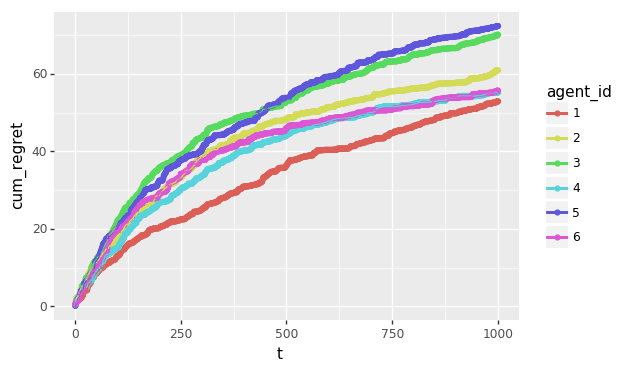

<ggplot: (8758057980037)>


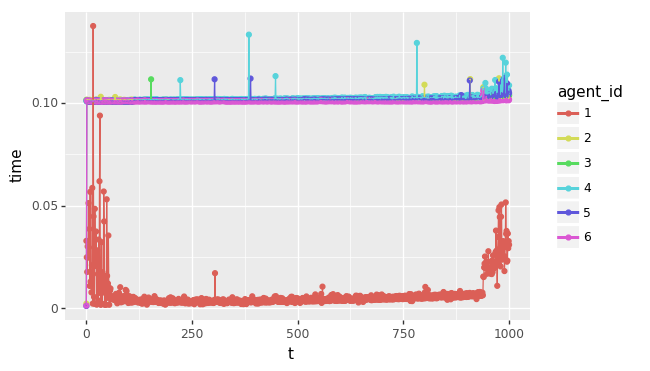

<ggplot: (8758151884069)>


([[      action_id agent_id  cum_optimal  cum_regret  instant_regret     t  \
   0             1        1     0.678810    0.491887        0.491887     1   
   1             2        2     0.678810    0.491887        0.491887     1   
   2             3        3     0.678810    0.112411        0.112411     1   
   3             4        4     0.678810    0.491887        0.491887     1   
   4             5        5     0.678810    0.187239        0.187239     1   
   5             6        6     0.678810    0.491887        0.491887     1   
   6             7        1     1.536035    0.795514        0.303627     2   
   7             8        2     1.536035    1.341690        0.849803     2   
   8             9        3     1.536035    0.416039        0.303627     2   
   9            10        4     1.536035    0.857542        0.365655     2   
   10           11        5     1.536035    0.552894        0.365655     2   
   11           12        6     1.536035    0.795514        0.30

In [12]:
simple_compares(make_agents, num_articles, dim, var, 1000, [402], verbosity=verbosity)
